In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
Asset_PATH = "/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/"

#### Load Gaussian KDE timeseries

In [3]:
density_matrix_t_series = pickle.load(open(Asset_PATH  + 'density_matrix_t_series_100x100.pickle', 'rb'))

In [4]:
density_matrix_t_series.shape

(198, 100, 100)

In [5]:
print(np.max(density_matrix_t_series))
print(np.min(density_matrix_t_series))

2019.7794007598727
-2.393156546274511e-13


In [6]:
density_matrix_t_series.shape[0]

198

In [7]:
timesteps = 52

In [8]:
train, valid = (60,20)
test = 20

total_len = density_matrix_t_series.shape[0] - timesteps
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

In [9]:
flattened_matrix_np = np.reshape(density_matrix_t_series, 
                                 (density_matrix_t_series.shape[0],
                                  density_matrix_t_series.shape[1]*density_matrix_t_series.shape[2]))
flattened_matrix_np.shape

(198, 10000)

In [10]:
np.max(flattened_matrix_np[train_index])

1935.6194220503628

In [11]:
scaler_max = np.max(flattened_matrix_np[train_index])
scaler_min = np.min(flattened_matrix_np[train_index])

X_train = (flattened_matrix_np[train_index] - scaler_min)/(scaler_max - scaler_min)


In [12]:
X_train = X_train.reshape(X_train.shape[0],
                          1,    
                          X_train.shape[1])
X_train.shape

(87, 1, 10000)

In [13]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],int(X_train.shape[2]**(1/2)),int(X_train.shape[2]**(1/2)),1)
X_train.shape

(87, 1, 100, 100, 1)

In [14]:
print(np.max(X_train))
print(np.min(X_train))

1.0
0.0


#### We transform the whole train, valid, test based on scaler fitted on train

In [15]:
np.max(flattened_matrix_np)

2019.7794007598727

In [16]:
flattened_matrix_np.dtype

dtype('float64')

In [17]:
scaled_flattened_matrix = (flattened_matrix_np - scaler_min)/(scaler_max - scaler_min)

In [18]:
flattened_matrix_np.shape

(198, 10000)

In [19]:
scaled_flattened_matrix.shape

(198, 10000)

In [20]:
print(np.max(scaled_flattened_matrix))
print(np.min(scaled_flattened_matrix))

1.0434796105839654
-3.2227207716804404e-17


In [21]:
scaled_flattened_matrix.shape

(198, 10000)

In [22]:
def window_stack(a, stepsize=1, width=52):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

In [23]:
stacked = window_stack(scaled_flattened_matrix,1,timesteps)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
stacked.shape

(147, 520000)

In [25]:
reshape_stack = stacked.reshape(stacked.shape[0],timesteps,
                                int((stacked.shape[1]/timesteps)**(1/2)),
                                int((stacked.shape[1]/timesteps)**(1/2)),1)

In [26]:
reshape_stack.shape

(147, 52, 100, 100, 1)

#### We reshape to (sample, timestep, inputshape)

In [27]:
scaled_flattened_matrix = reshape_stack
scaled_flattened_matrix.shape

(147, 52, 100, 100, 1)

In [28]:
train, valid = (60,20)
test = 20

total_len = scaled_flattened_matrix.shape[0]
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

#### We set the target to be 7 days aggregated KDE or 1 single frame forward

In [29]:
X_train = scaled_flattened_matrix[np.array(train_index)]
Y_train = scaled_flattened_matrix[np.array(train_index)+1][:,-1,:]
Y_train = Y_train.reshape(Y_train.shape[0],int(Y_train.shape[1]*Y_train.shape[2]*Y_train.shape[3]))

In [30]:
X_valid = scaled_flattened_matrix[np.array(valid_index)]
Y_valid = scaled_flattened_matrix[np.array(valid_index)+1][:,-1,:]
Y_valid = Y_valid.reshape(Y_valid.shape[0],int(Y_valid.shape[1]*Y_valid.shape[2]*Y_valid.shape[3]))

In [31]:
X_test = scaled_flattened_matrix[np.array(test_index)]
Y_test = scaled_flattened_matrix[np.array(test_index)+1][:,-1,:]
Y_test = Y_test.reshape(Y_test.shape[0],int(Y_test.shape[1]*Y_test.shape[2]*Y_test.shape[3]))

In [32]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(88, 52, 100, 100, 1)
(88, 10000)
(28, 52, 100, 100, 1)
(28, 10000)
(28, 52, 100, 100, 1)
(28, 10000)


In [33]:
import os, datetime
import tensorflow as tf
from tensorflow.keras import optimizers
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GaussianNoise, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, LSTM, GRU, RepeatVector, TimeDistributed
from tensorflow.keras.layers import concatenate, Activation, Permute, Multiply, Lambda, Reshape, LeakyReLU, Attention


In [34]:
checkpoint_filepath = Asset_PATH+'checkpoints/'
print(checkpoint_filepath)

/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/


## FFT + Dense Layer out

In [39]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

#Frequency Head
timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2, 1])(timeDist) #transpose for FFT. FFT library treats the last dimension as time
print('timeDist.shape',timeDist.shape)
fftLayer = Lambda(lambda x : tf.math.abs(tf.signal.rfft(x)))(timeDist) ## transform to frequency domain with TF
fftLayer  = Permute([2, 1], name="fft_out")(fftLayer)#transpose back for the following shape
print('fftLayer.shape',fftLayer.shape)  
#(None,num_of_frequencies,num_of_features)
#compress frequency domain data from 10000 to downsized dimension for attention
#Time distributed is now frequency distributed
timeDist4 = TimeDistributed(Dense(100))(fftLayer)
units = timeDist4.shape[2]

Dense_out2 = TimeDistributed(Dense(3, activation='relu'))(timeDist4)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense_out2))
outputs = Dense2

model = Model(inputs, outputs, name="Attention_FFT")
model.summary()

adam = optimizers.Adam(lr)
#rmsProp = optimizers.RMSprop(learning_rate=lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


timeDist.shape (None, 10000, 52)
fftLayer.shape (None, 27, 10000)
Model: "Attention_FFT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 52, 10000)         0         
_________________________________________________________________
permute_2 (Permute)          (None, 10000, 52)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 10000, 27)         0         
_________________________________________________________________
fft_out (Permute)            (None, 27, 10000)         0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 27, 100)           1000100   
_____________________________________________________

#### FFT + Attention vs FFT + Dense layer out have identical MAE. This proves attention is not needed for frequency domain data.

## TimeDistributed attention + attention on time

In [60]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2,1])(timeDist) #3D transpose between pixel and time dimension
units = timeDist.shape[2]
# compute importance for each step
attention1 = Dense(units, activation='tanh')(timeDist) ## weight matrix W (= units x units)
attention1 = Dense(1, activation='linear')(attention1)     ## weight matrix v (= units x 1)
attention1 = Flatten()(attention1)
attention1 = Activation('softmax',name='attention1_weights')(attention1)
attention1 = RepeatVector(units)(attention1)
attention1 = Permute([2, 1])(attention1)
attention1 = Multiply()([timeDist, attention1])
attention1 = Permute([2, 1])(attention1) #transpose back to time being shape[1]
print(attention1.shape)
timeDist2 = TimeDistributed(Dense(100))(attention1)
units = timeDist2.shape[2]
# compute importance for each step
attention2 = Dense(units, activation='tanh')(timeDist2) ## weight matrix W (= units x units)
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax',name='attention2_weights')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
sent_representation = Multiply()([timeDist2, attention2])
#For each timestep update a single weight on Dense layer
attended_Dense_out = TimeDistributed(Dense(3, activation='relu'))(sent_representation)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out))
outputs = Dense2

model = Model(inputs, outputs, name="TimeDistributed_attention2_plus_attention2_on_time")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


(None, 52, 10000)
Model: "TimeDistributed_attention2_plus_attention2_on_time"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_12 (TimeDistri (None, 52, 10000)    0           input_5[0][0]                    
__________________________________________________________________________________________________
permute_13 (Permute)            (None, 10000, 52)    0           time_distributed_12[0][0]        
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 10000, 52)    2756        permute_13[0][0]                 
_______________________________

In [86]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention1_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

#### We peak at trained attention1 on the image layer

In [87]:
vmax,vmin = np.max(intermediate_layer_model.predict(X_valid)),np.min(intermediate_layer_model.predict(X_valid))

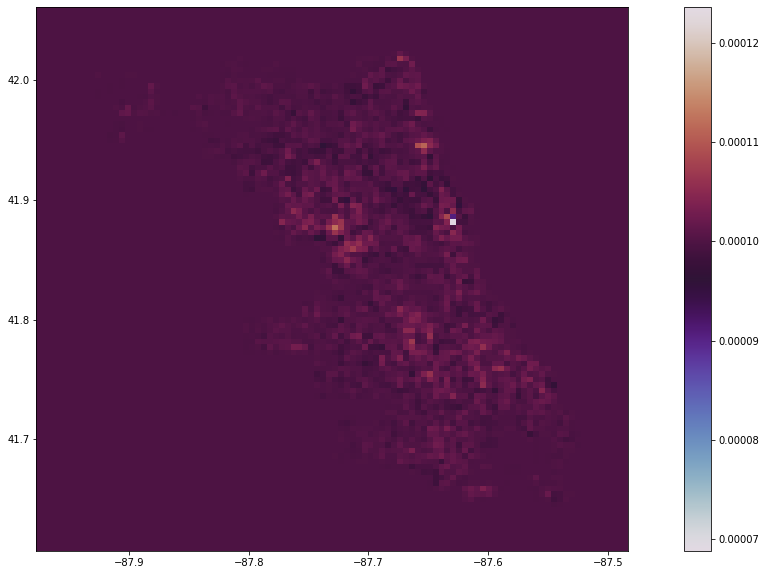

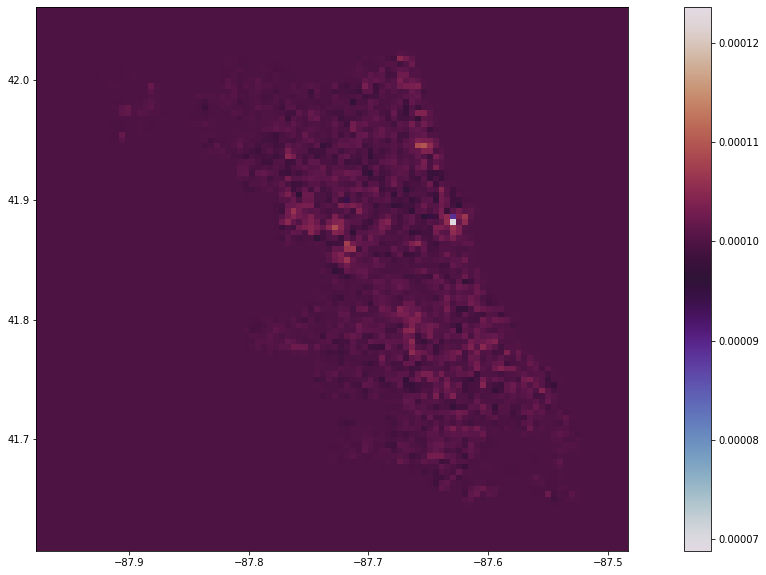

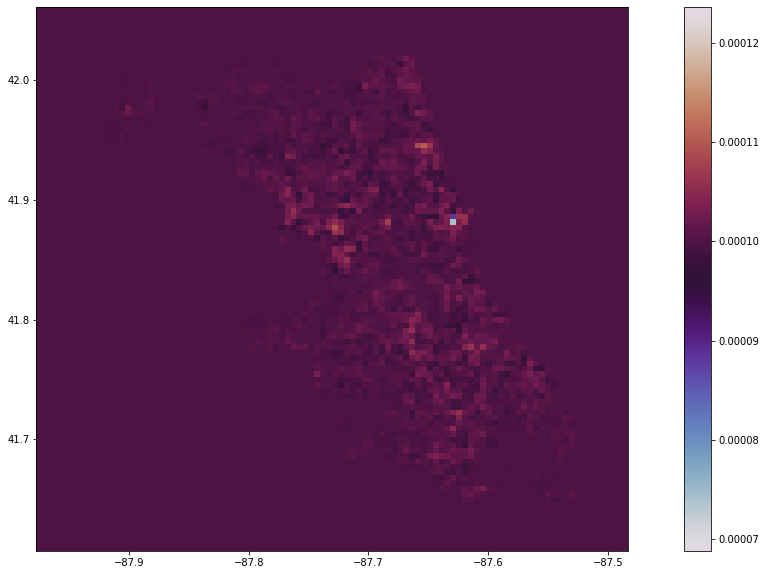

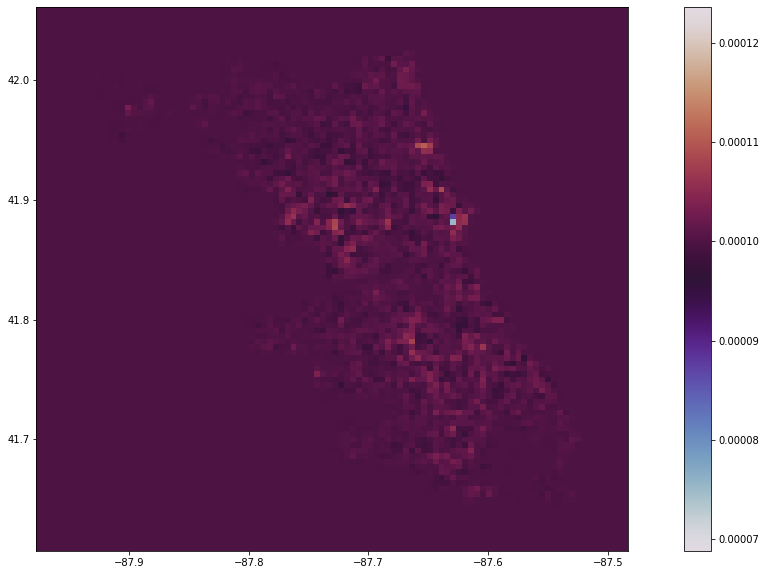

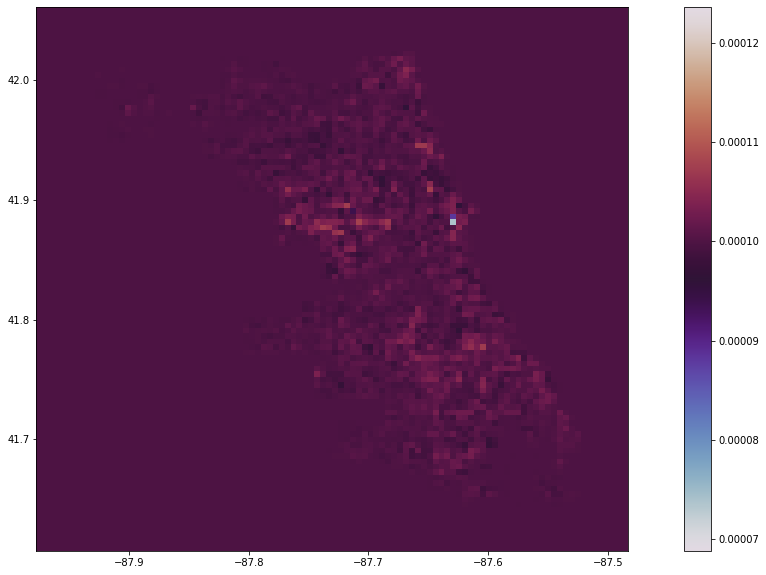

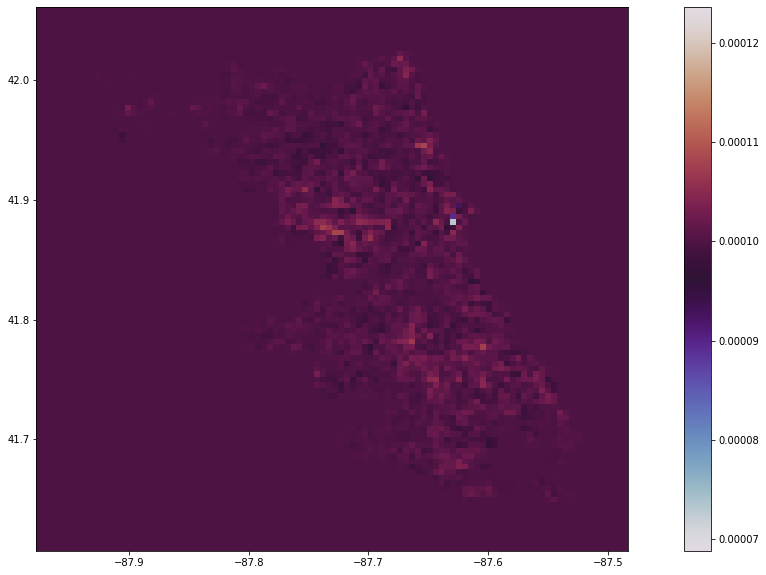

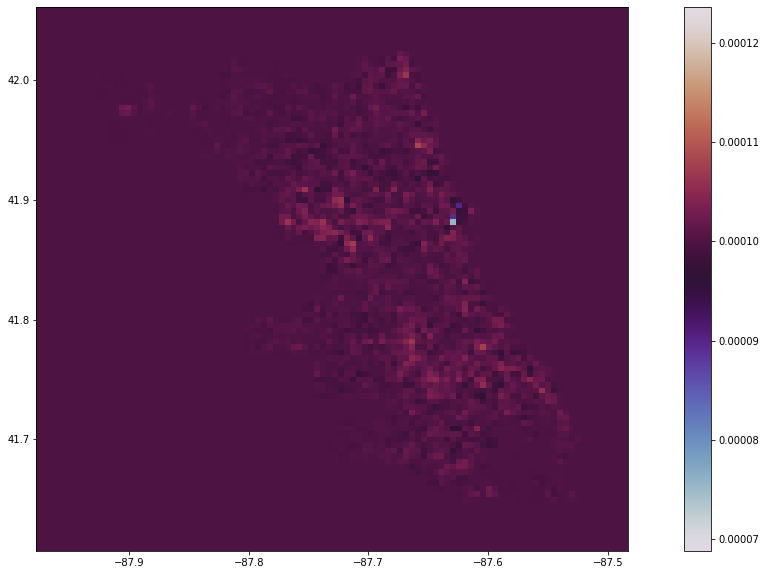

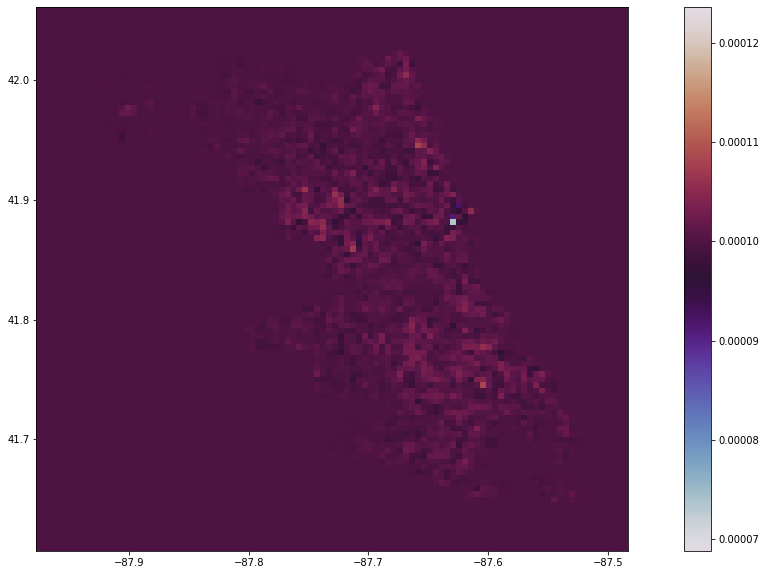

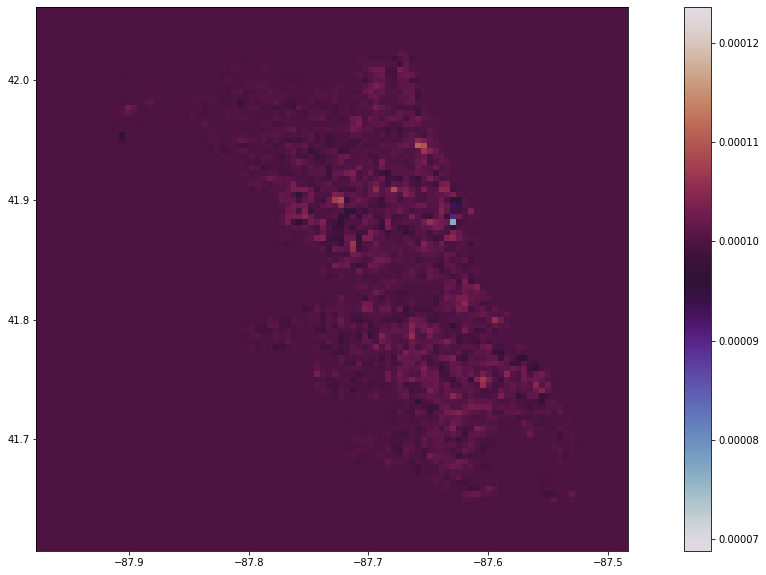

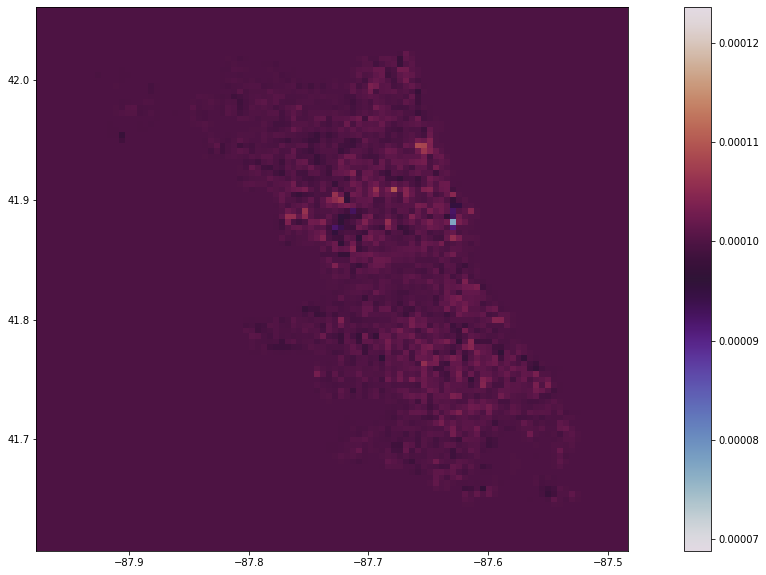

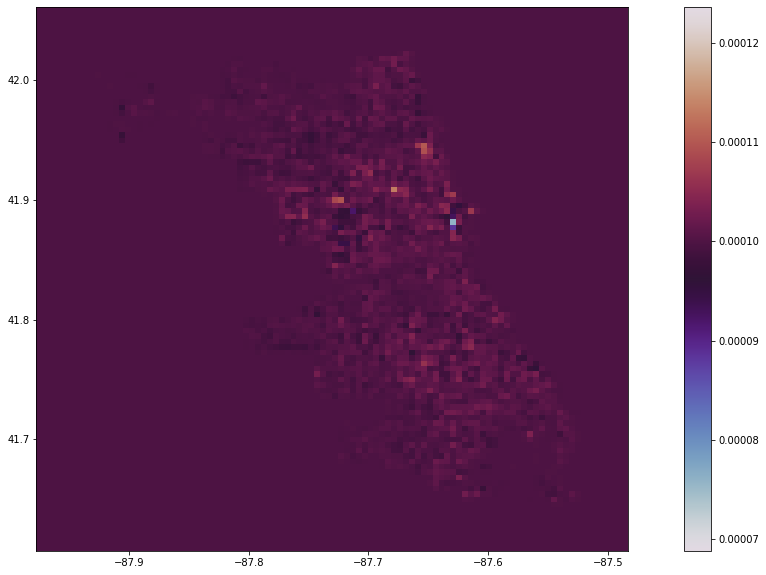

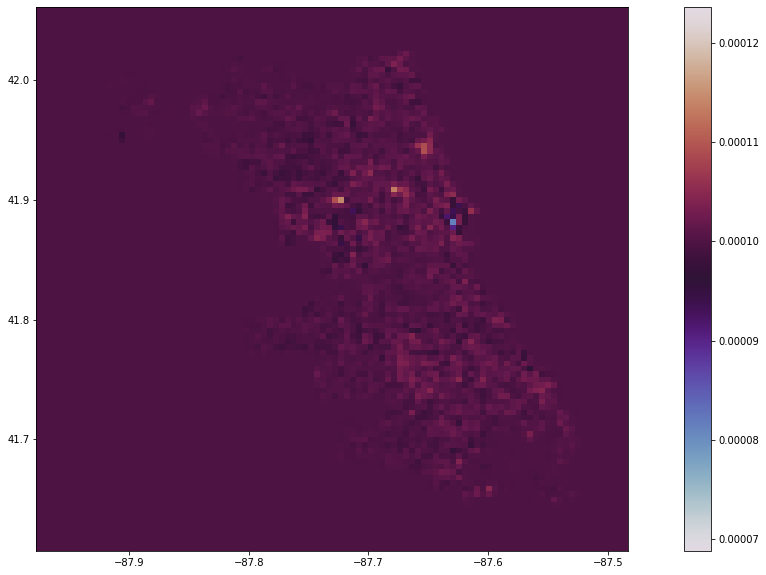

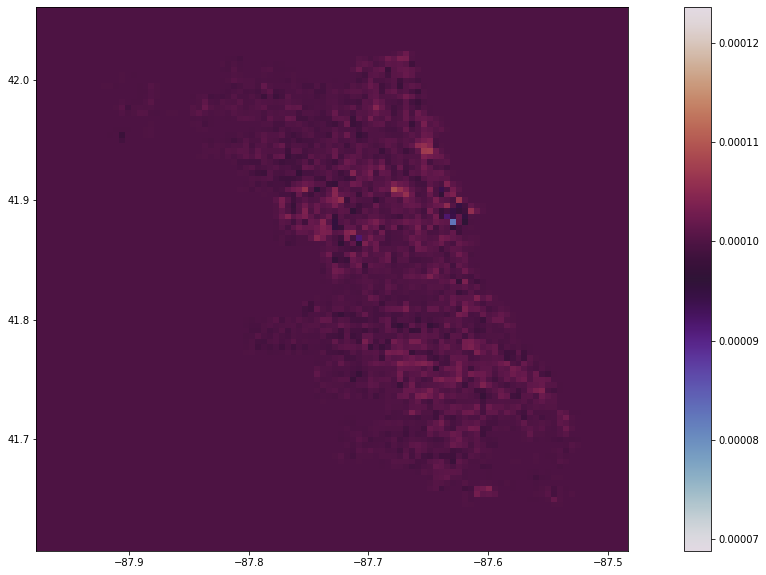

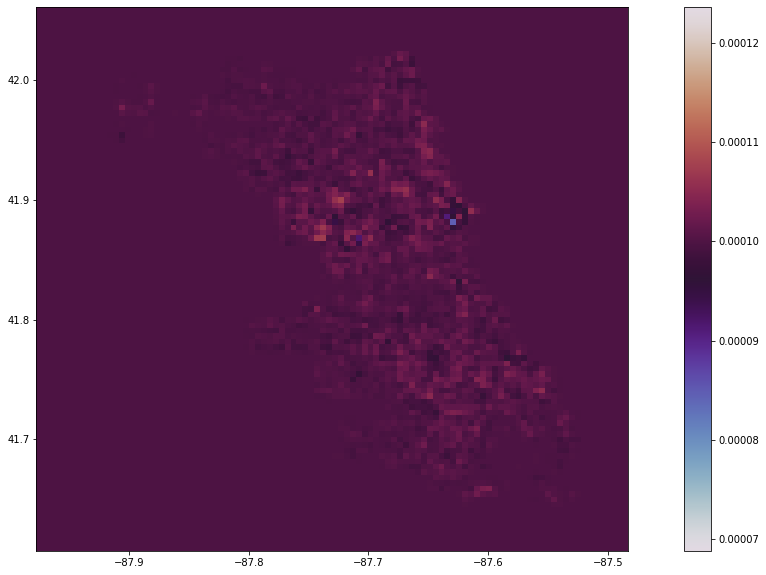

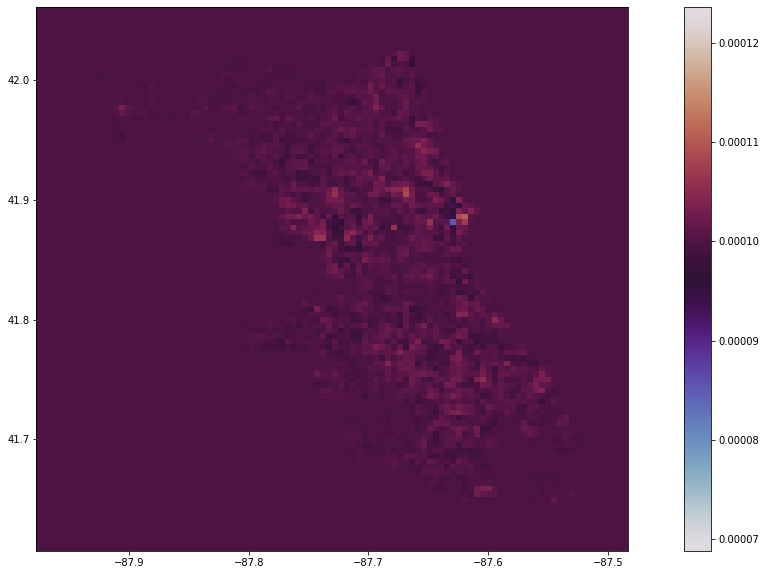

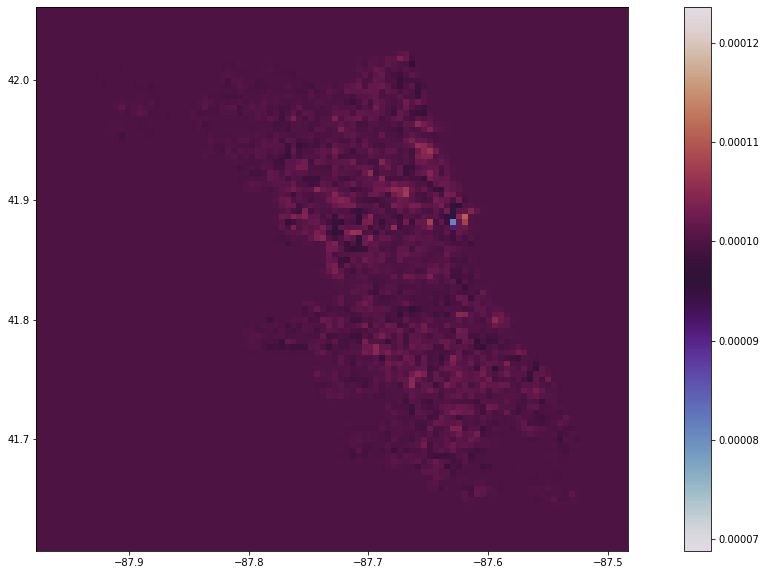

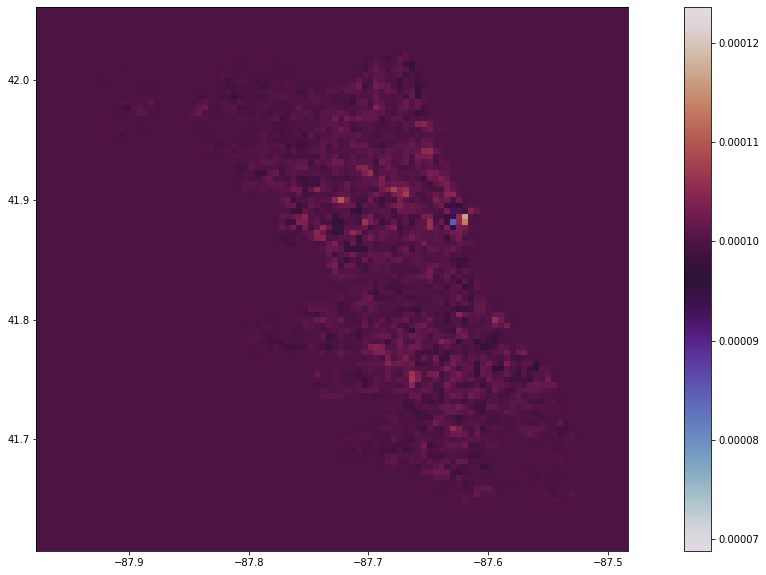

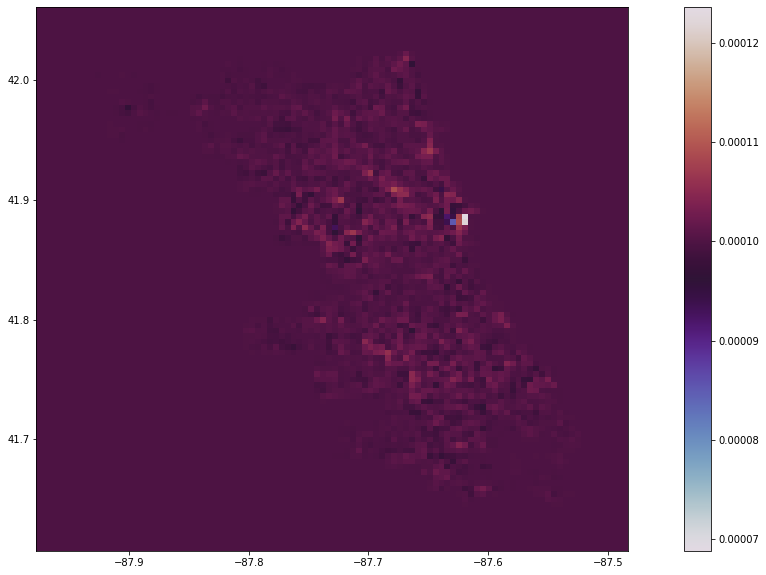

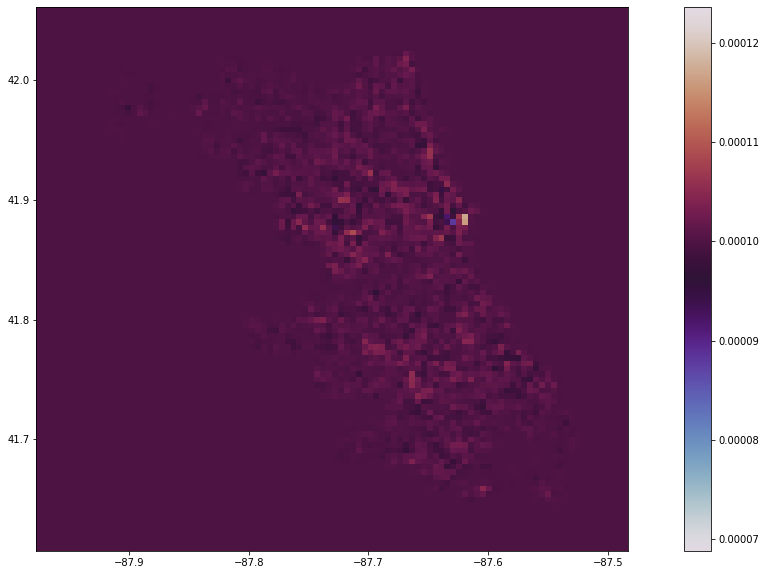

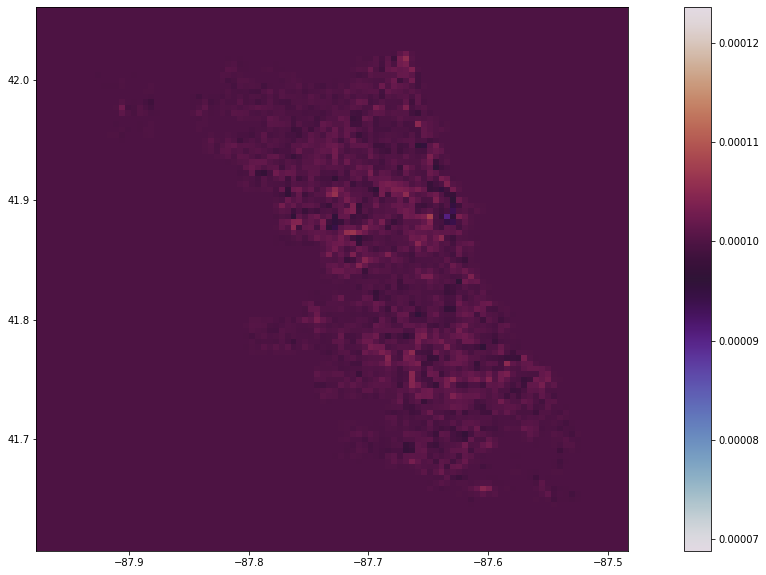

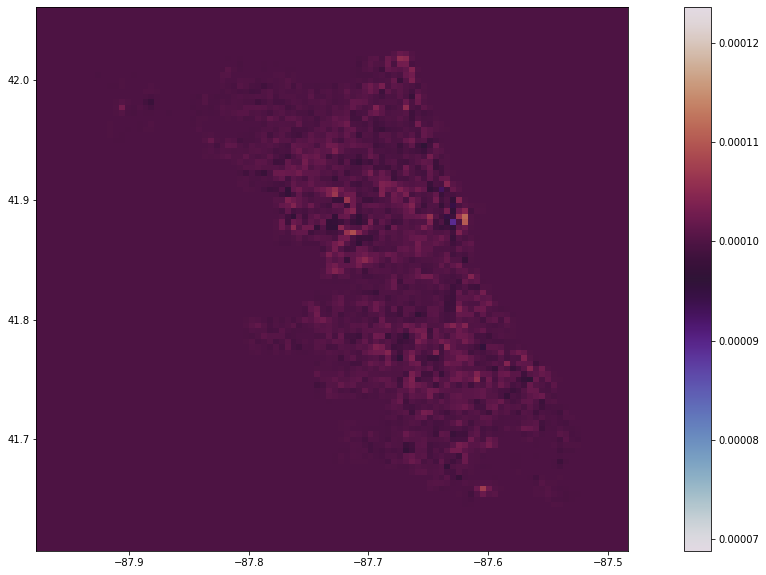

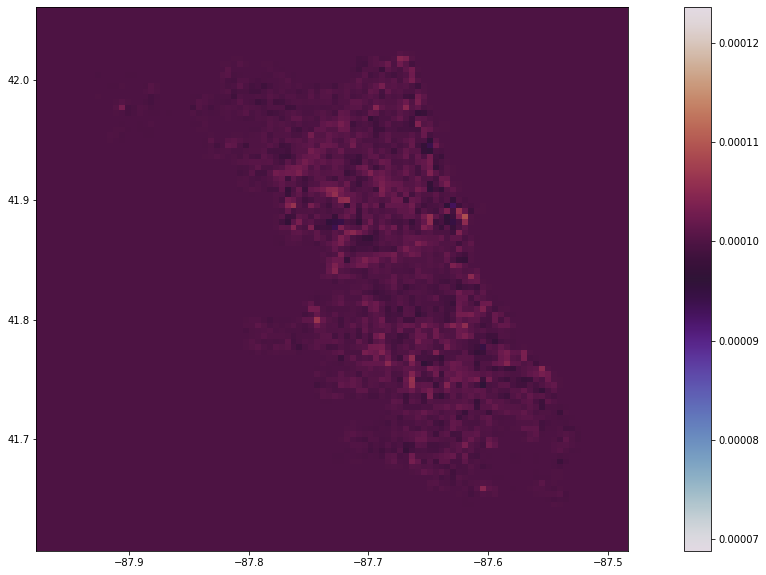

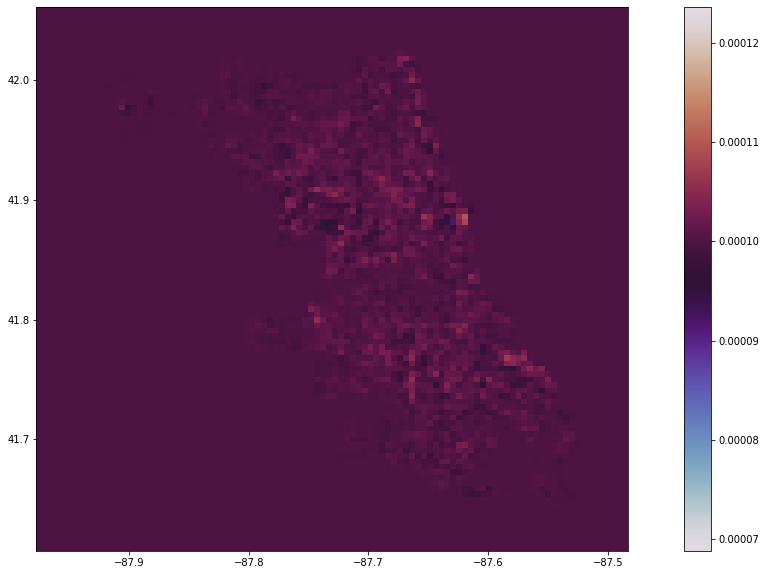

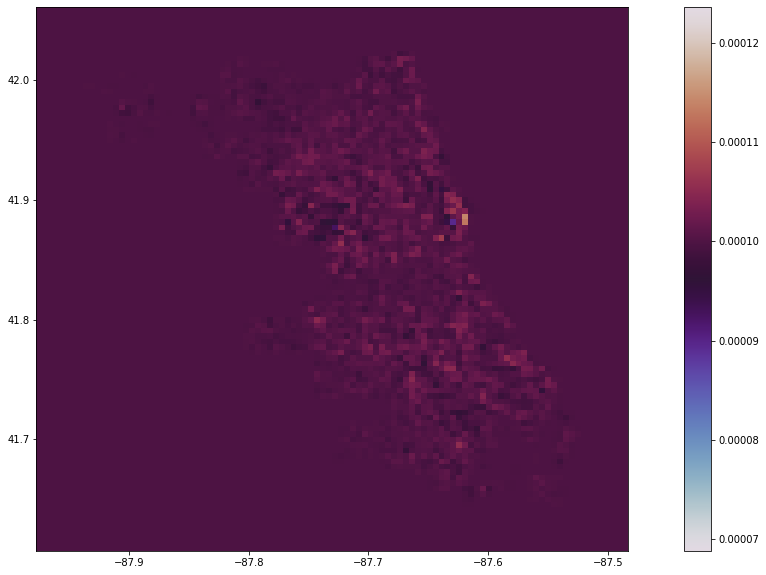

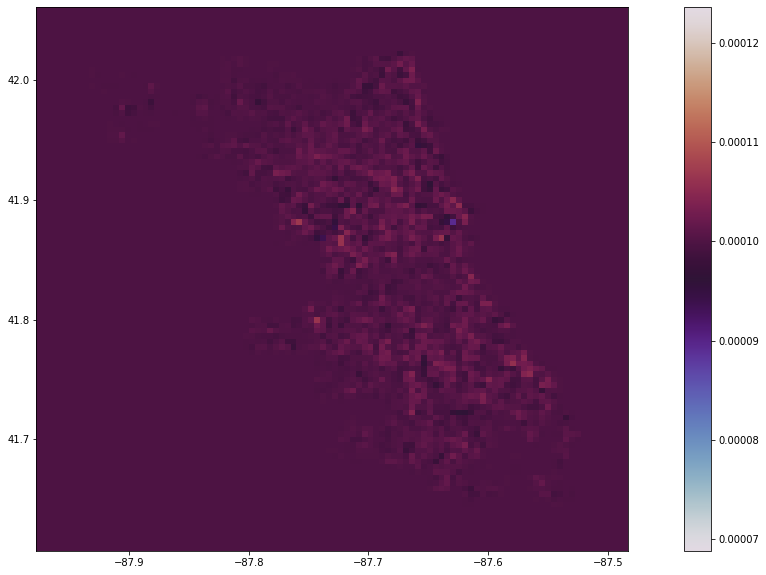

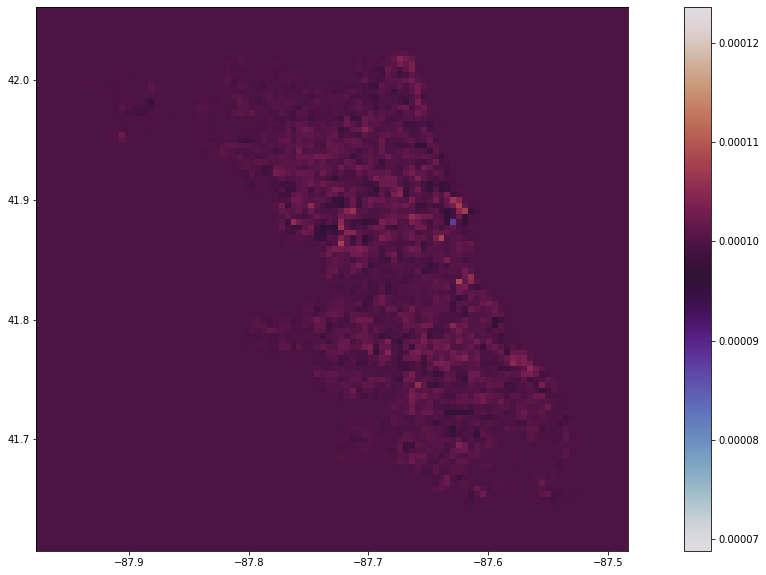

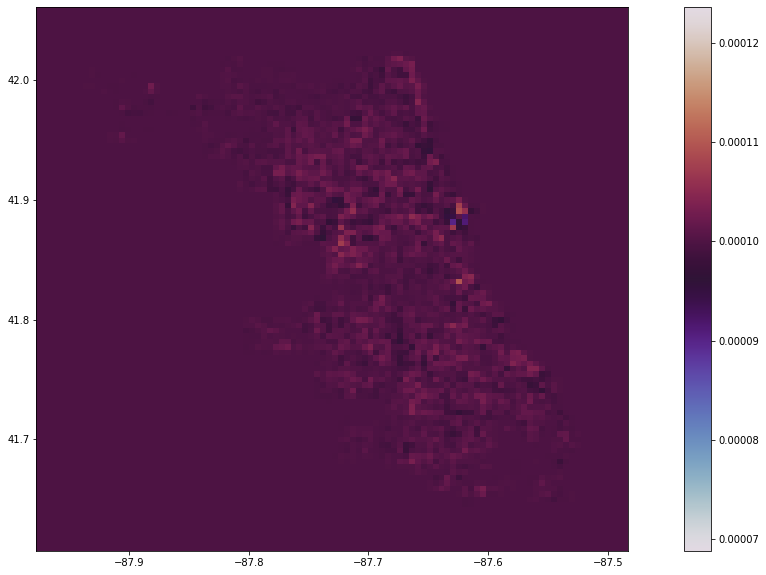

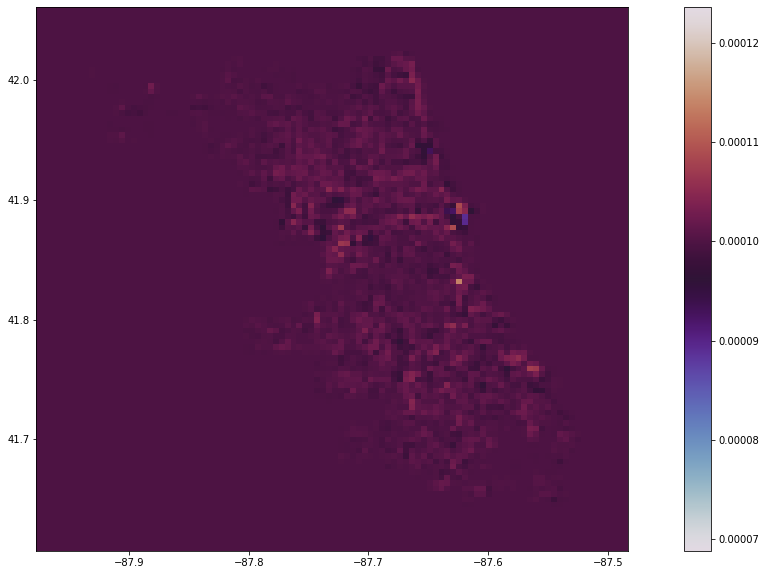

In [92]:
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    #print(intermediate_output.shape)
    attImage = intermediate_output[0,:].reshape(100,100)
    #print(attImage.shape)
    plt.figure(figsize=(20,10))
    plt.imshow( X=np.rot90(attImage),vmin=vmin, vmax=vmax,cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    plt.show()

In [93]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention2_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

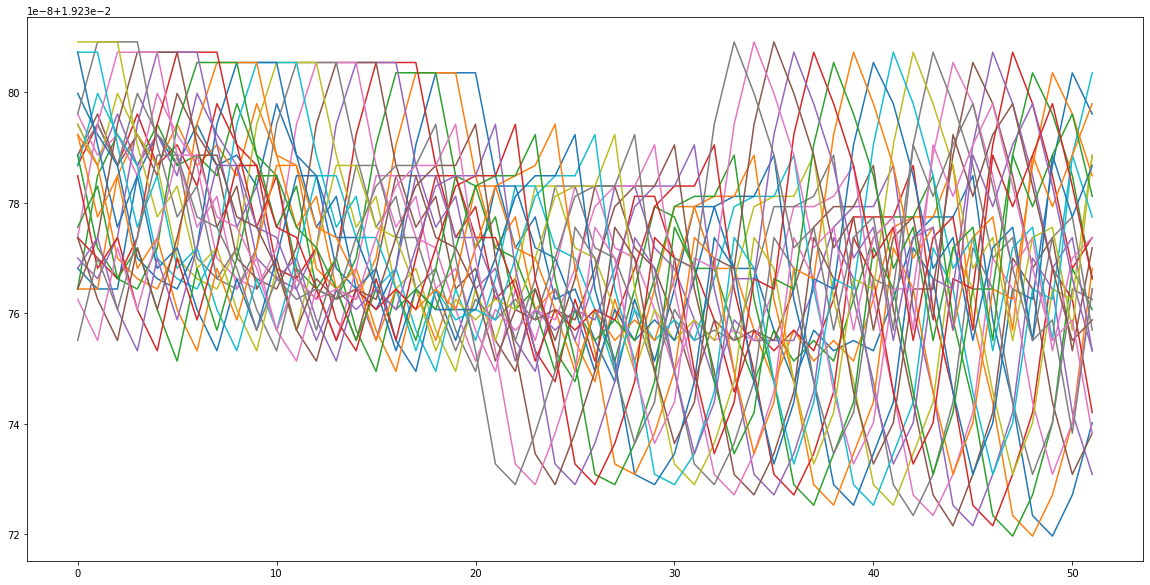

In [94]:
plt.figure(figsize=(20,10))
for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    plt.plot(intermediate_output[0])
    #plt.show()

#### Each head converged to similar pattern to previous independent time and frequency domain mode.

## Run fit on any of the previous model here

In [73]:
EPOCHS = 5

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=EPOCHS*10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)

logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cbk = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelfilename = checkpoint_filepath + '_'+\
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\
                    + "_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelfilename,
    save_weights_only=False,
    monitor='val_loss',#'val_accuracy',
    mode='min',
    verbose=1,
    period = 1,
    save_best_only=True)


model.summary()

model_history = model.fit(X_train,Y_train, 
                             validation_data=(X_valid, Y_valid),
                             epochs=1000, 
                             batch_size=6, 
                             callbacks=[tensorboard_cbk,
                             #hp.KerasCallback(logdir, hparams),
                             earlystop_callback,
                             model_checkpoint_callback
                                       ])

valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

Model: "TimeDistributed_attention2_plus_attention2_on_time"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_12 (TimeDistri (None, 52, 10000)    0           input_5[0][0]                    
__________________________________________________________________________________________________
permute_13 (Permute)            (None, 10000, 52)    0           time_distributed_12[0][0]        
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 10000, 52)    2756        permute_13[0][0]                 
_________________________________________________

Epoch 10/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00010: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 11/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00011: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 12/1000
72/88 [=======================>......] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00012: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 13/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00013: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.

78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00041: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 42/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00042: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 43/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00043: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 44/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00044: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.

# Test Set accuracy

#### Flattened+Attention

In [54]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.002142413, valid_loss=0.002142413053661585


#### Flattened+LSTM+Attention

In [48]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.0021439143, valid_loss=0.002143914345651865


#### FFT+Attention

In [104]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.002143551, valid_loss=0.0021435508970171213


#### Attention on Attention

In [74]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.0021426457, valid_loss=0.002142645651474595


# Validation Set:

### Best flatten() + fully connected Dense is at  MAE of 0.001698

### Best flatten() + LSTM(100) is at  MAE of 0.001731

### Best 2D CNN + LSTM(50) is at MAE of 0.001724

### Best 2D CNN + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.0016917

### Best flatten() + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.0016915

### Best flatten() + 2x Attention Heads on  TimeDistributed is at MAE of 0.0016920

### Best FFT + Attention Heads on  TimeDistributed is at MAE of 0.0016920

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [95]:
Predict = model.predict(X_valid)

In [96]:
Predict.shape

(28, 10000)

In [97]:
int(Predict[-1].shape[0]**(1/2)),int(Predict[-1].shape[0]**(1/2))

(100, 100)

In [98]:
def reshapePred(Predict, fromLast=1):
    return np.rot90(Predict[-1*fromLast].reshape(int(Predict[-1*fromLast].shape[0]**(1/2)),int(Predict[-1*fromLast].shape[0]**(1/2))))

In [99]:
Y_valid.shape

(28, 10000)

In [113]:
vmax, vmin = np.max(Predict),np.min(Predict)
vmax, vmin

(0.73772967, -6.44053e-05)

In [121]:
dvmax, dvmin = np.max(Predict-Y_valid),np.min(Predict-Y_valid)
dvmax, dvmin

(0.10672817994715811, -0.22218610460662297)

In [122]:
diff_max,diff_min = (dvmax , dvmin ) 
def scaleDiff(diff,diff_max,diff_min):
    return (diff - diff_min)/(diff_max - diff_min)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

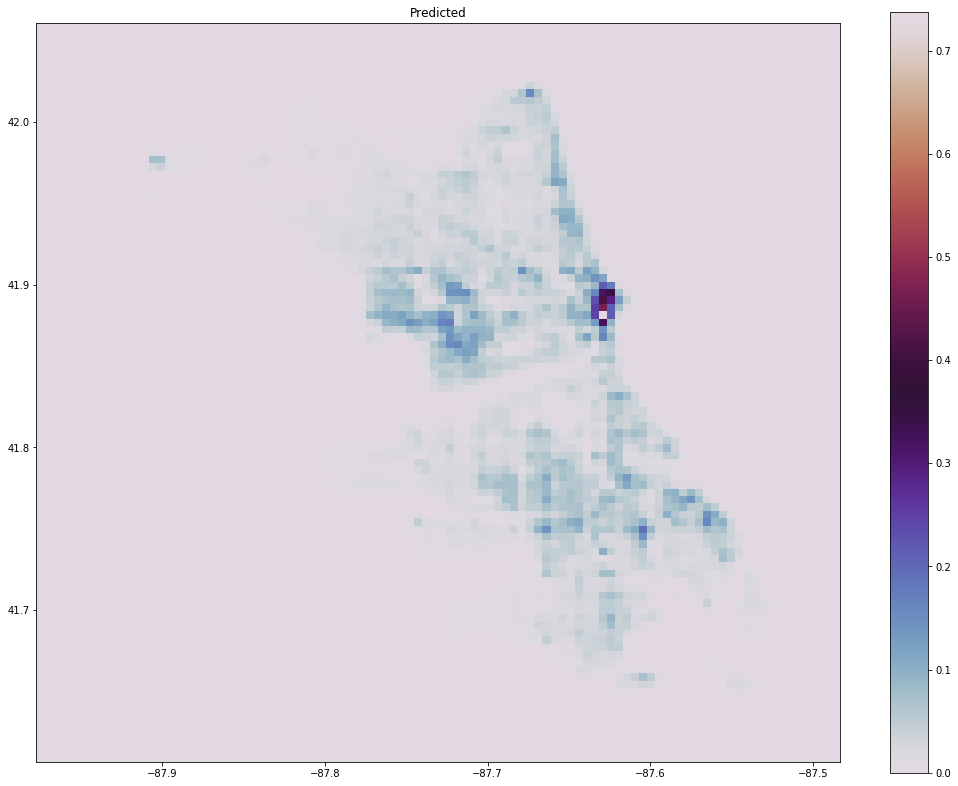

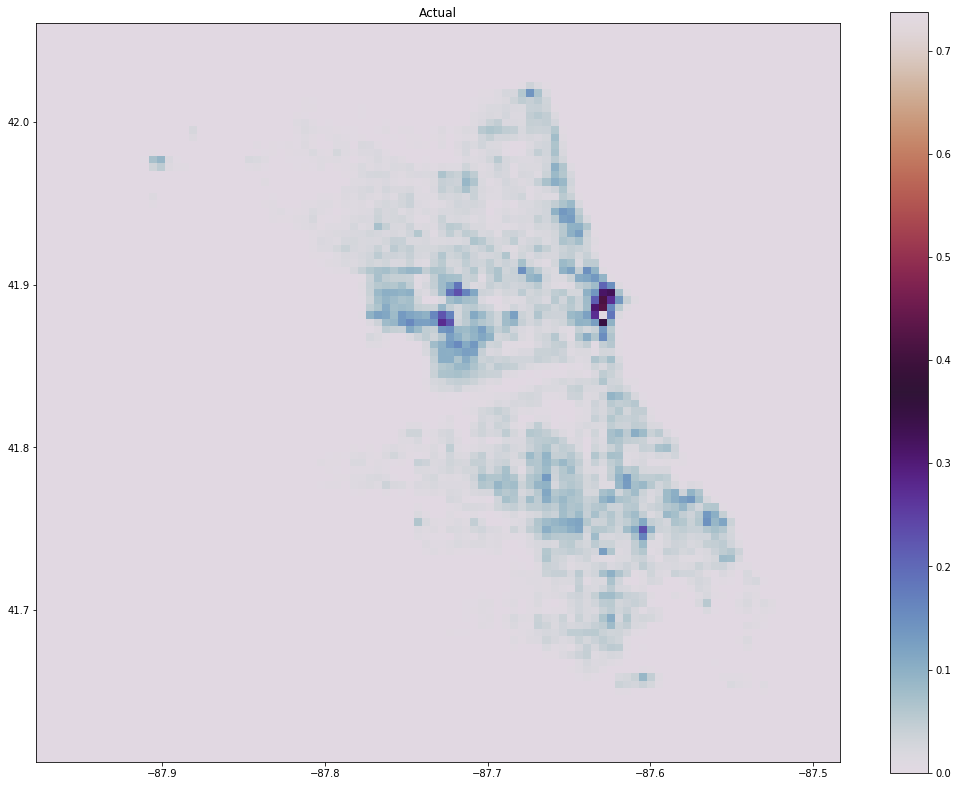

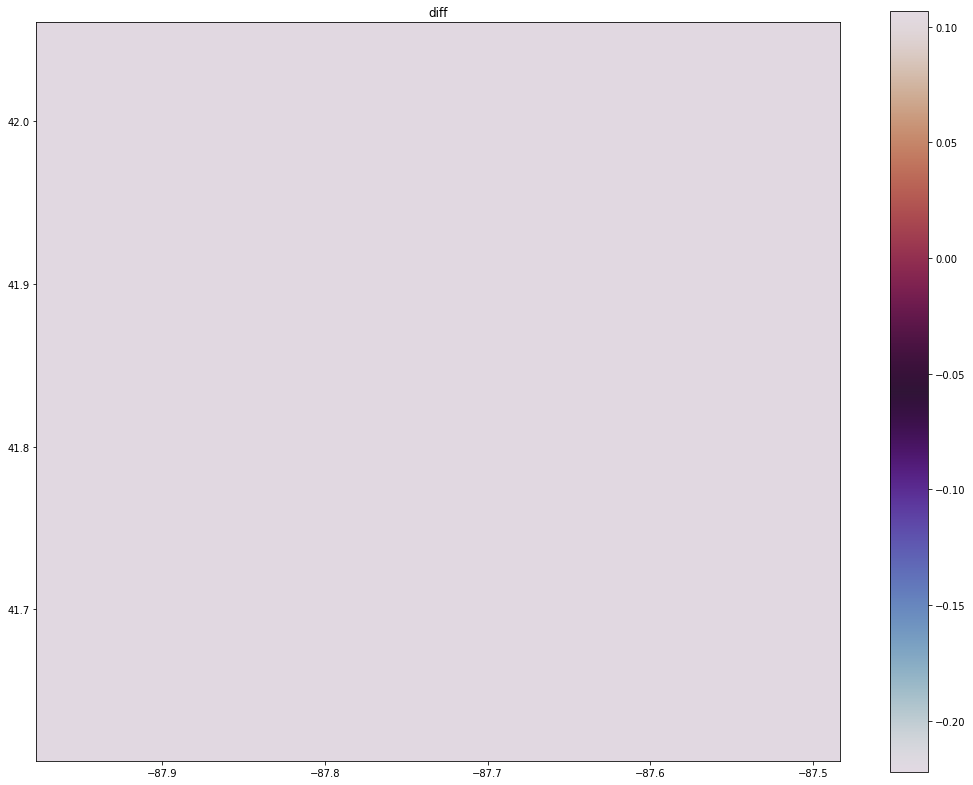

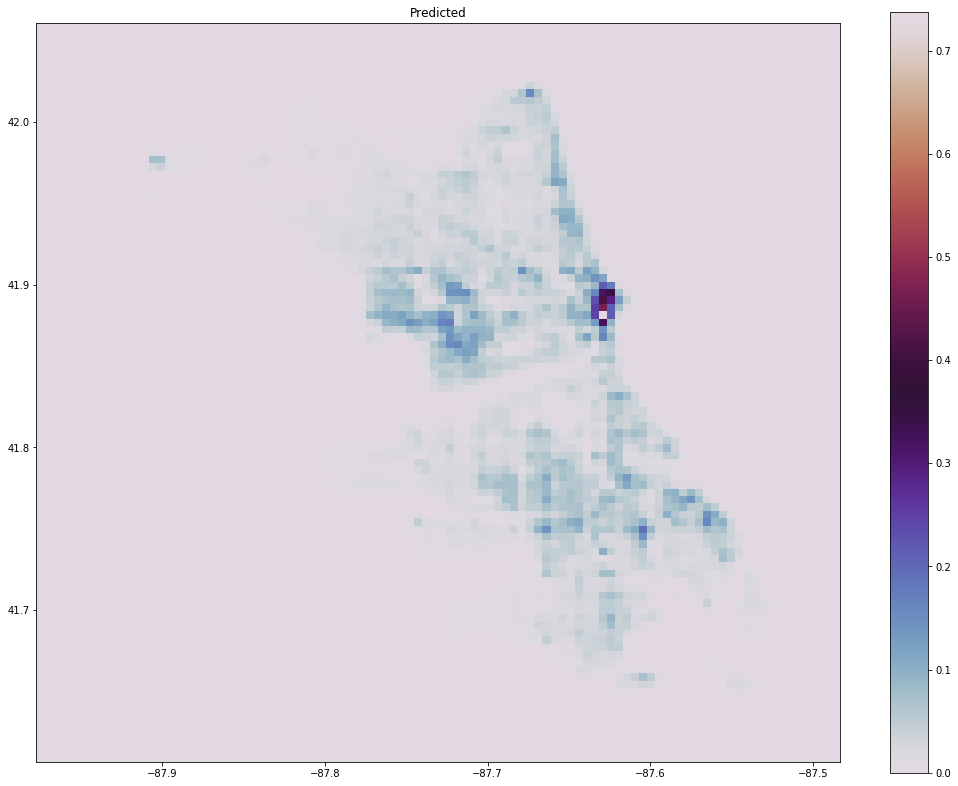

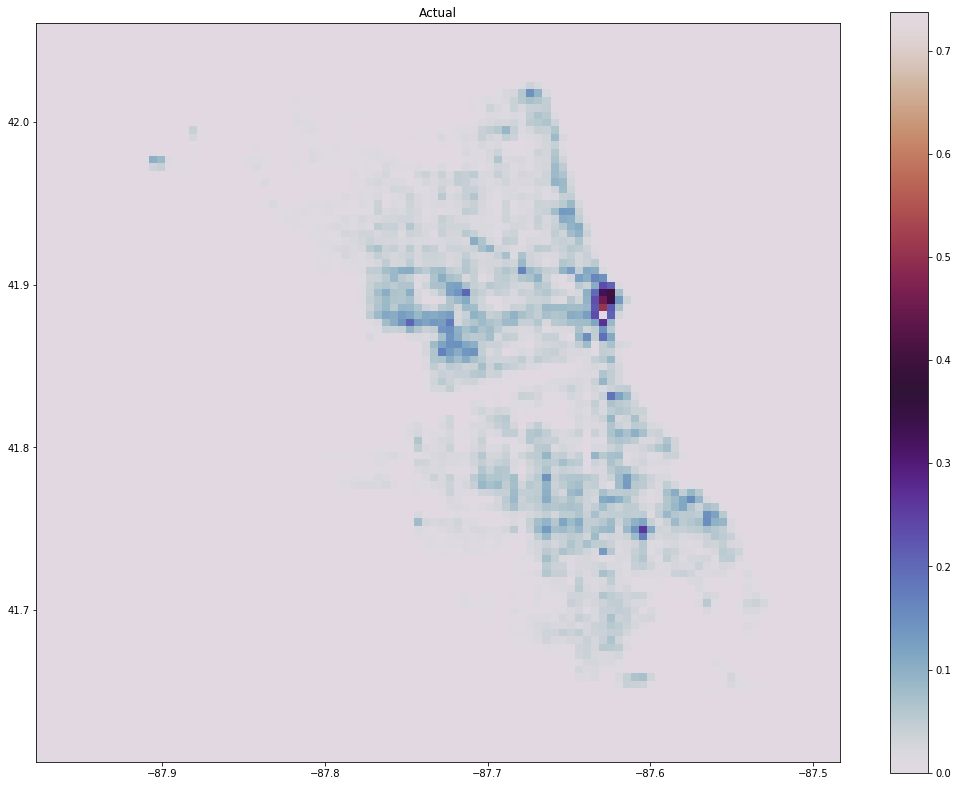

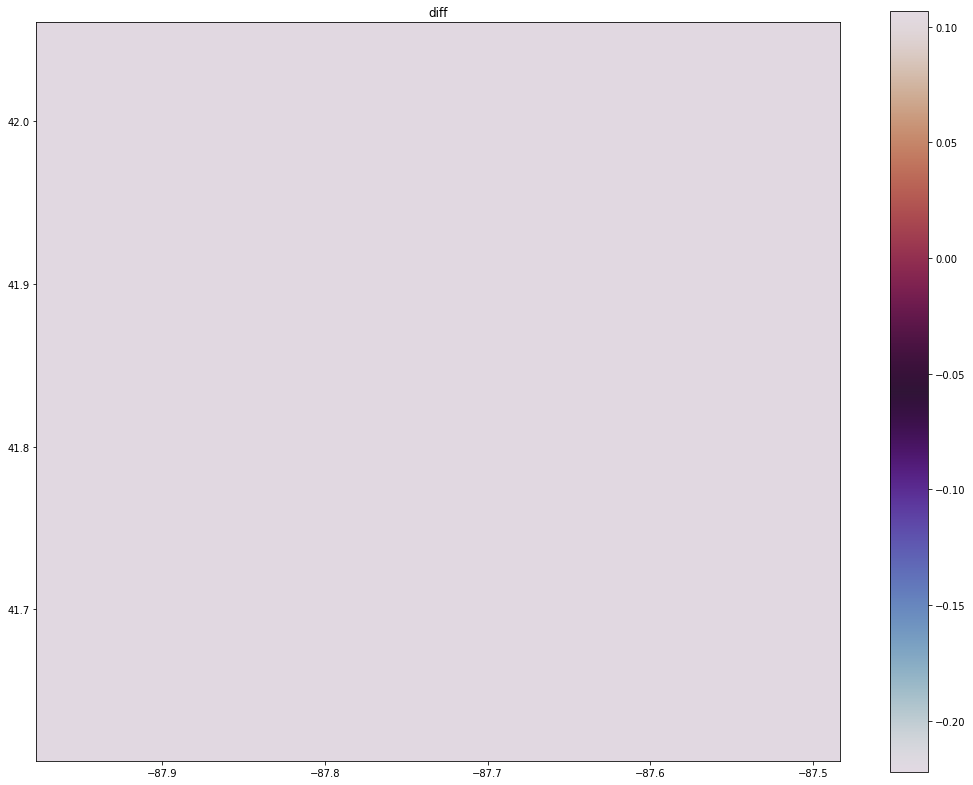

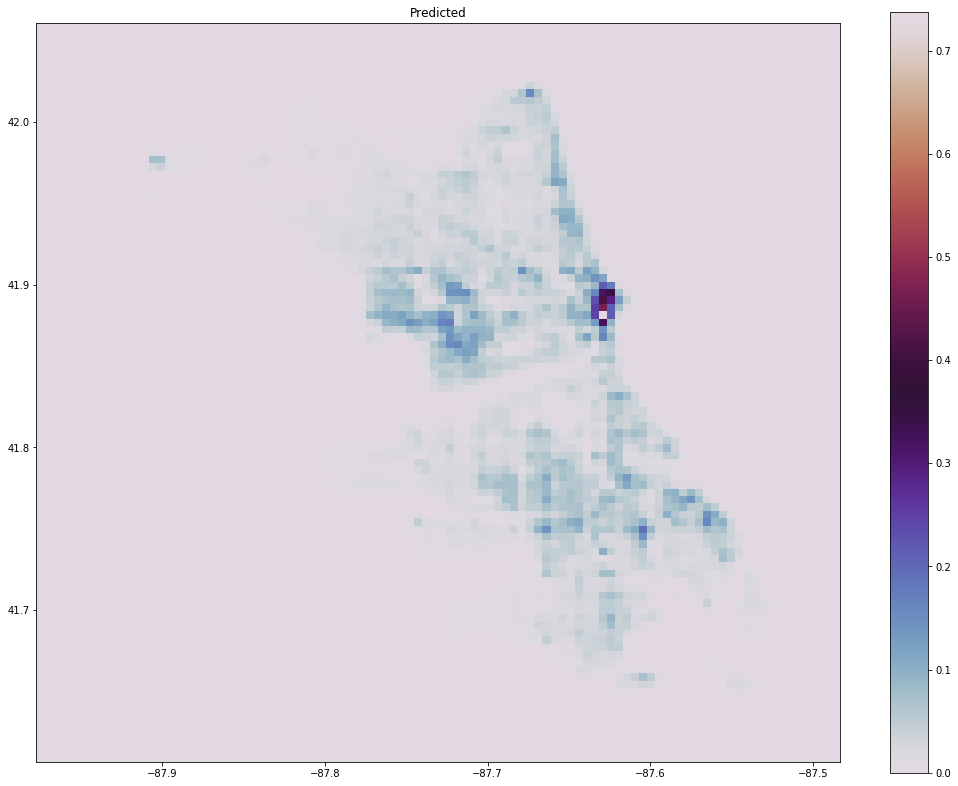

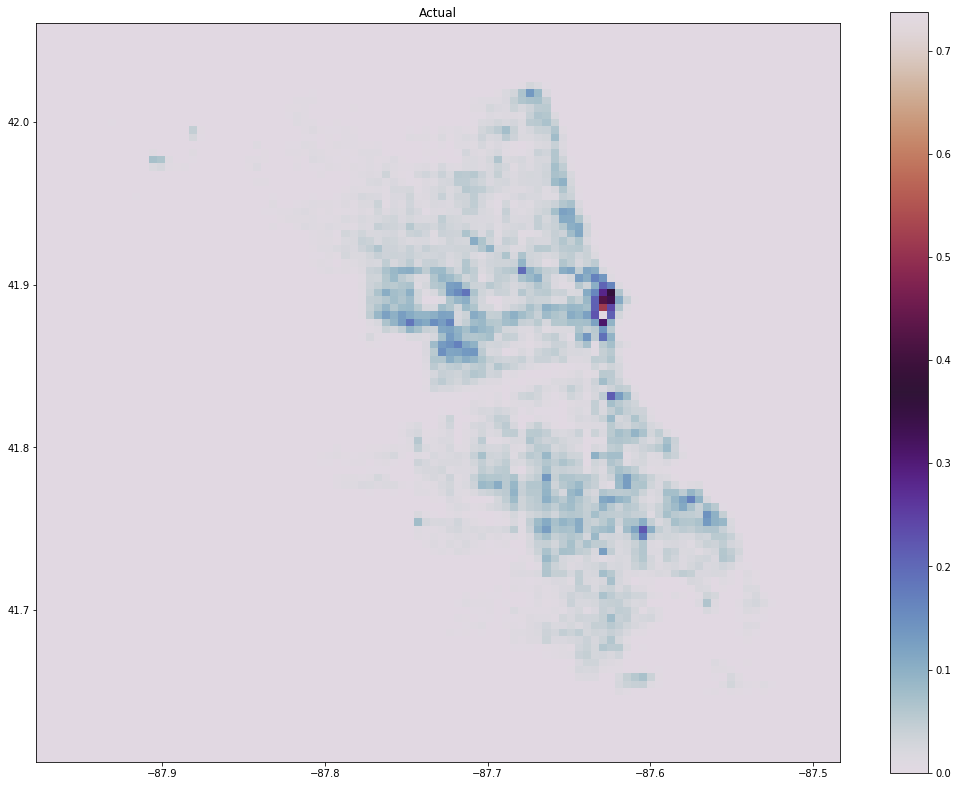

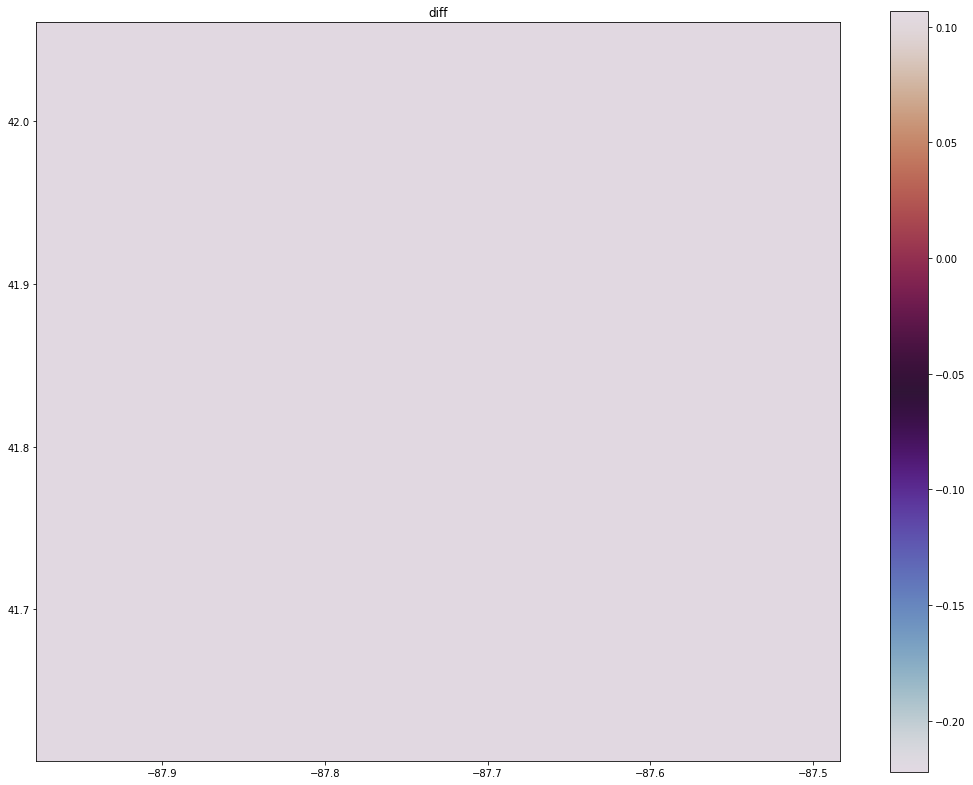

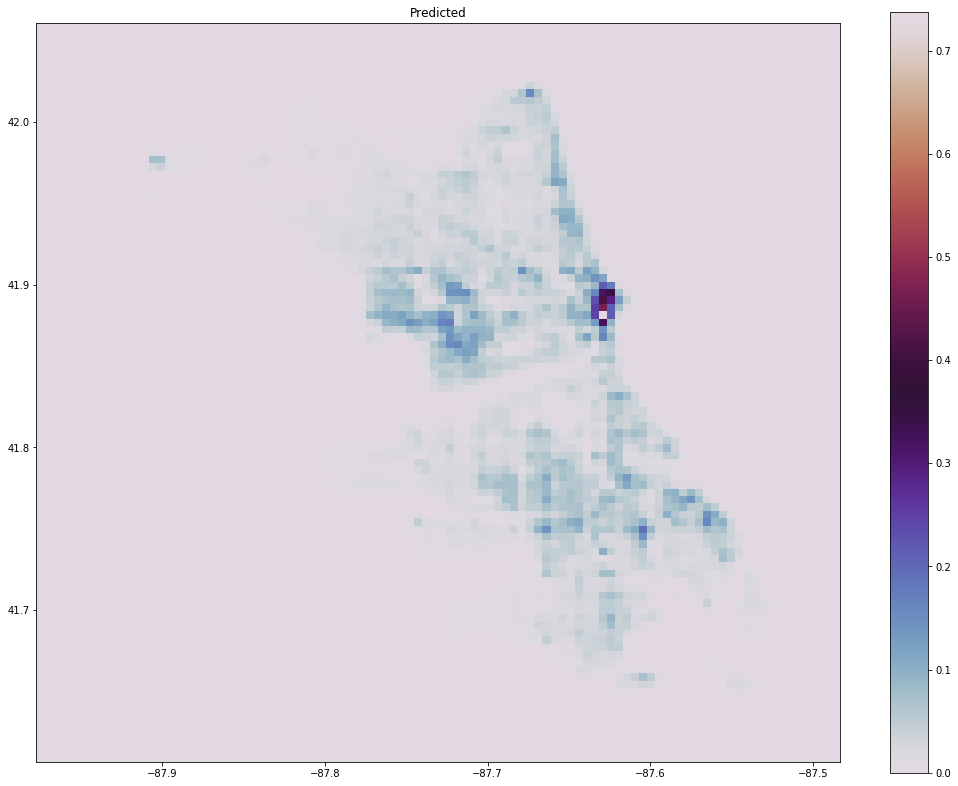

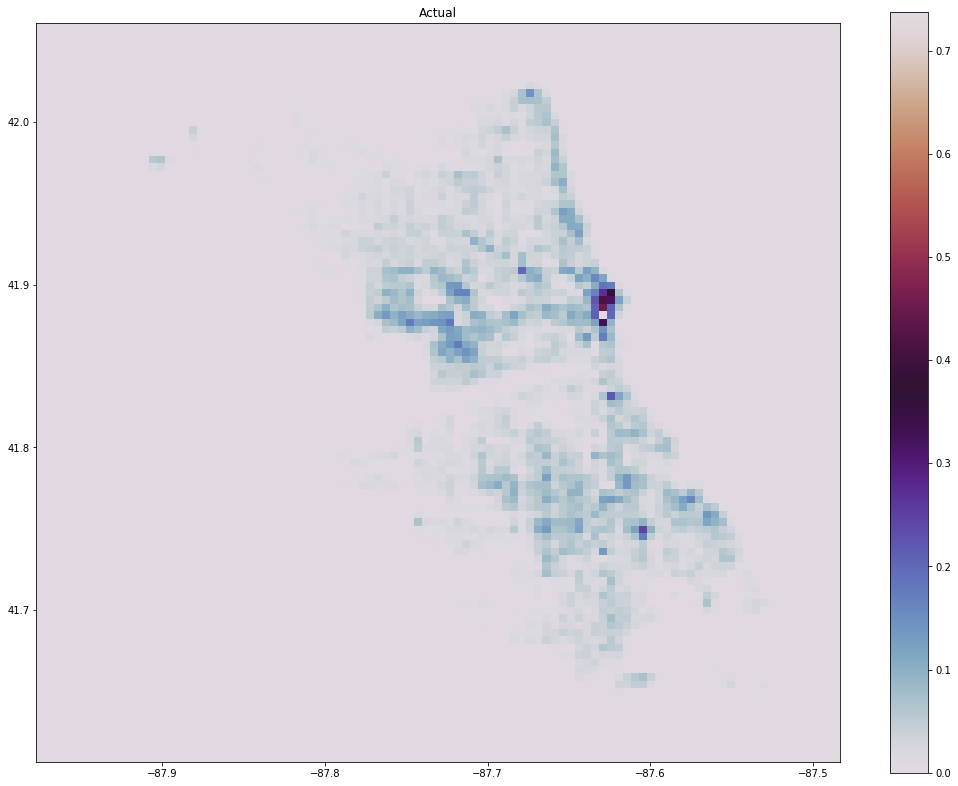

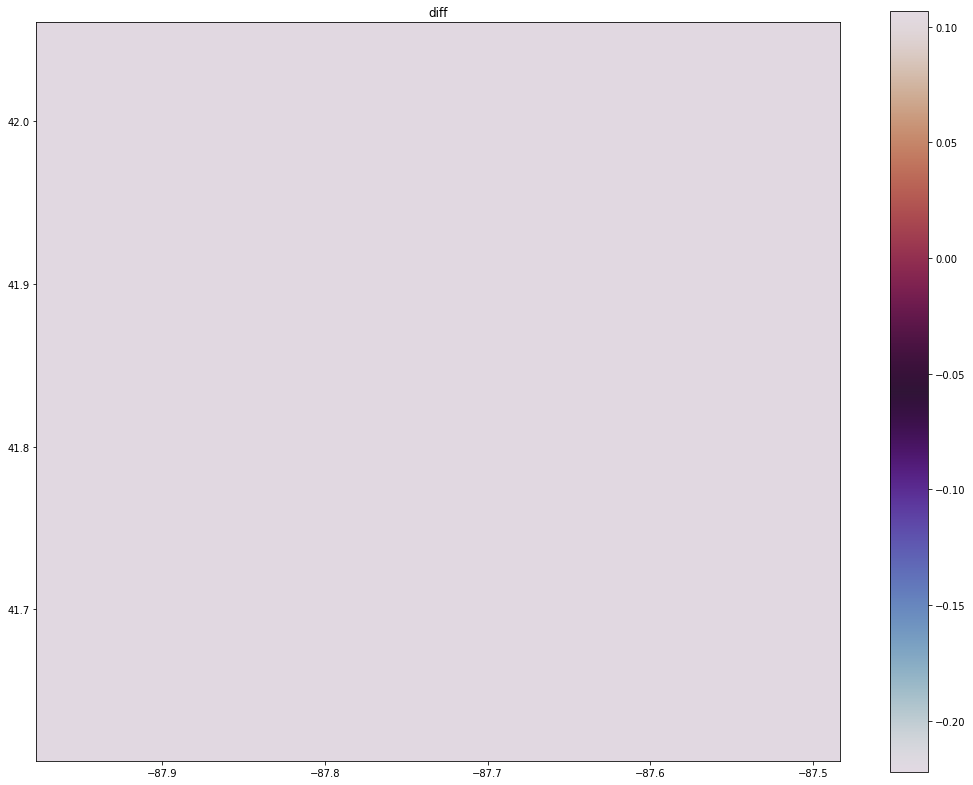

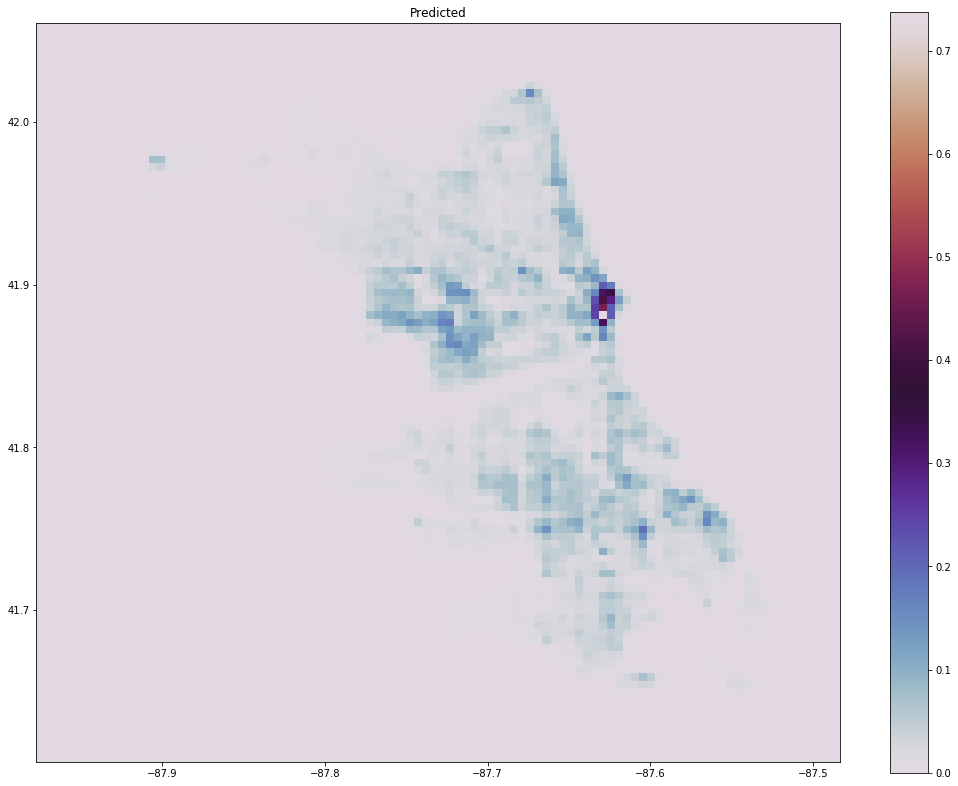

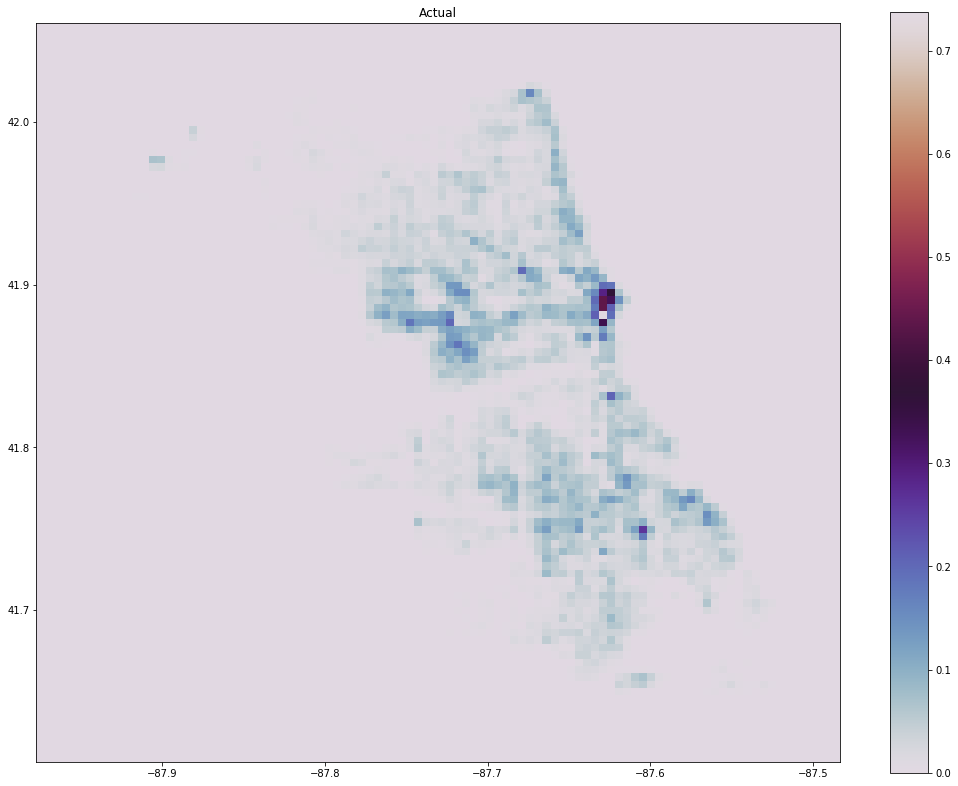

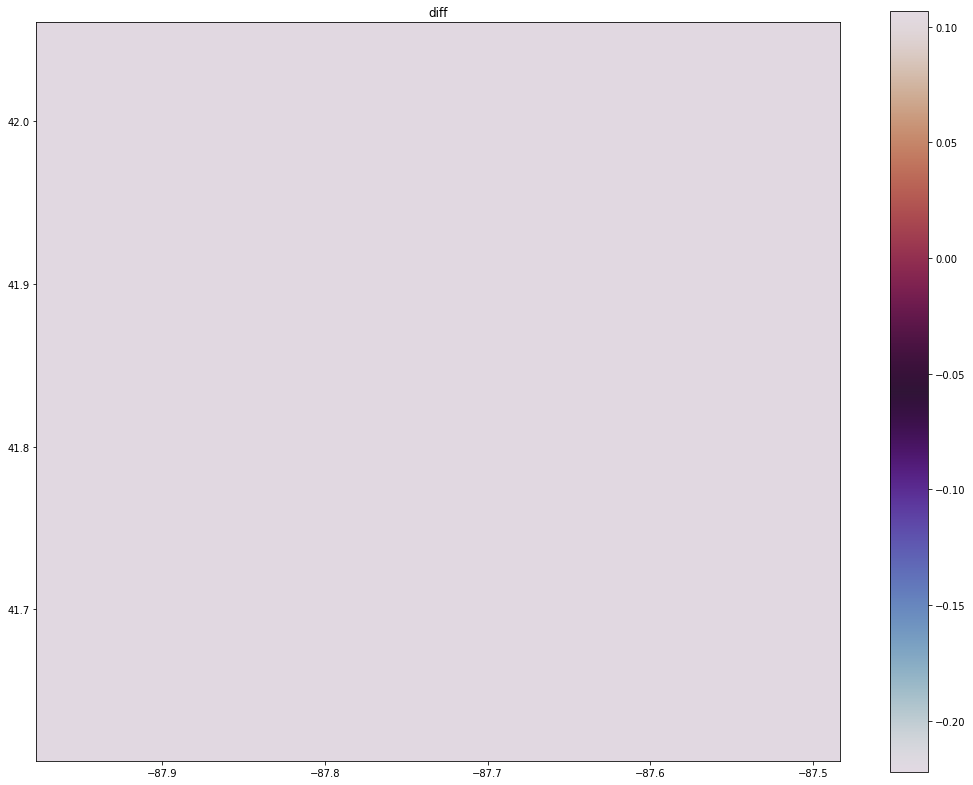

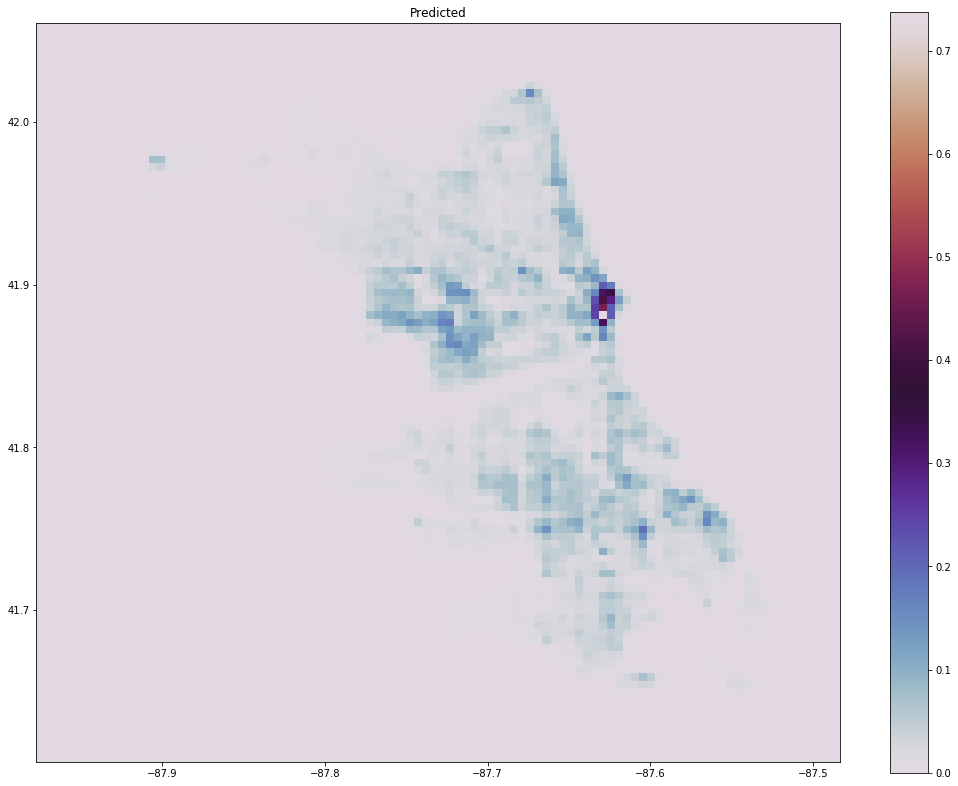

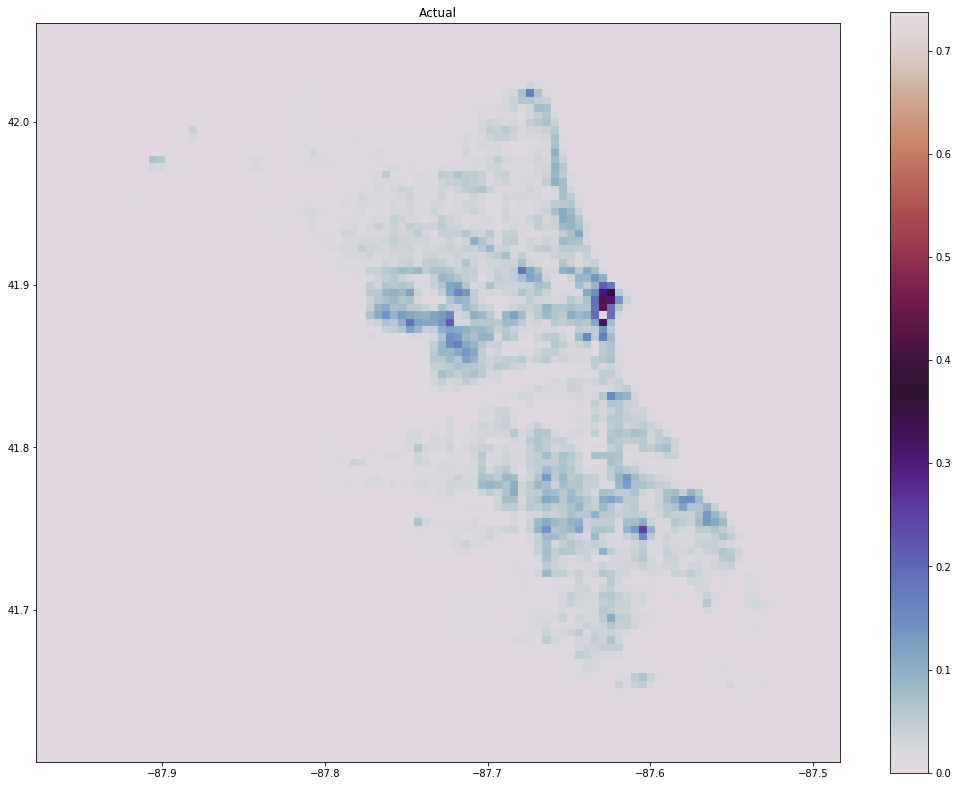

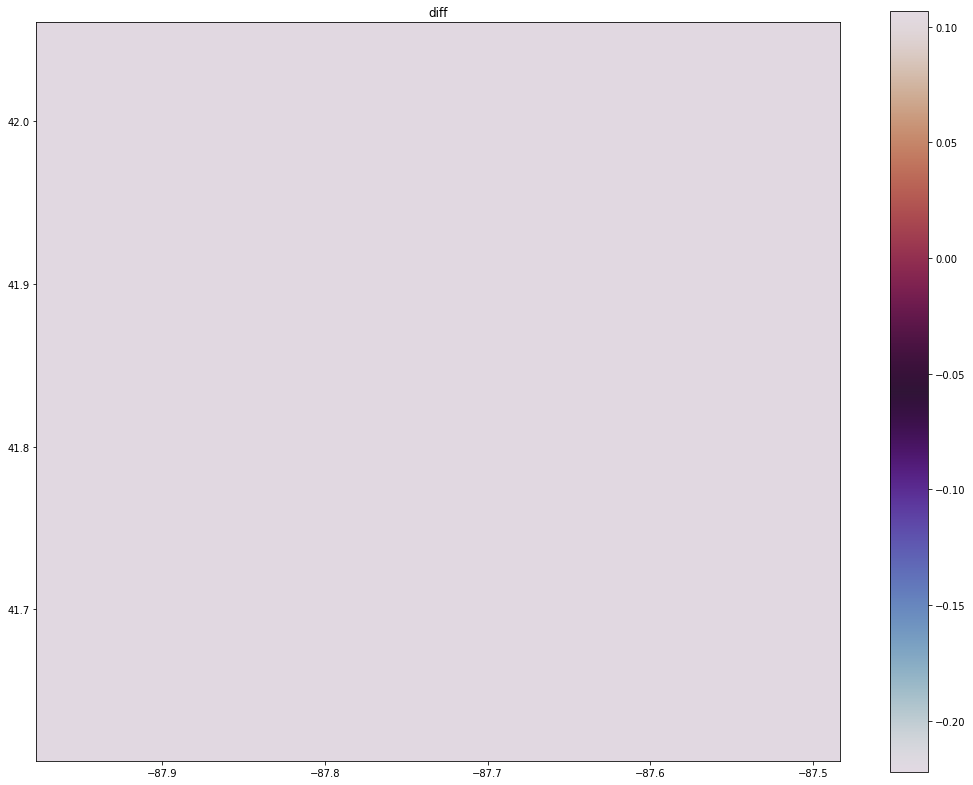

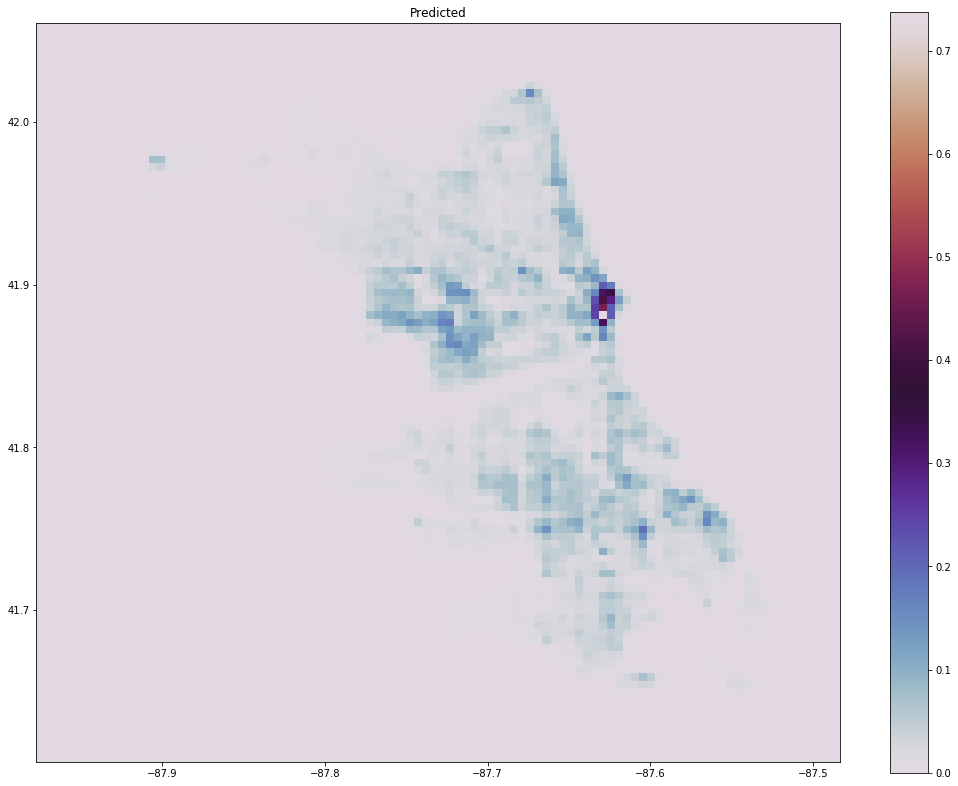

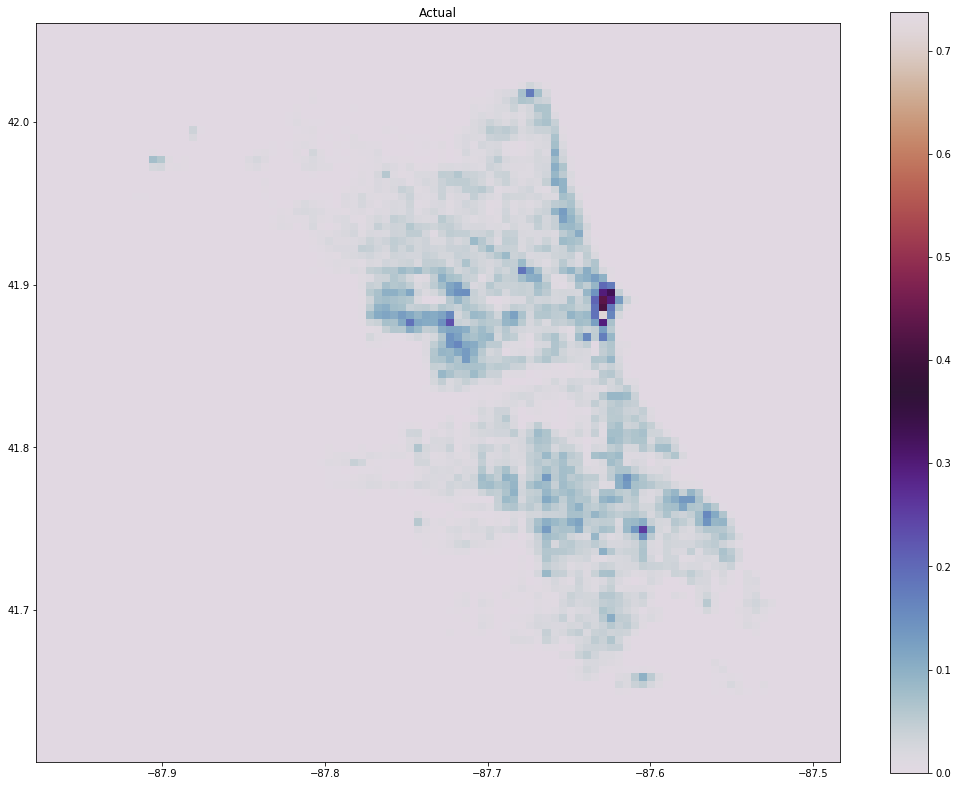

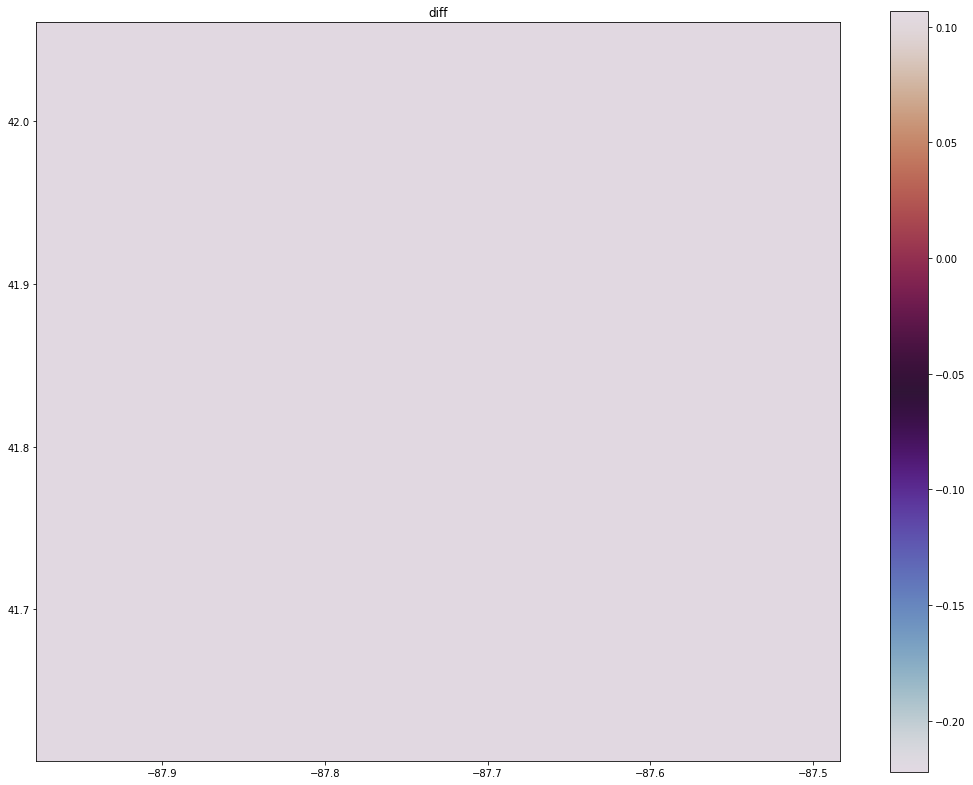

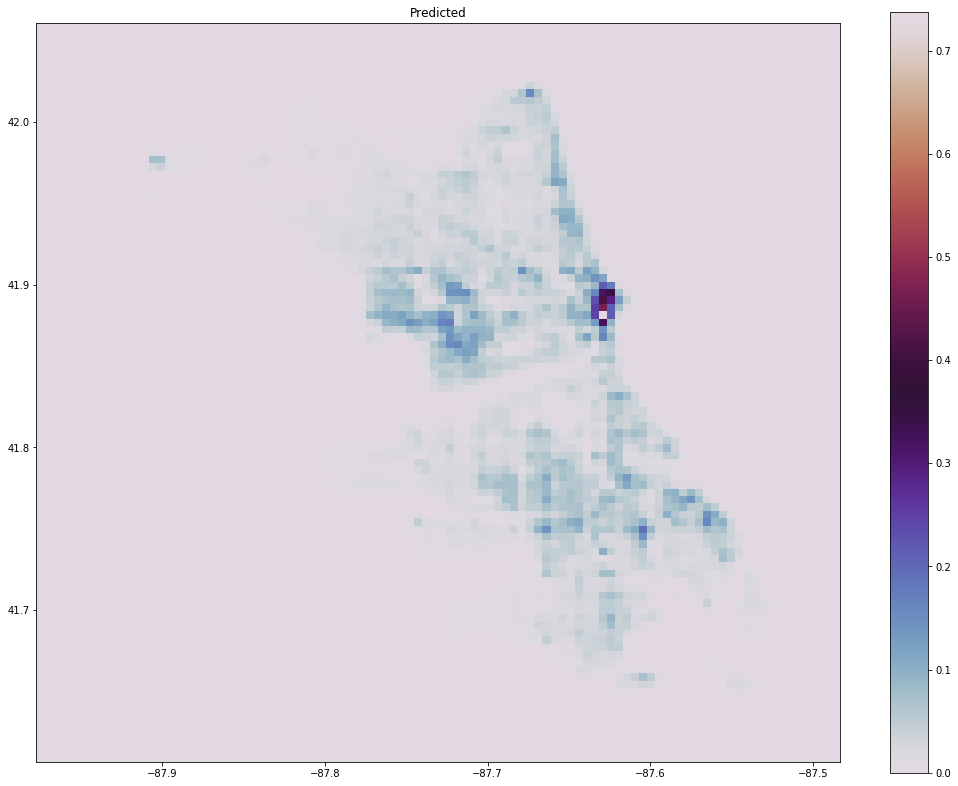

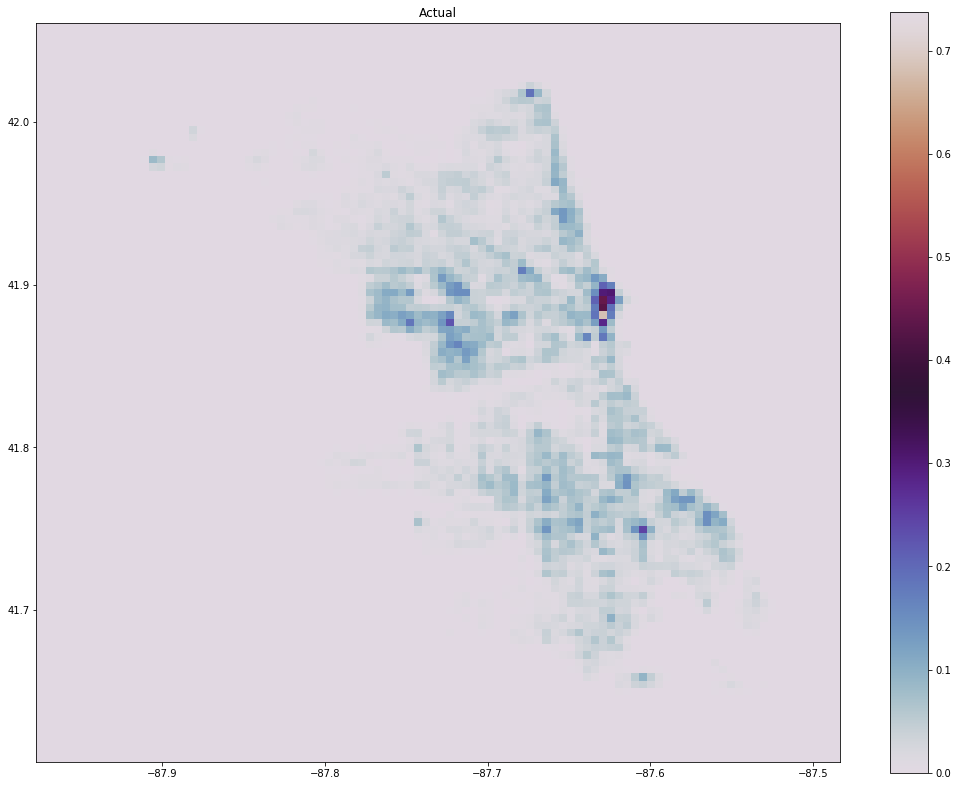

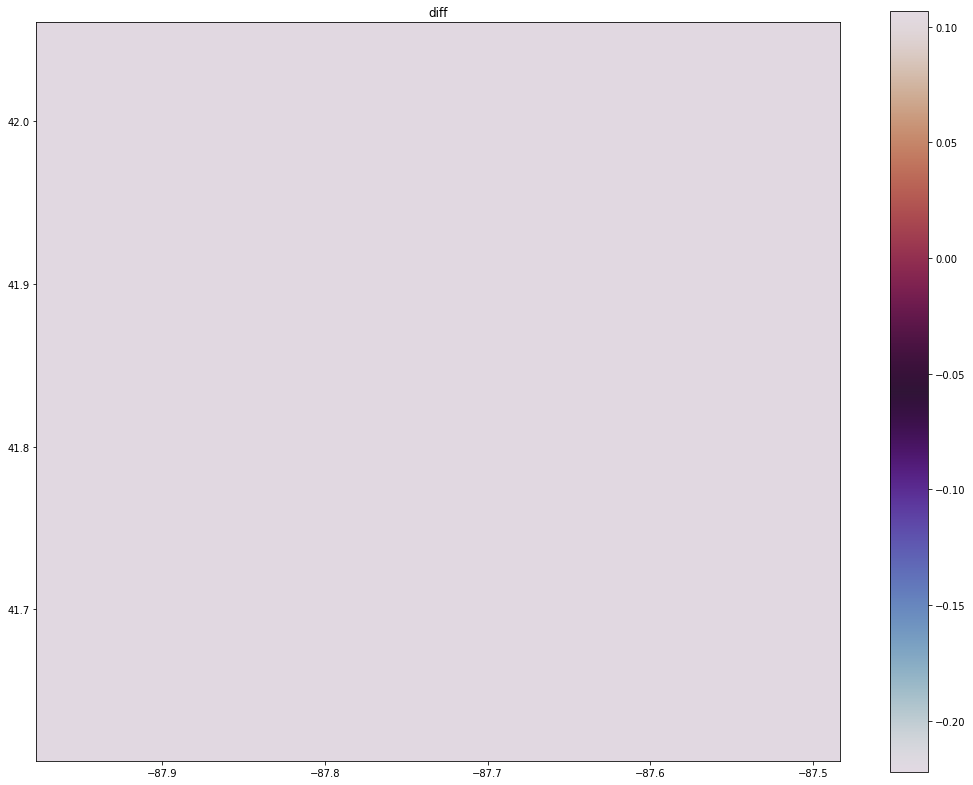

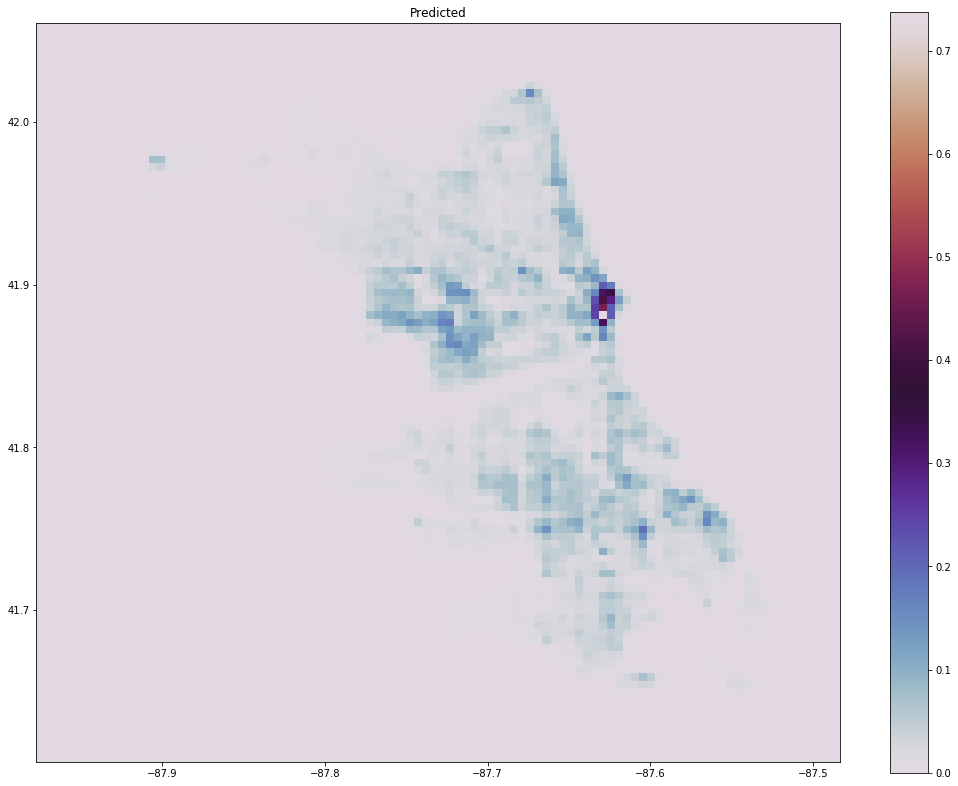

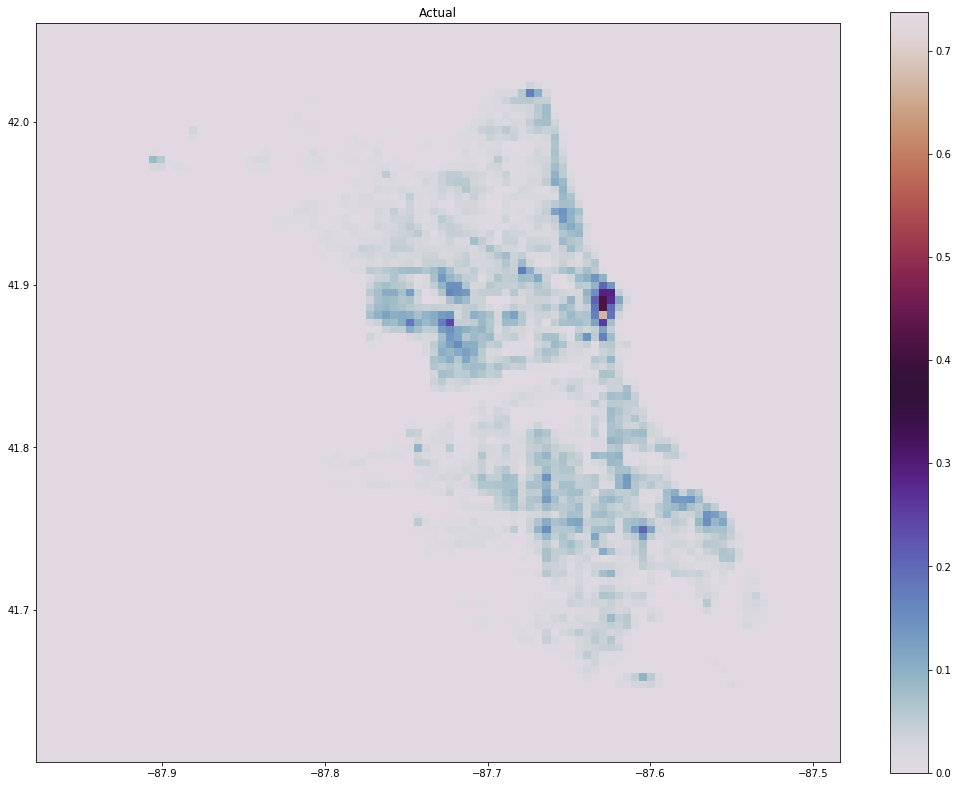

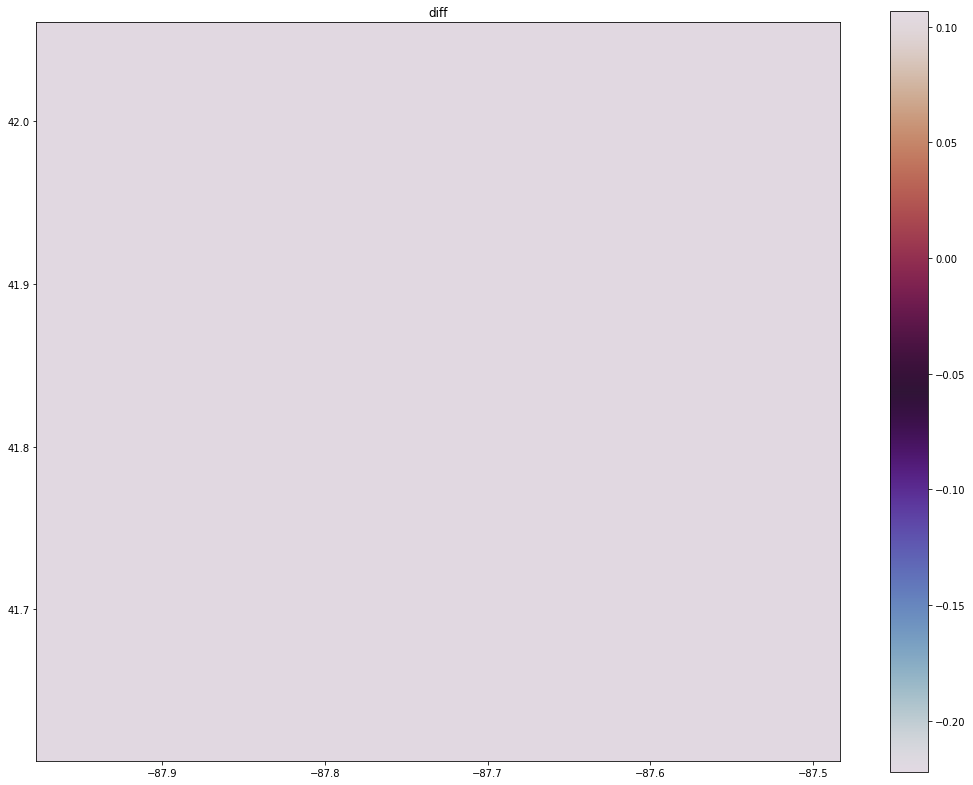

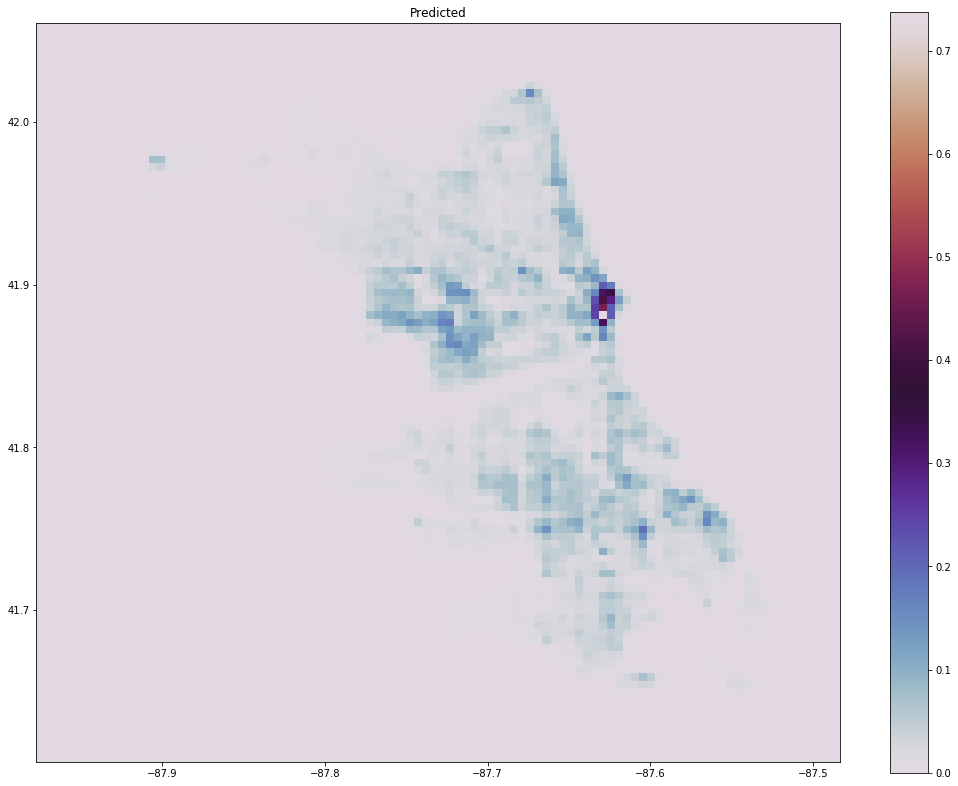

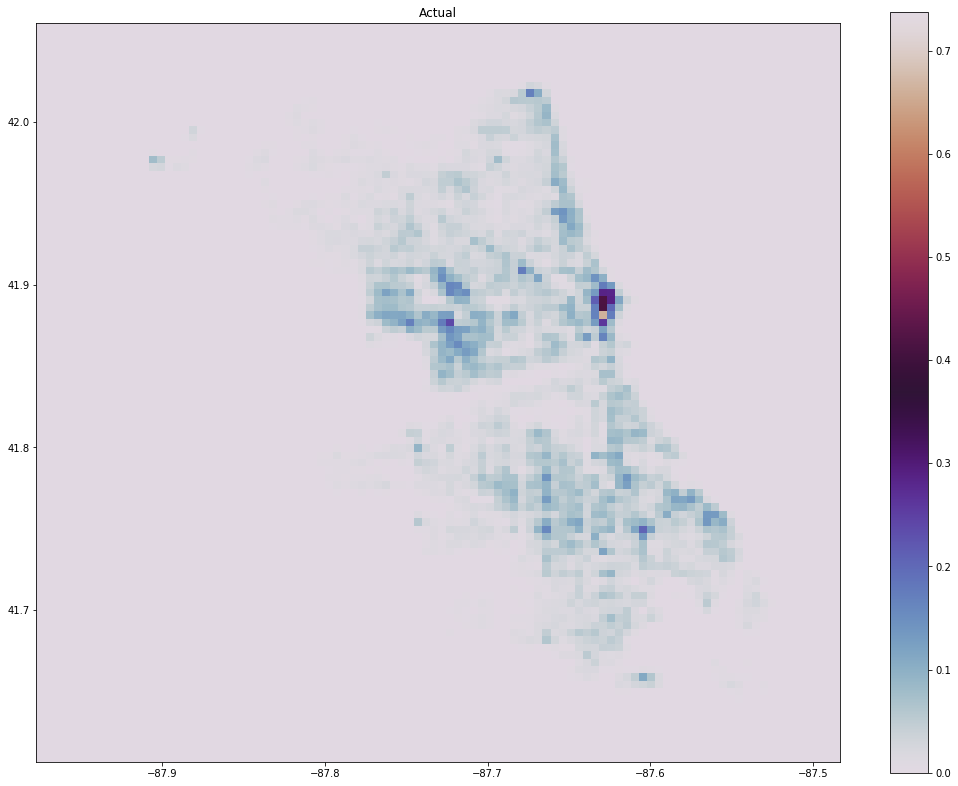

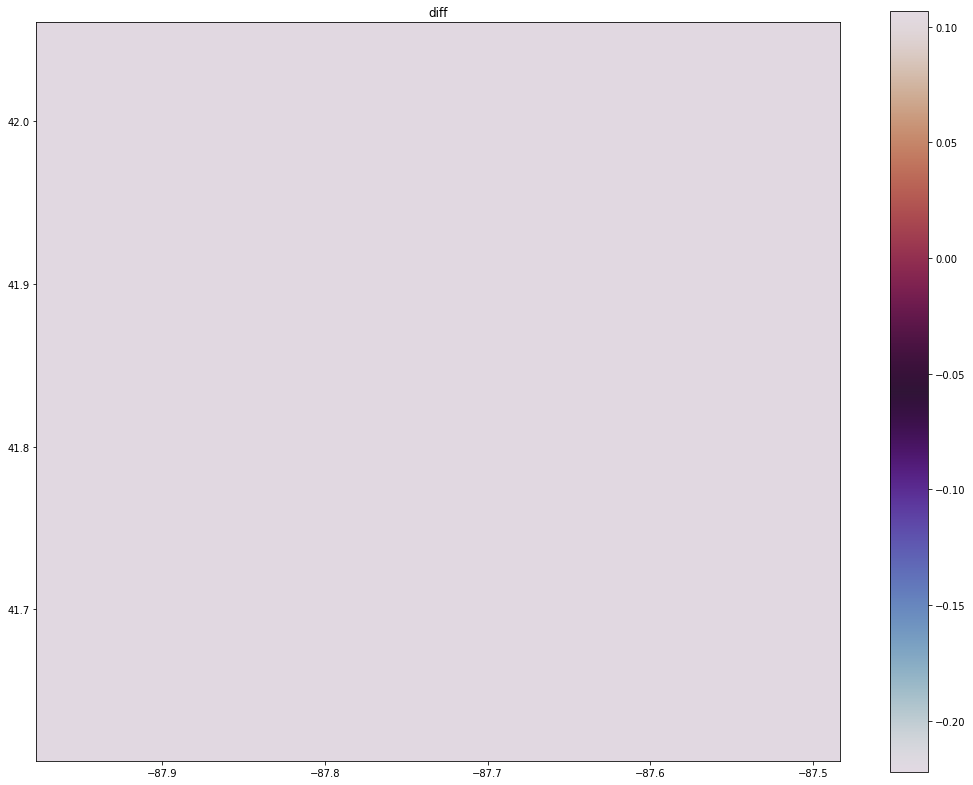

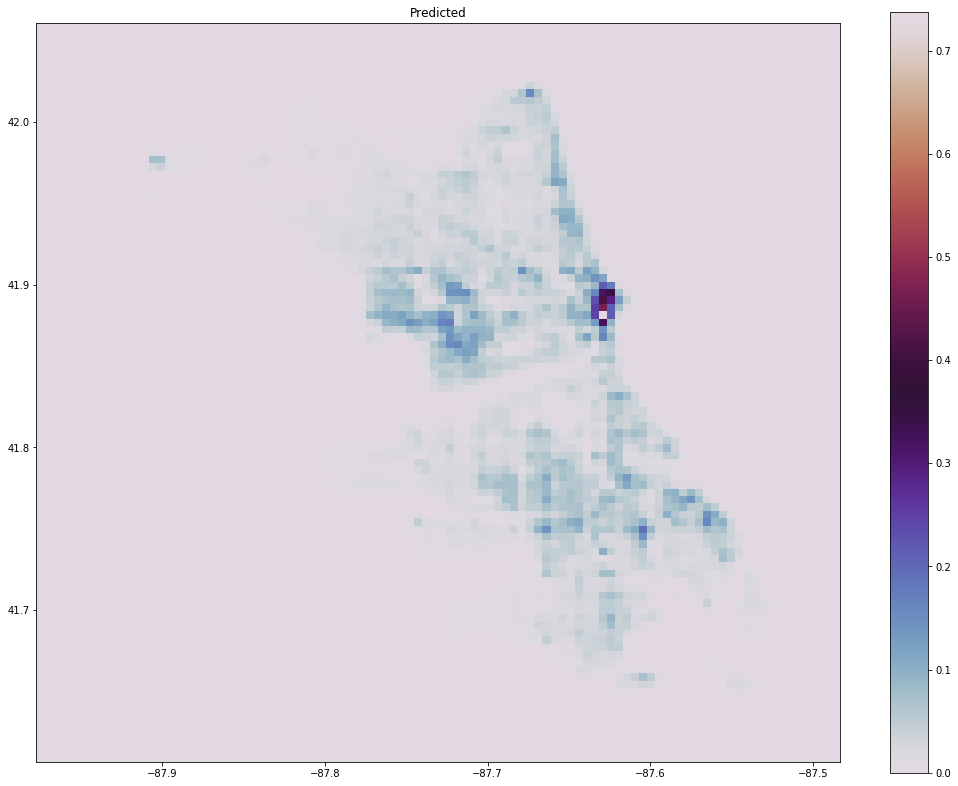

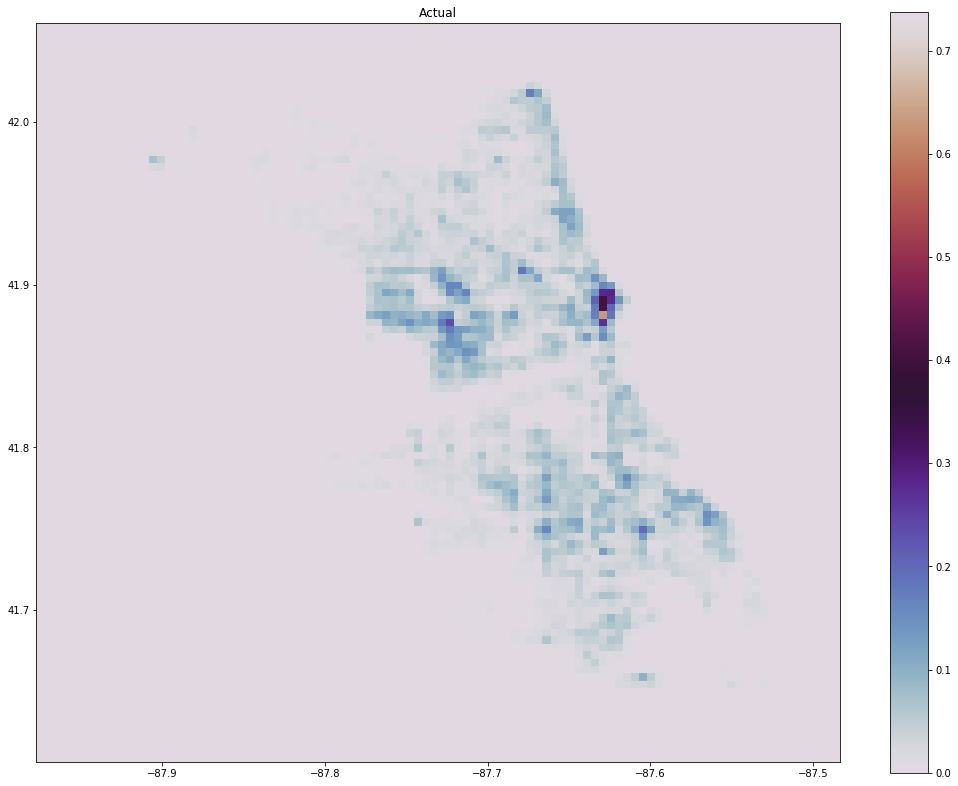

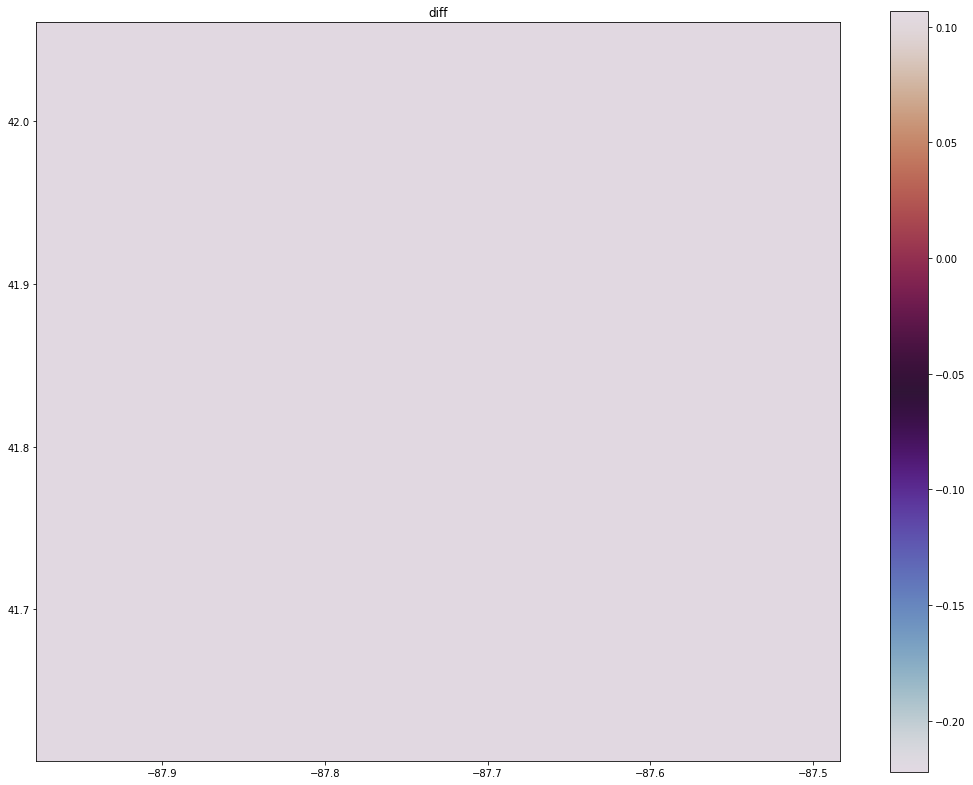

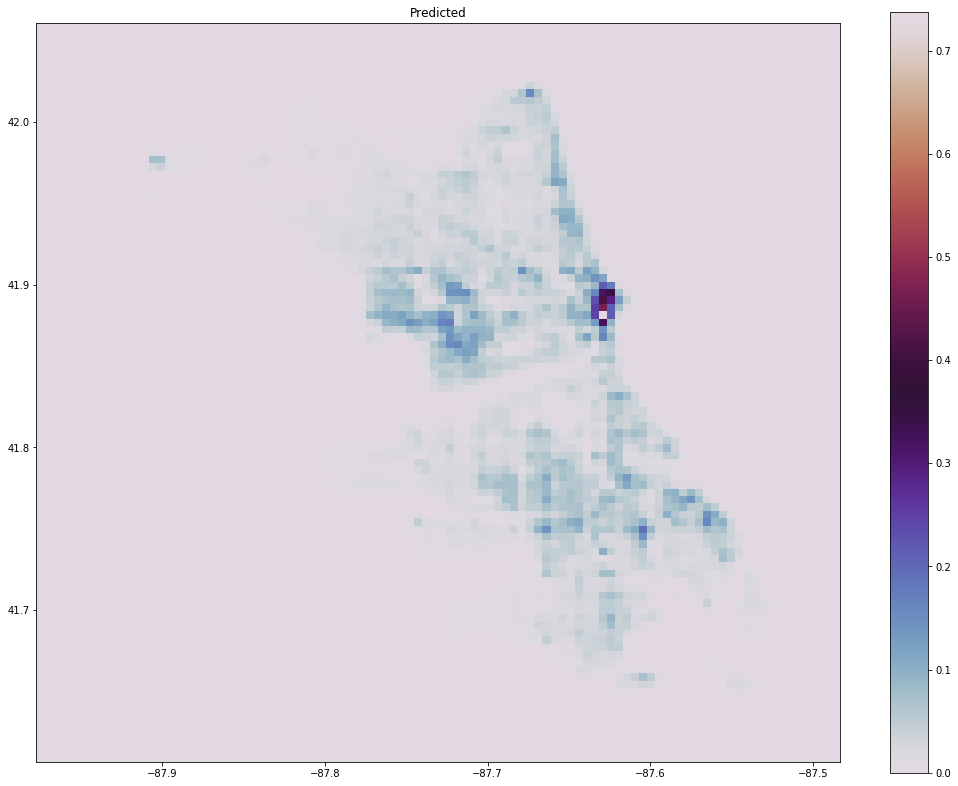

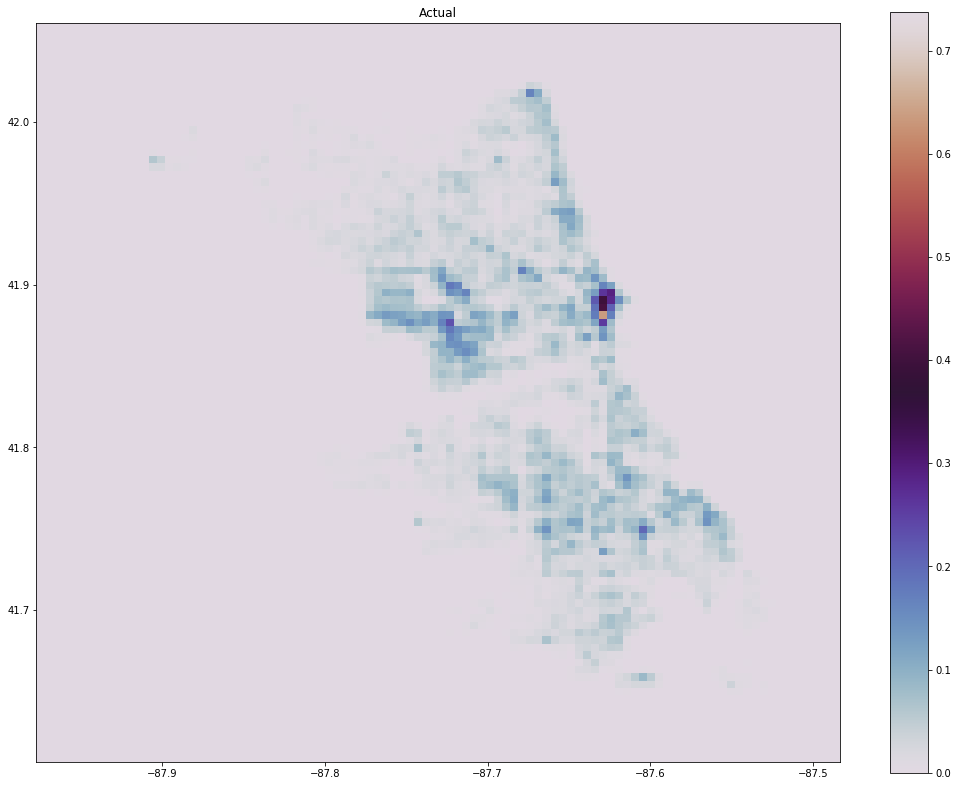

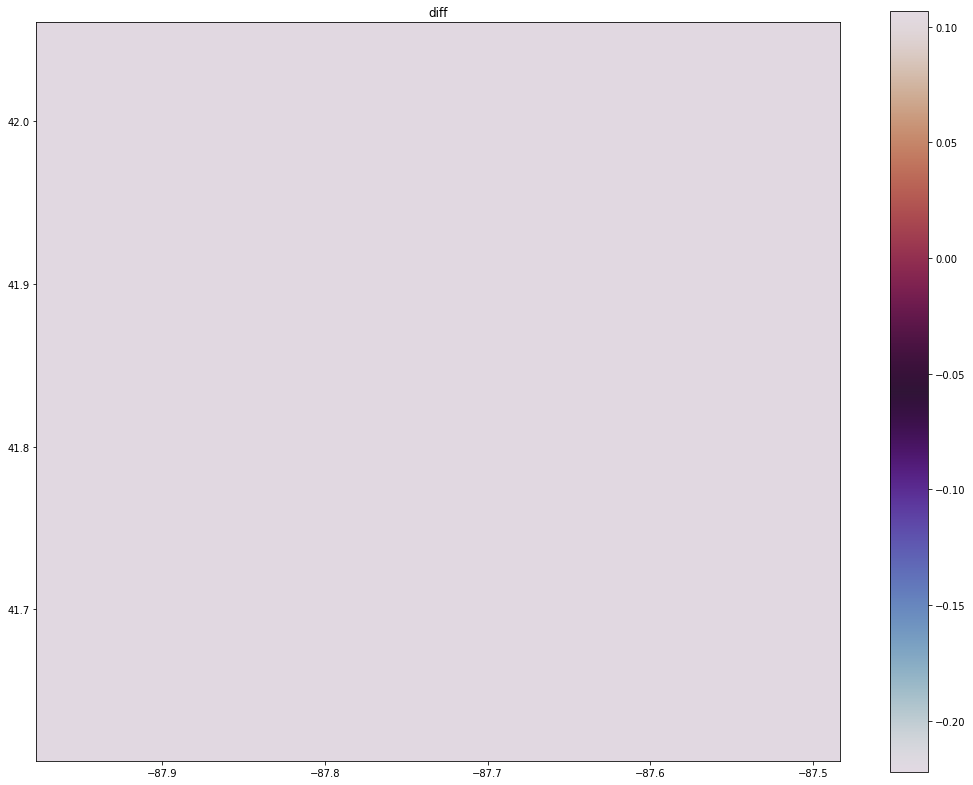

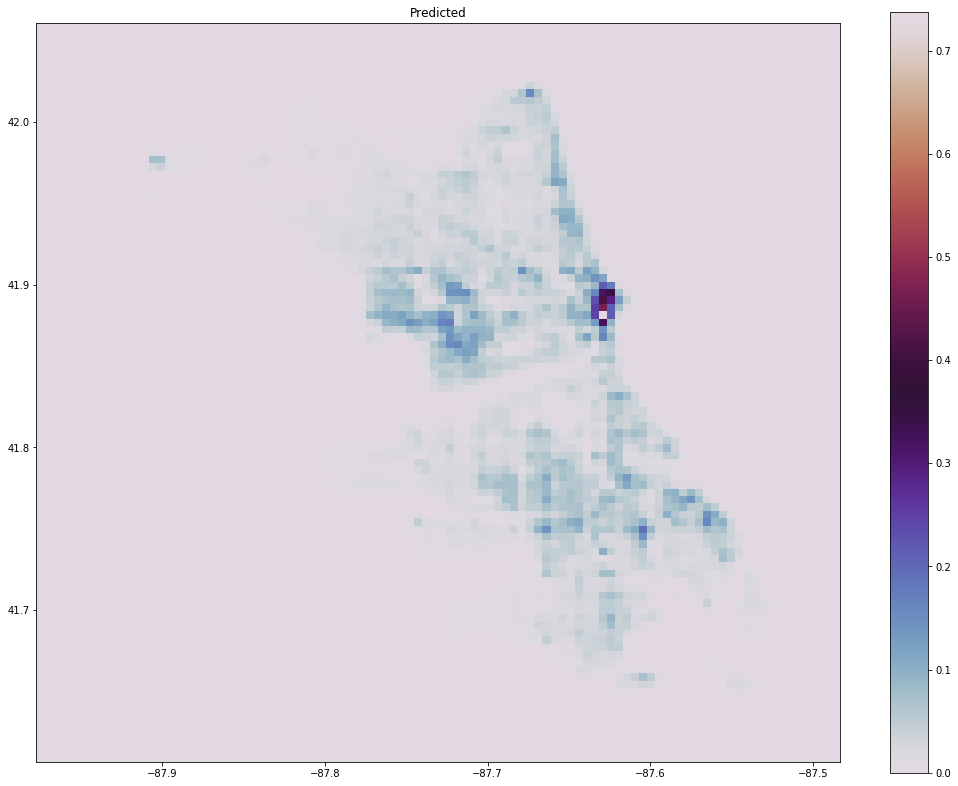

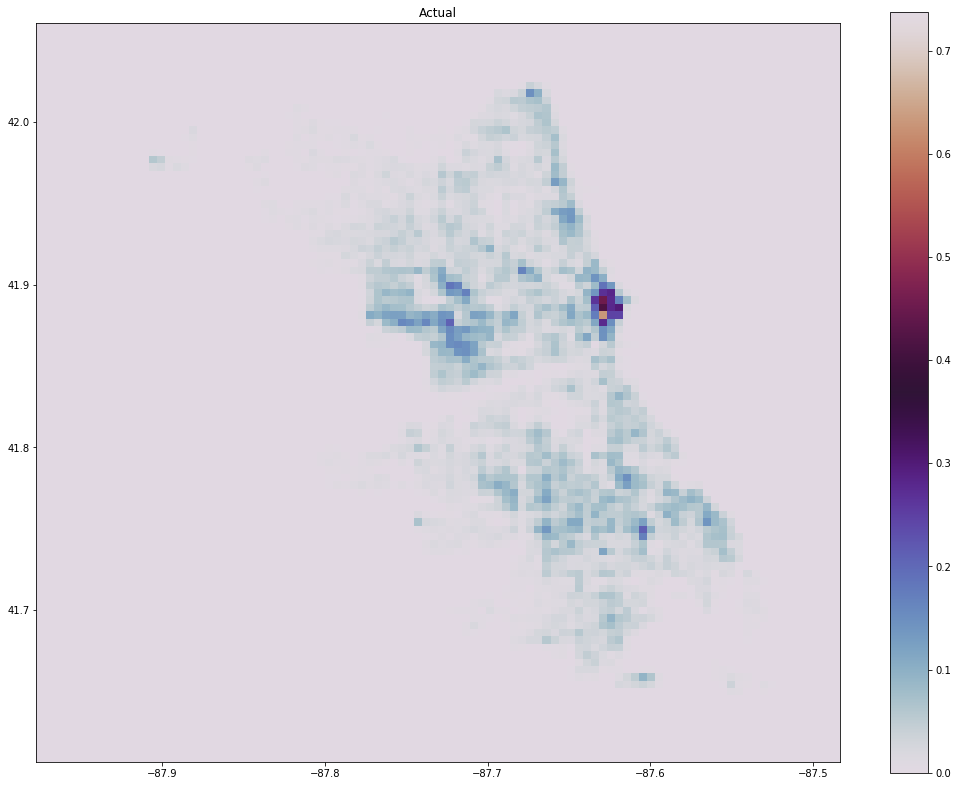

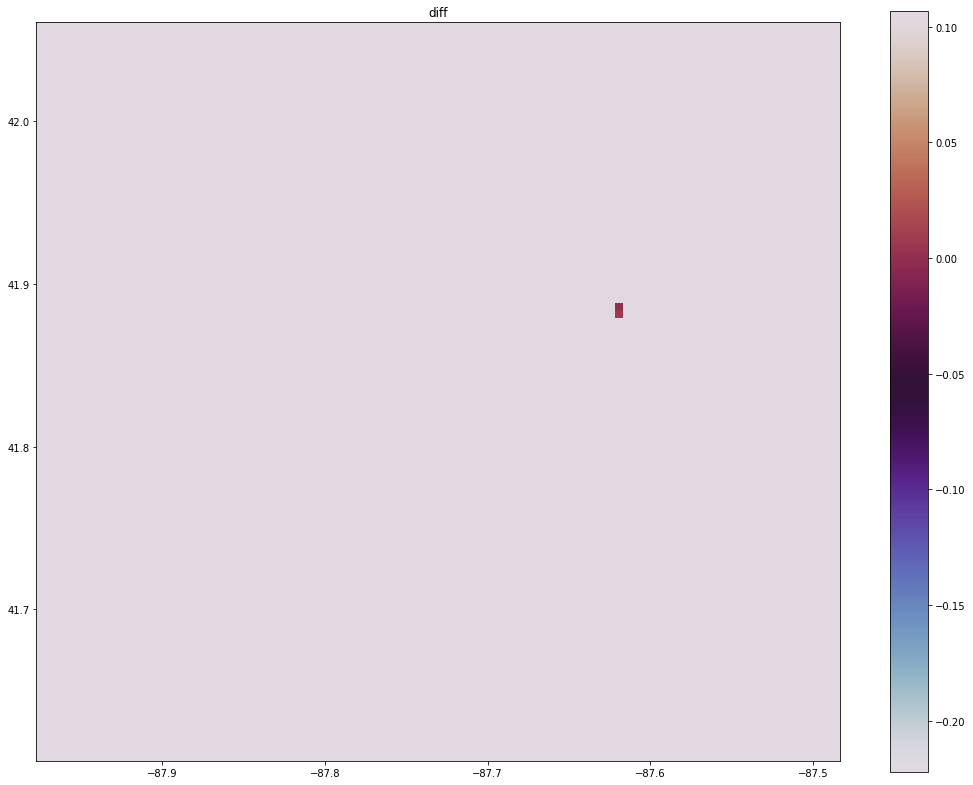

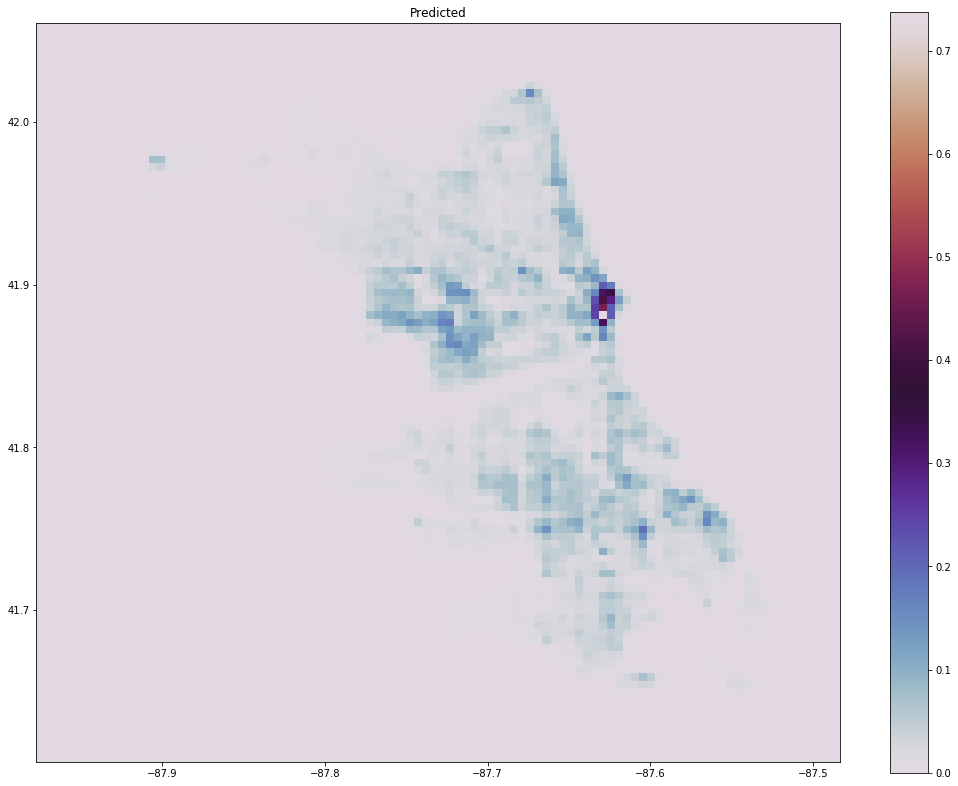

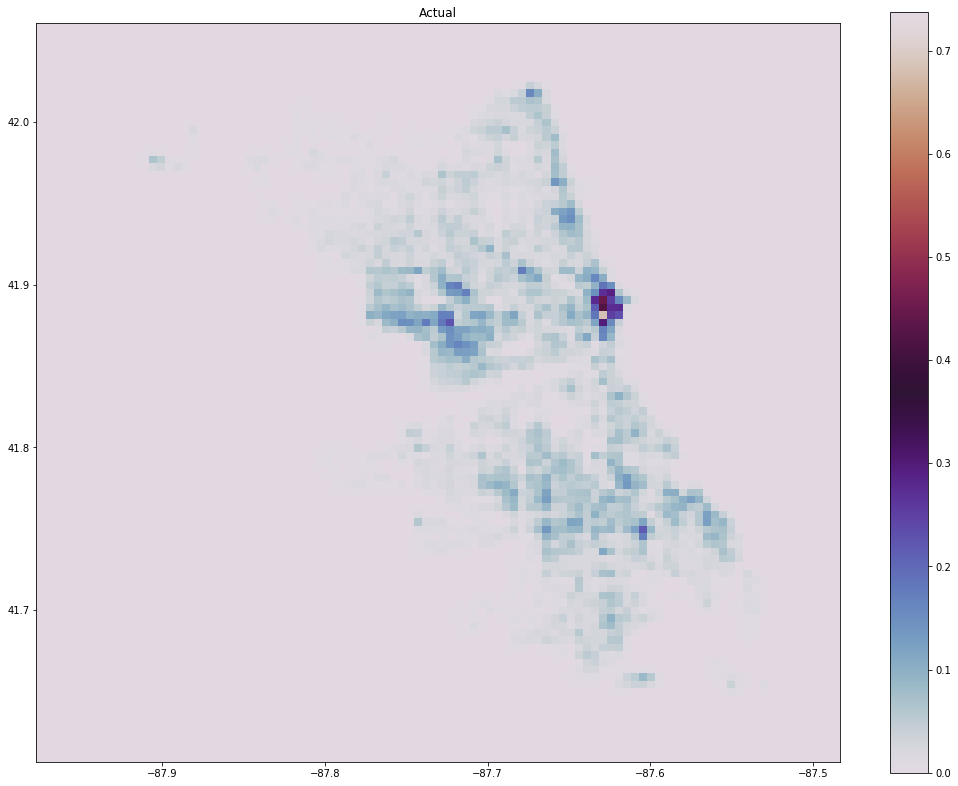

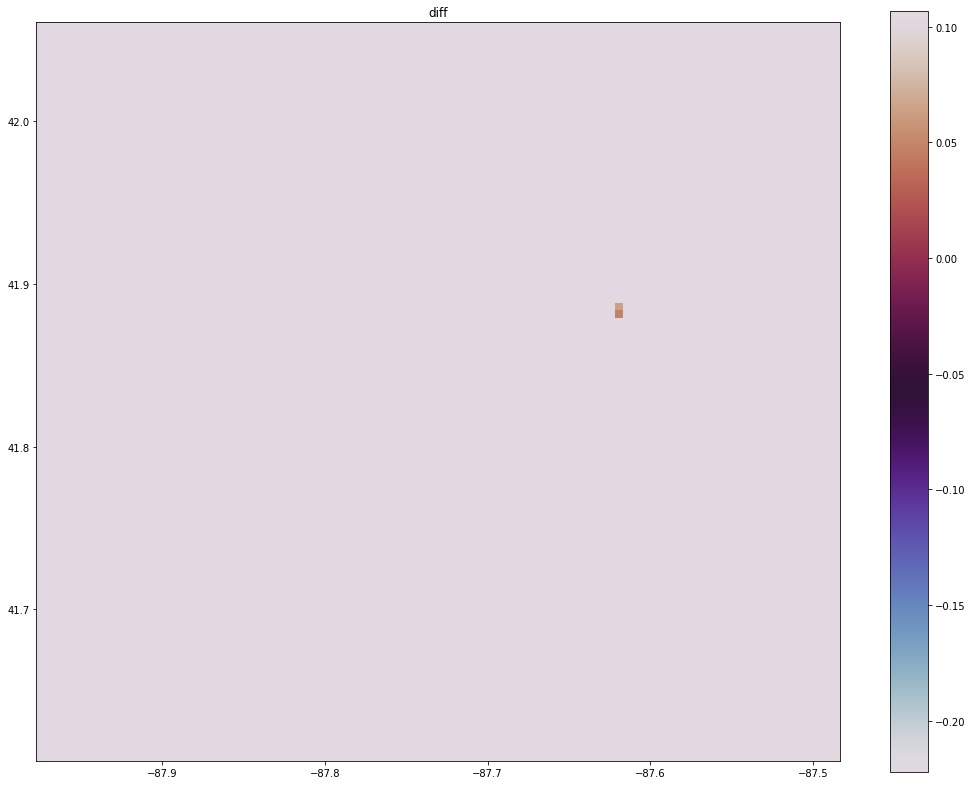

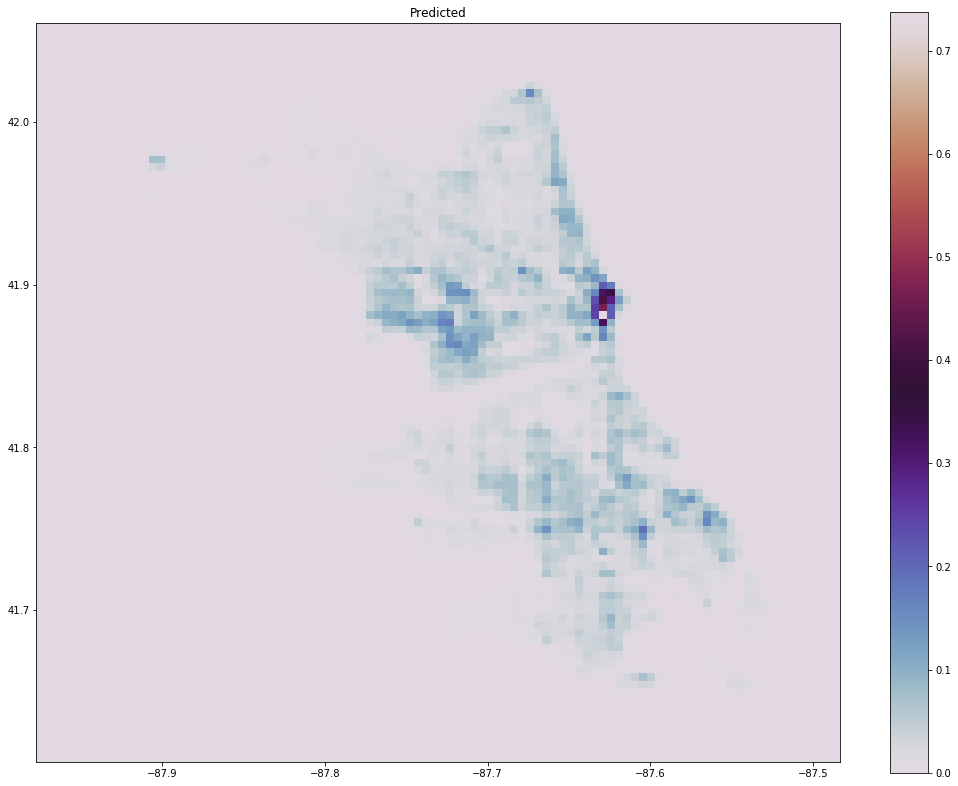

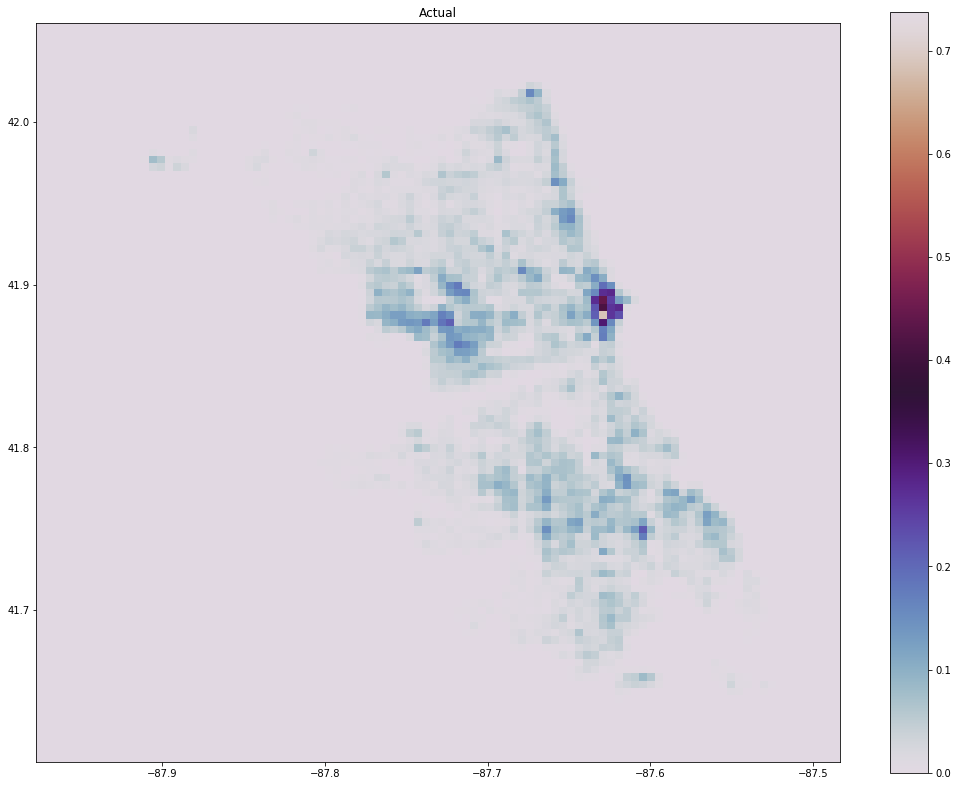

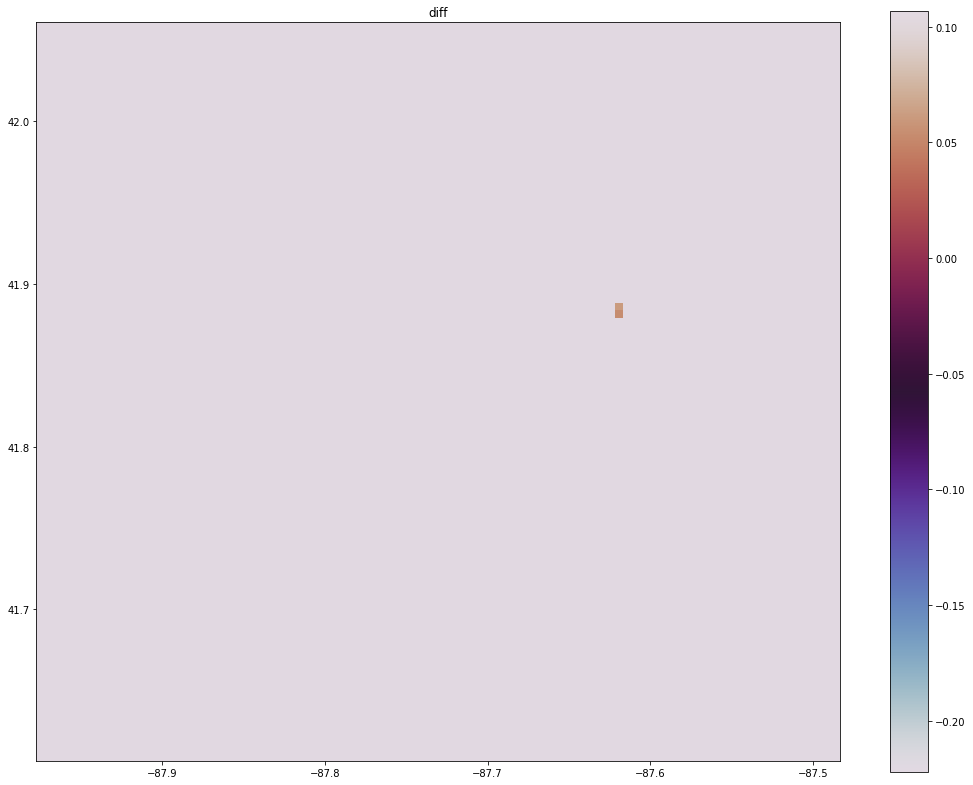

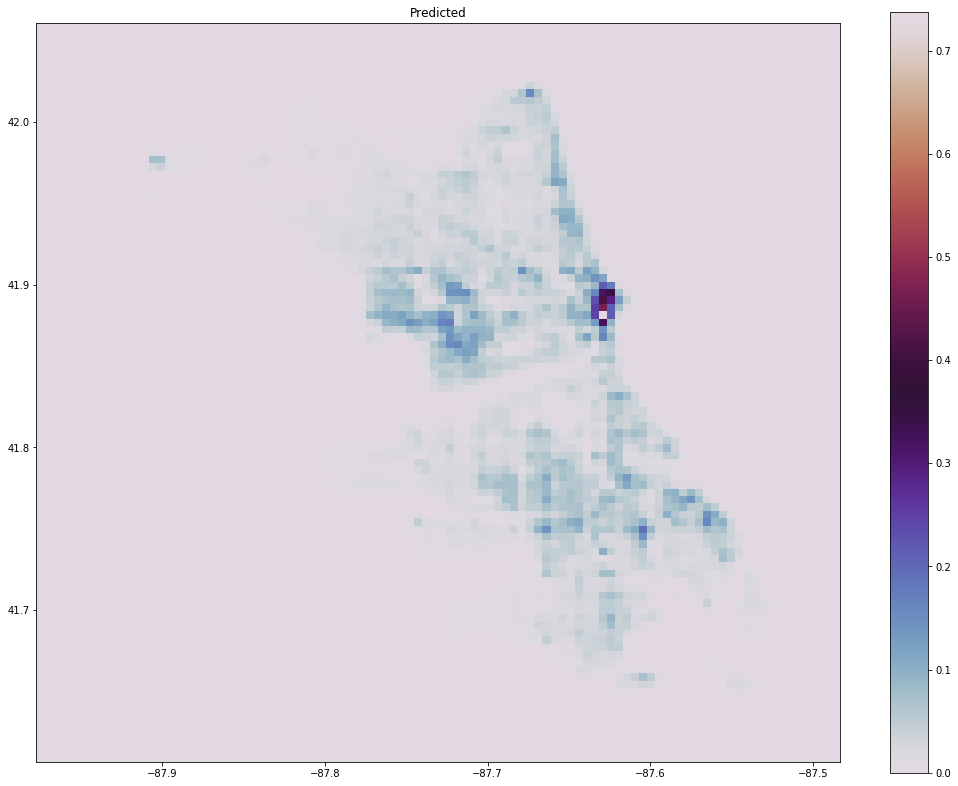

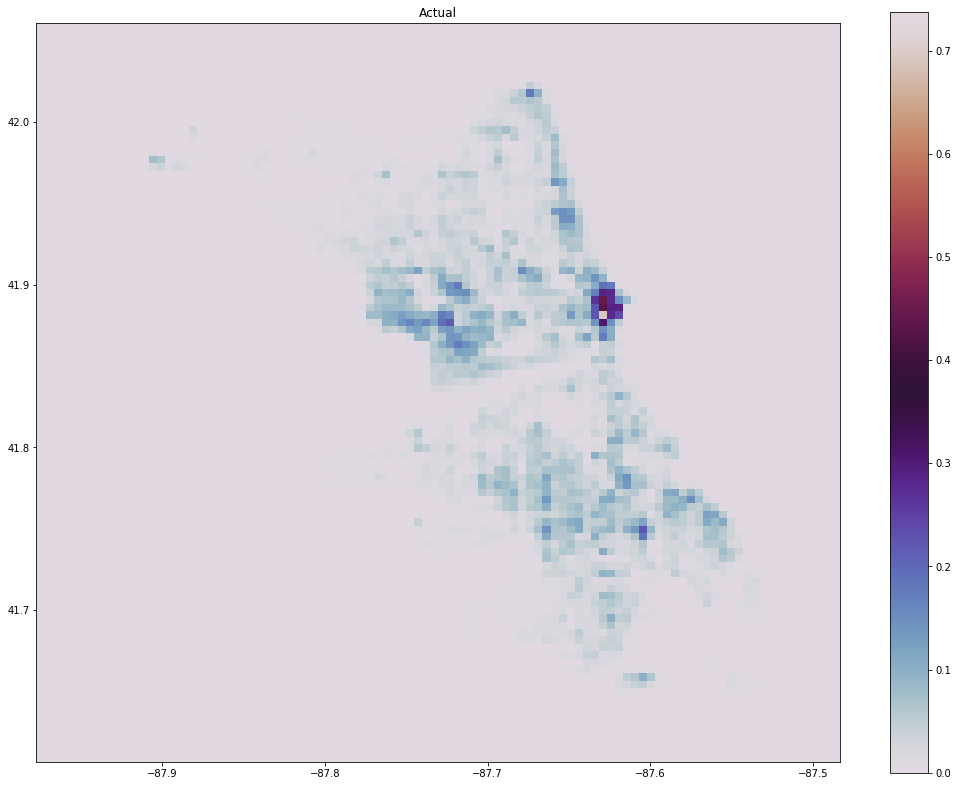

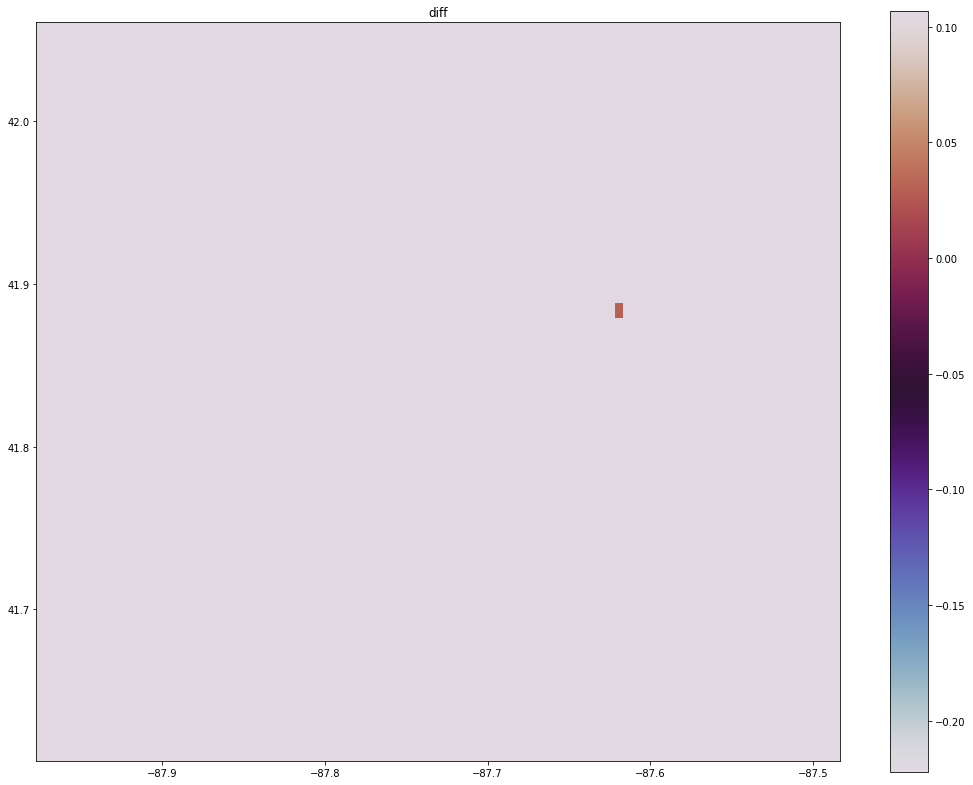

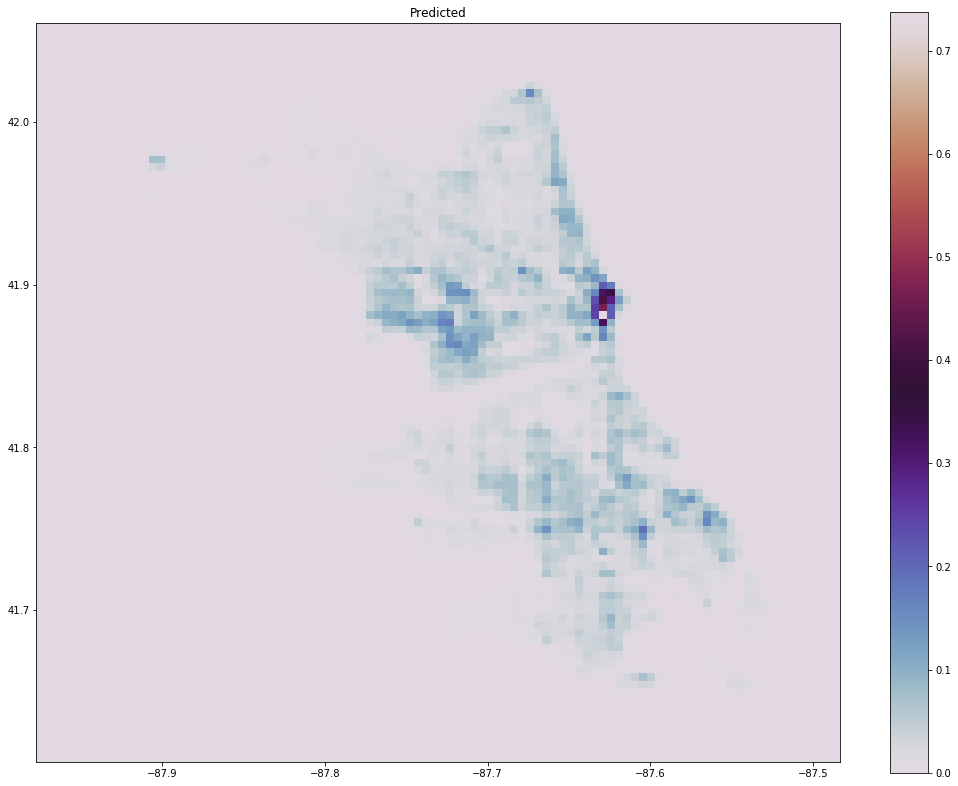

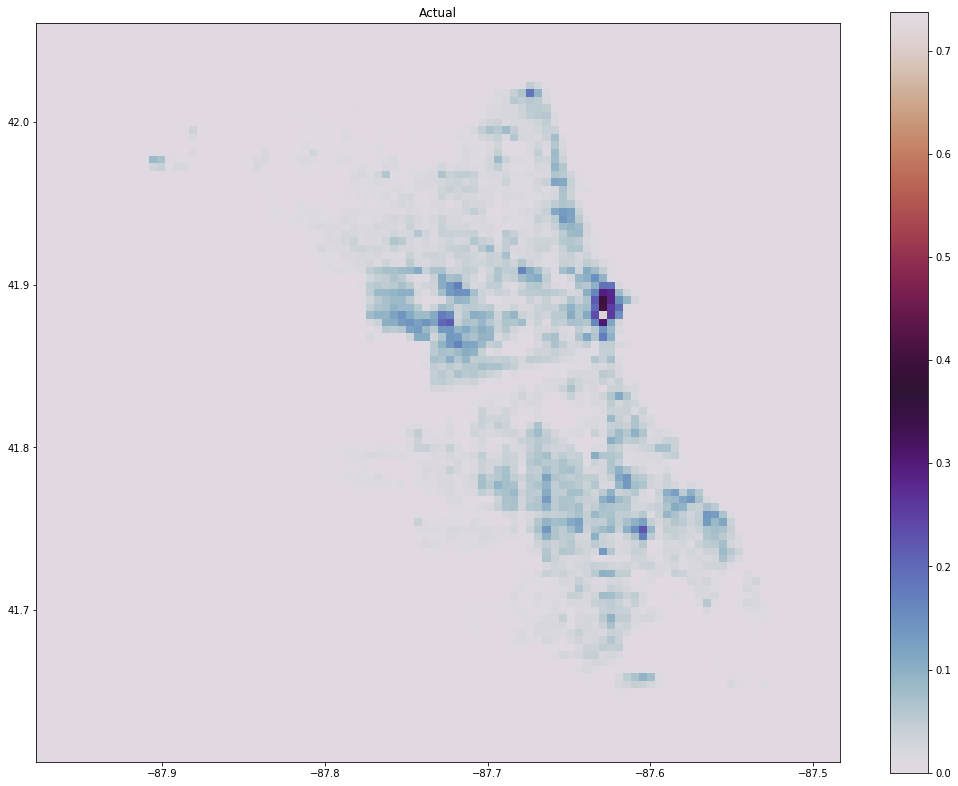

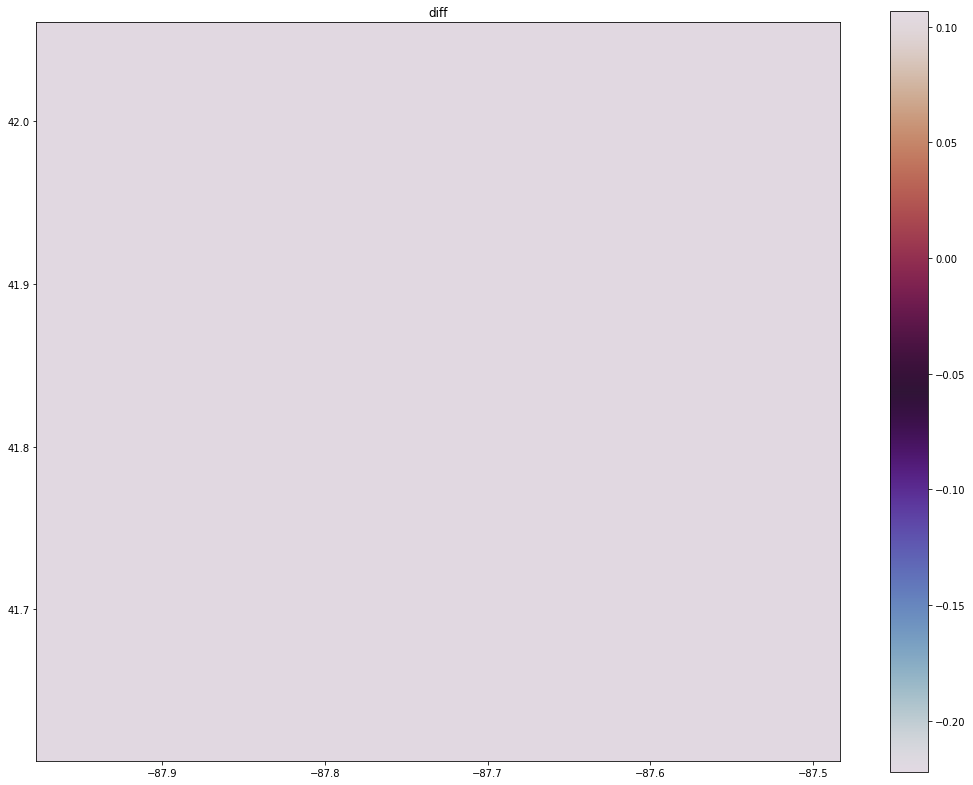

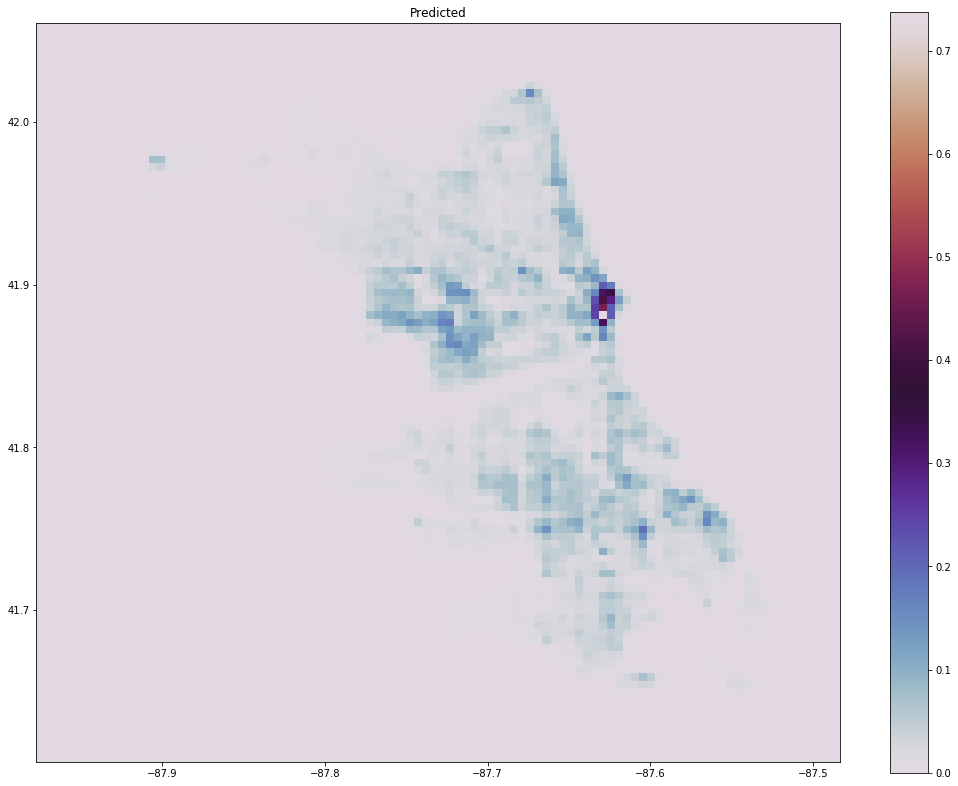

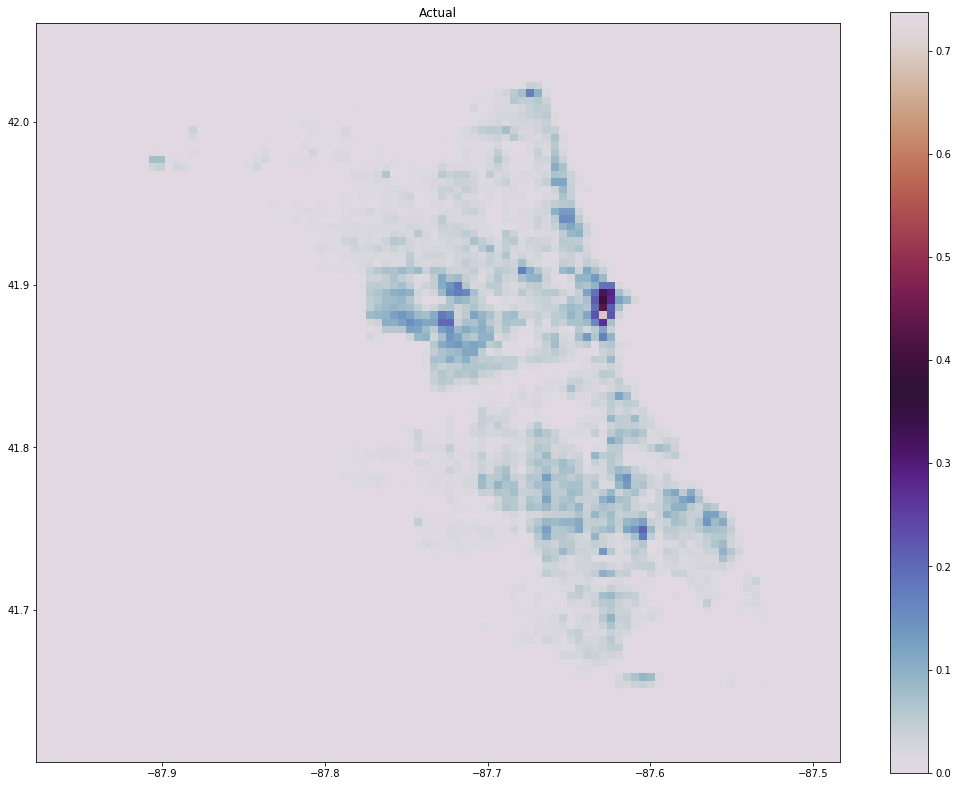

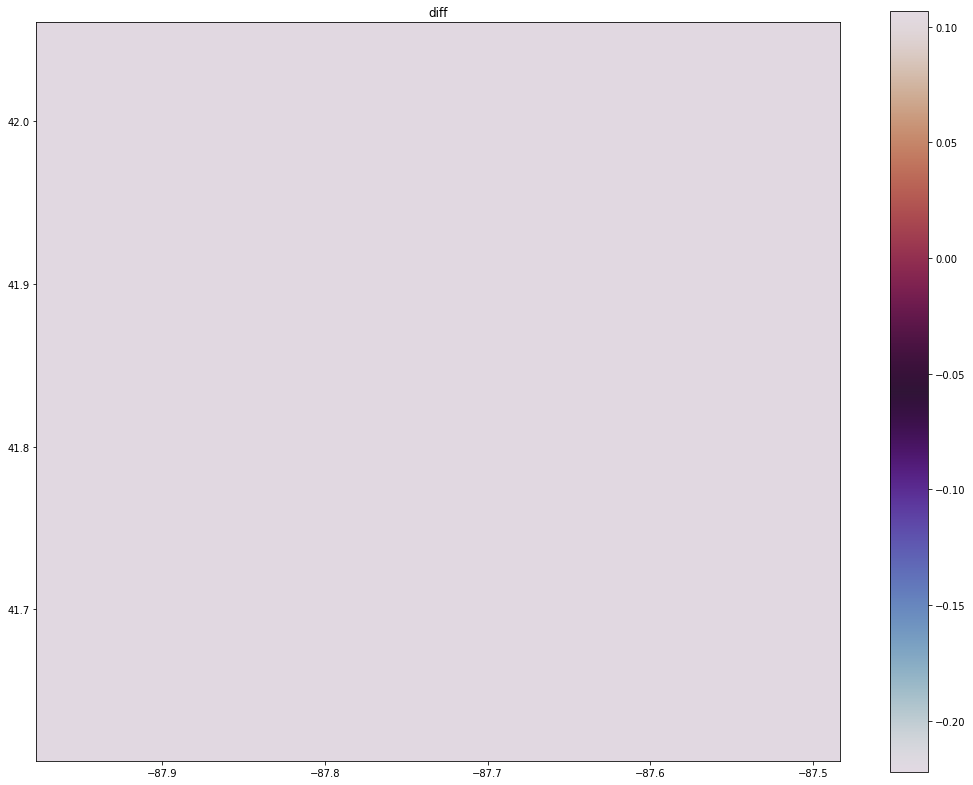

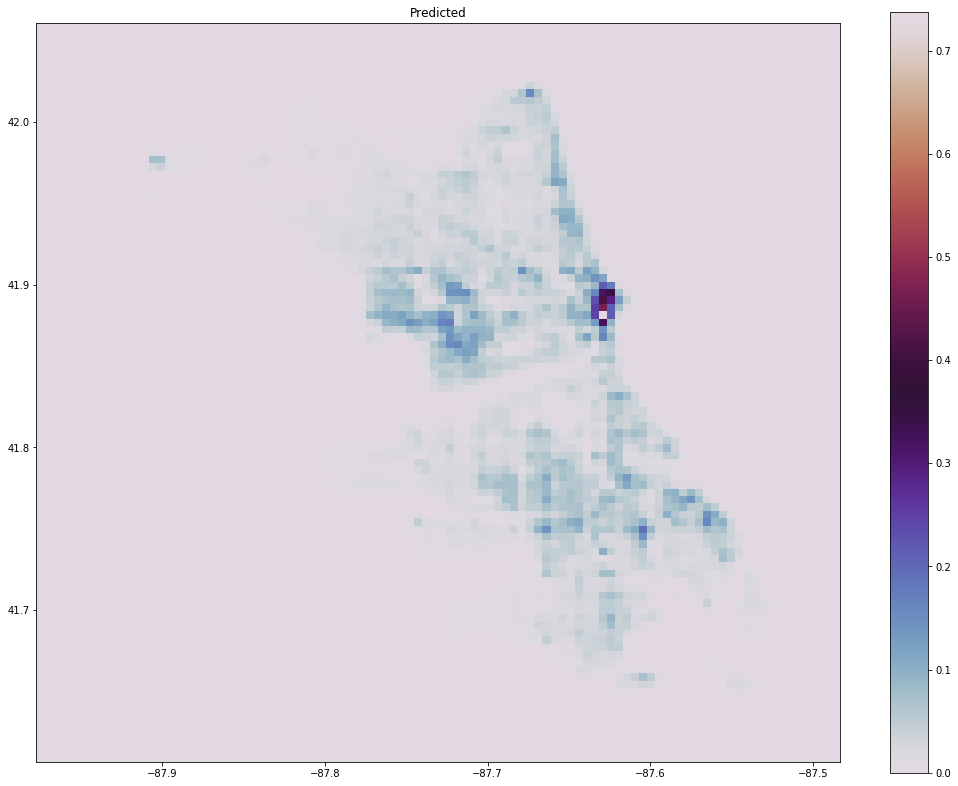

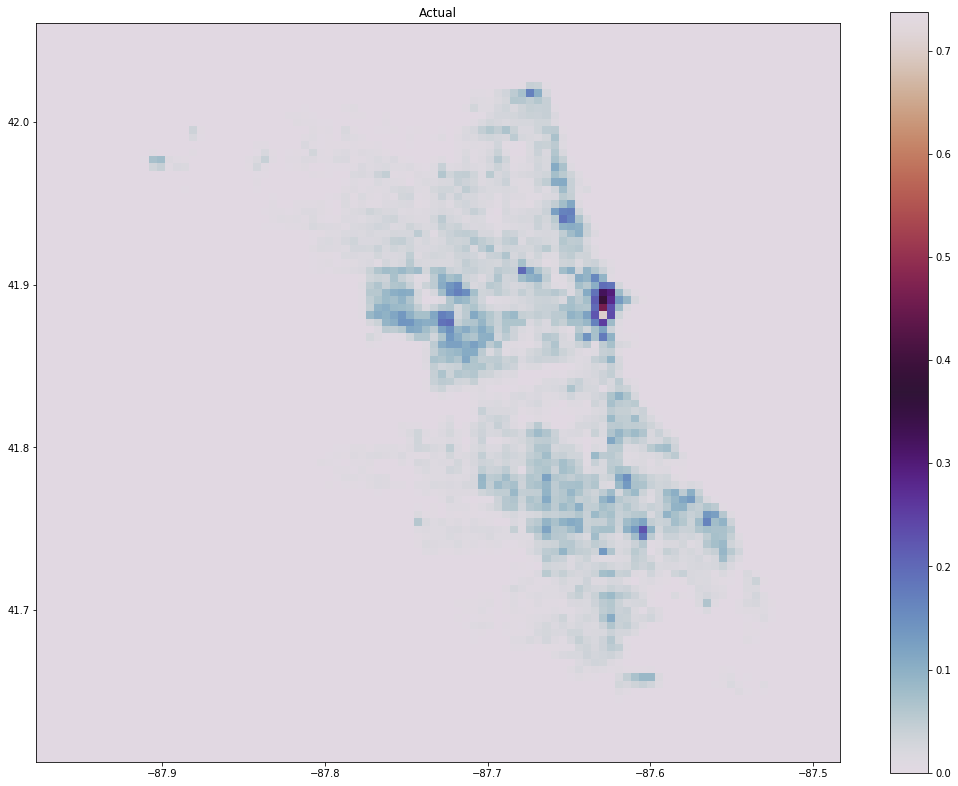

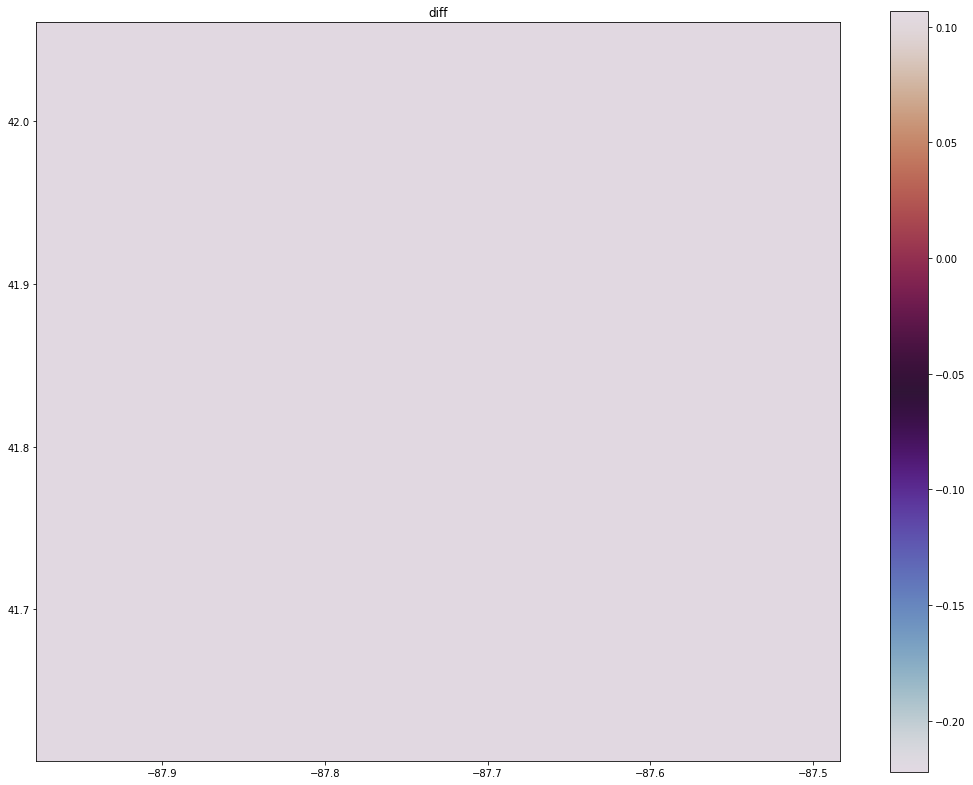

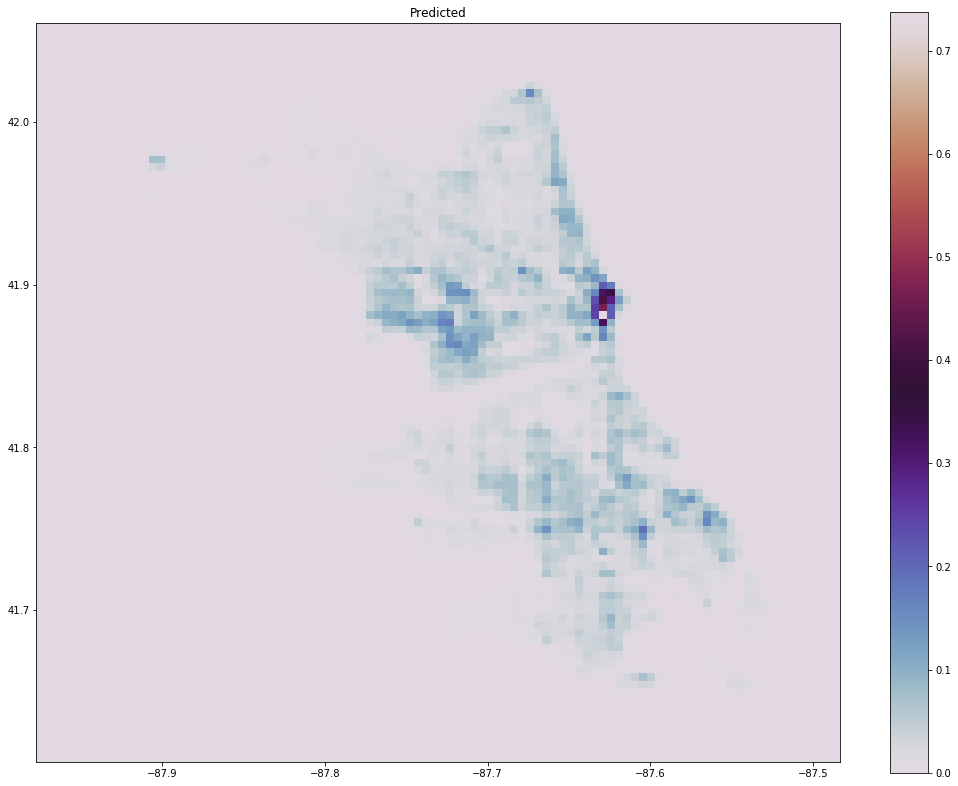

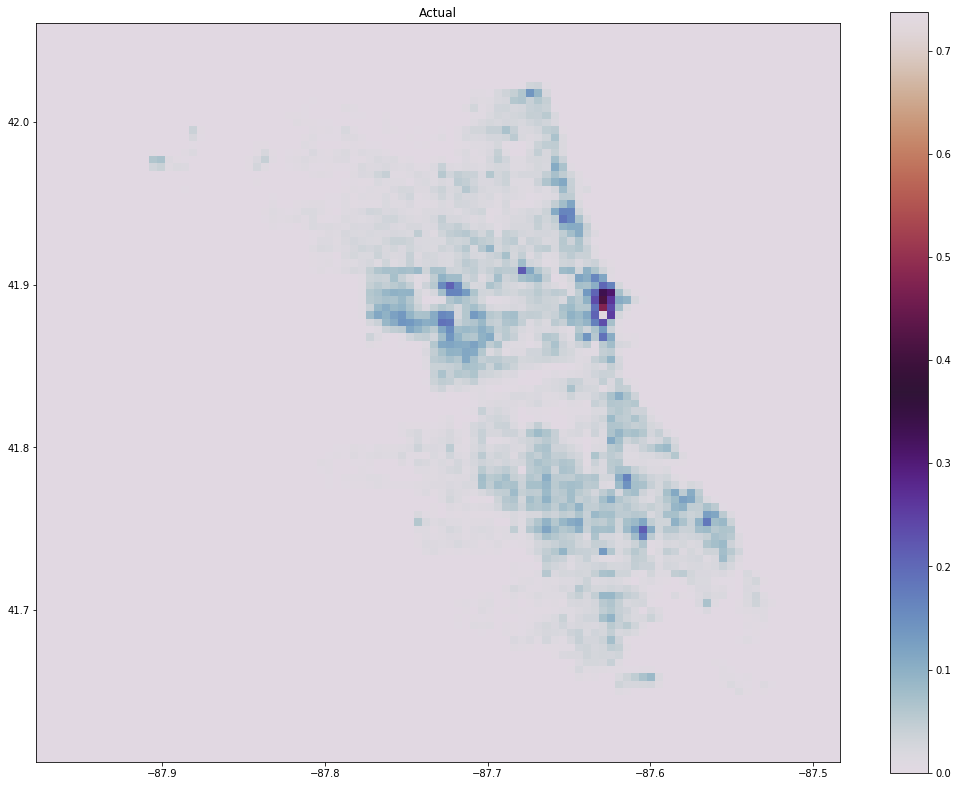

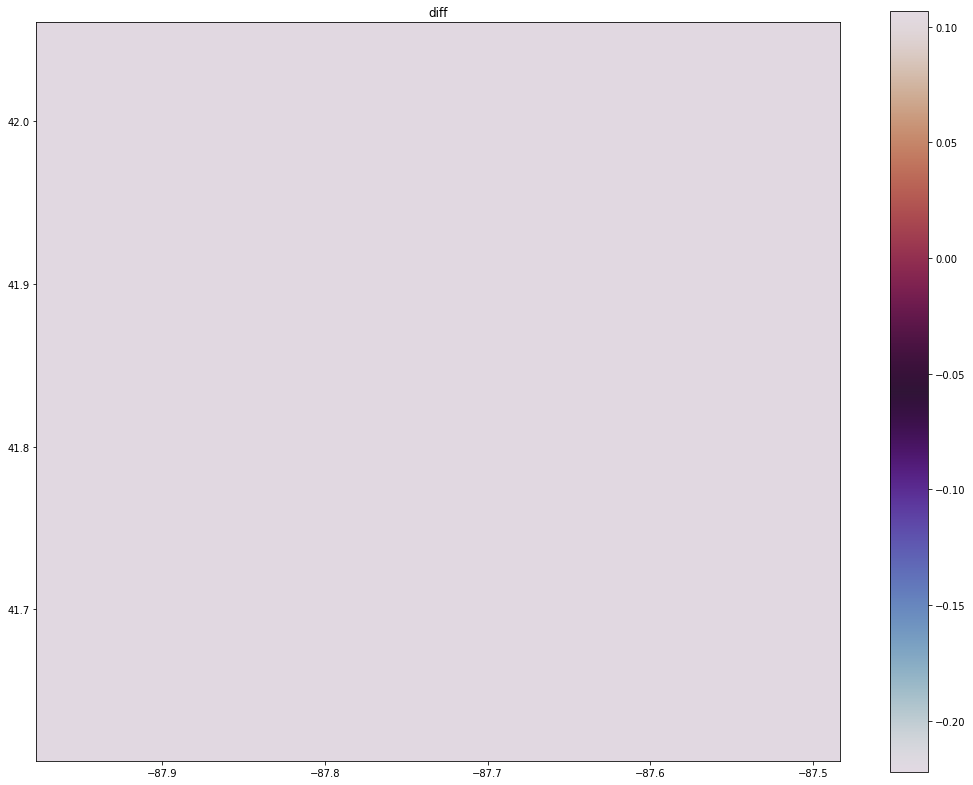

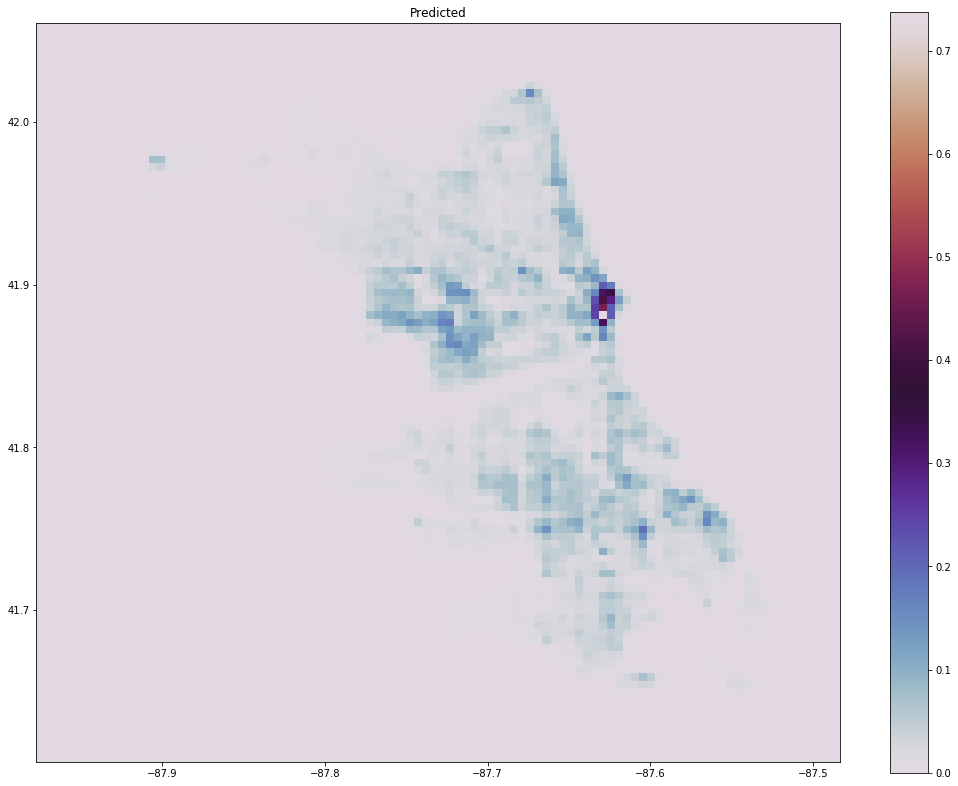

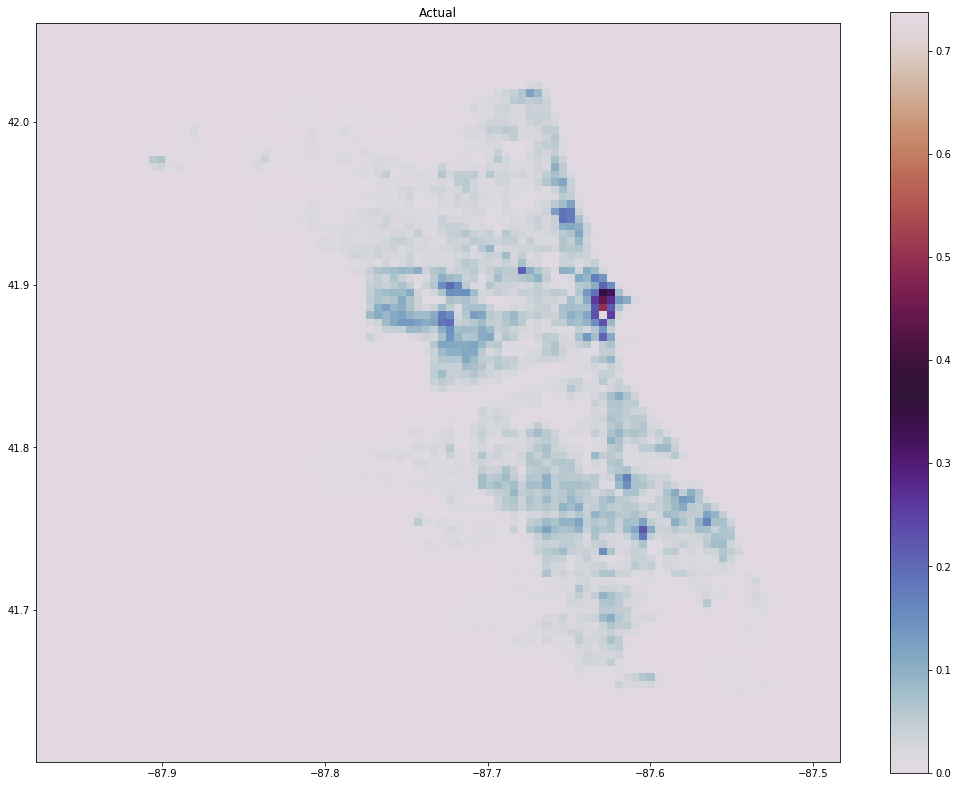

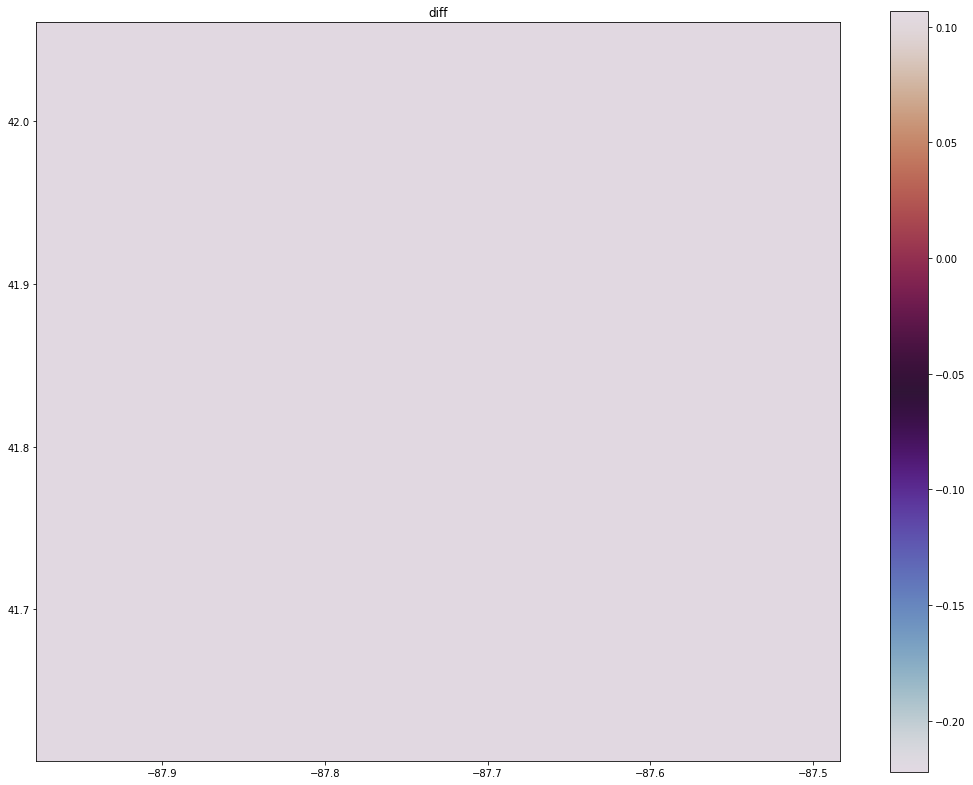

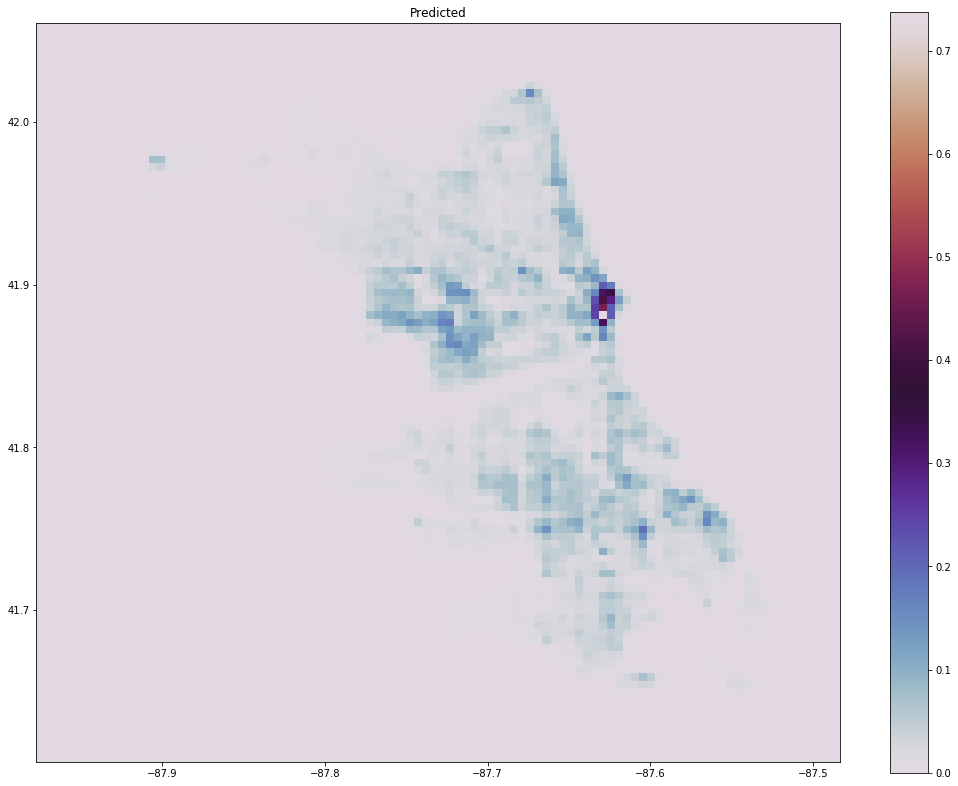

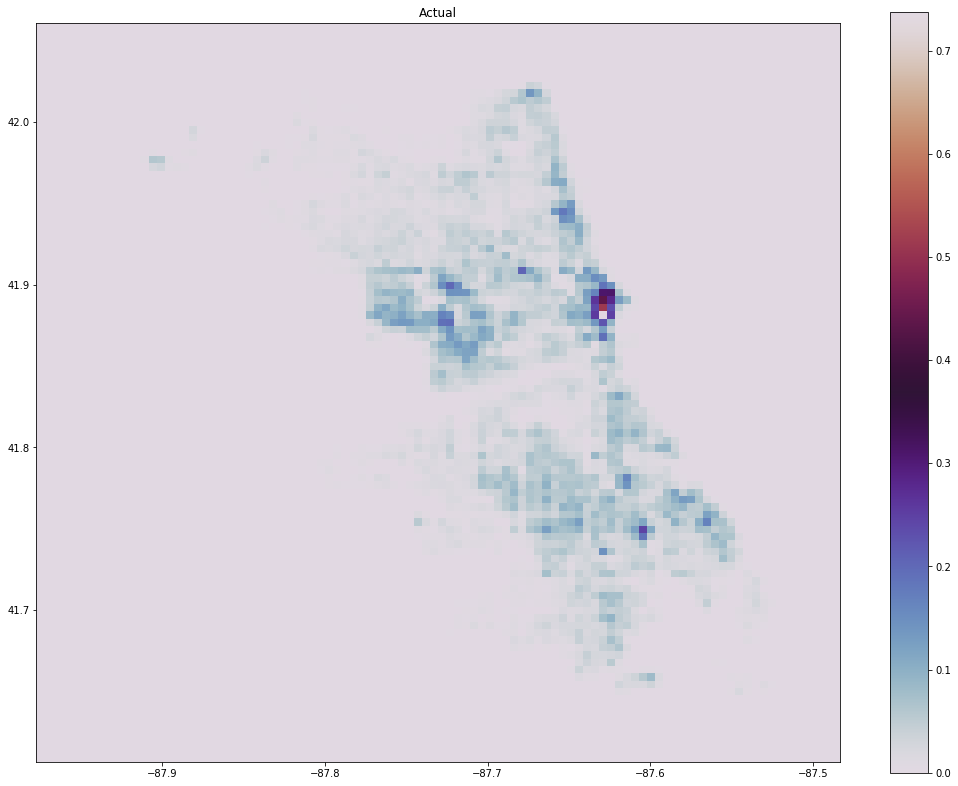

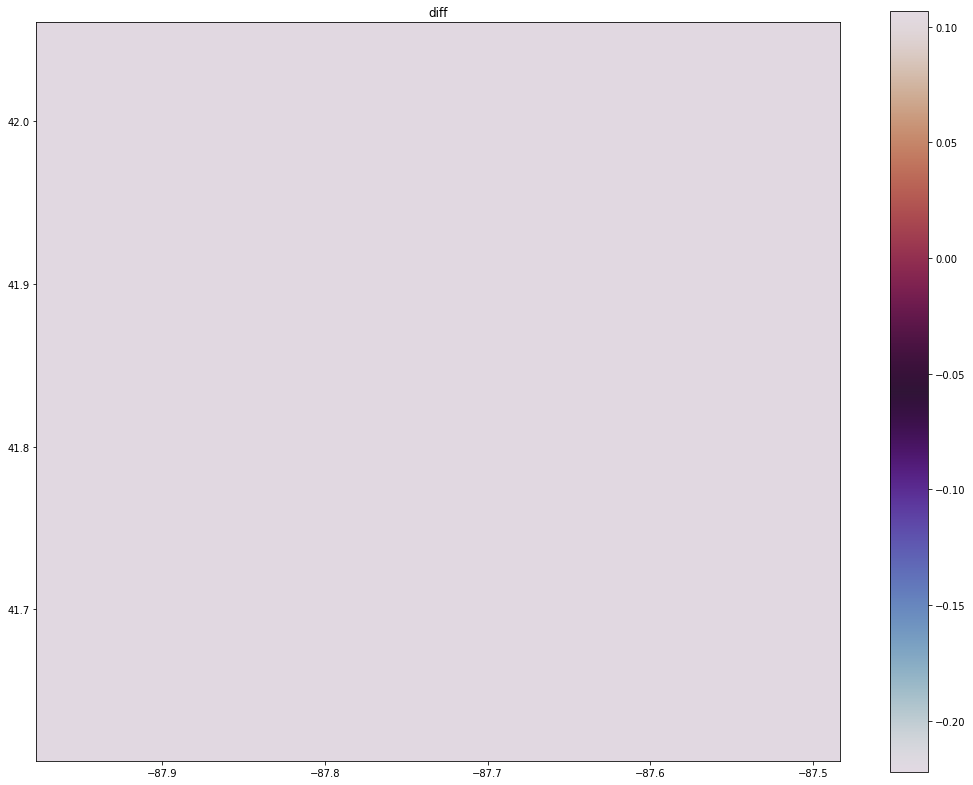

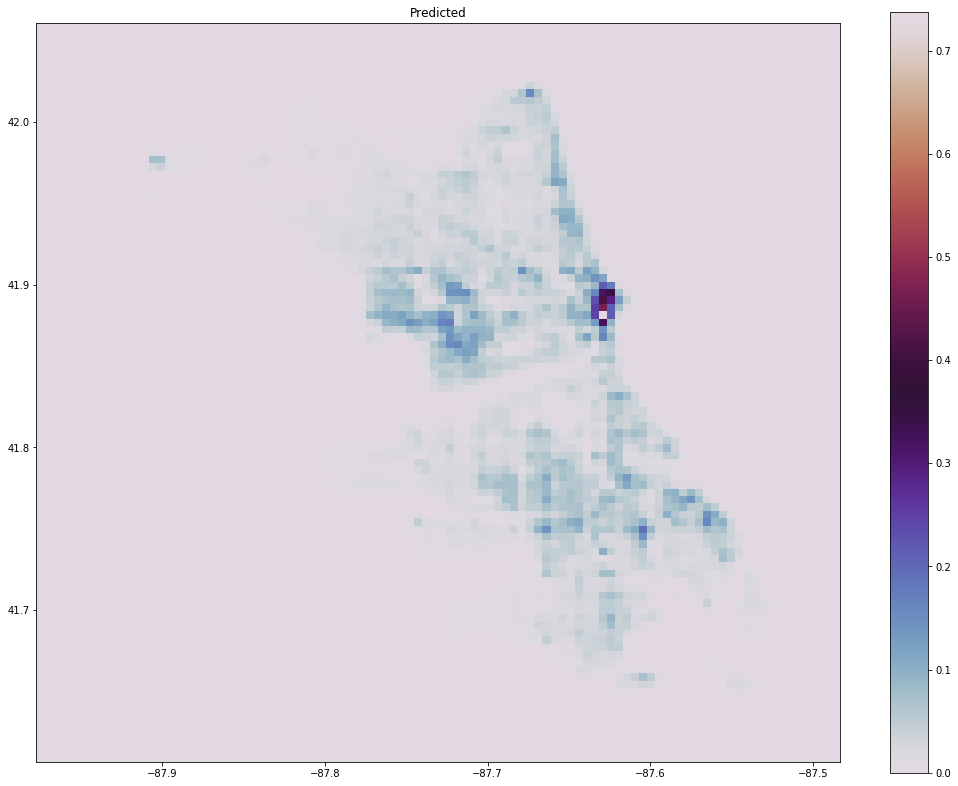

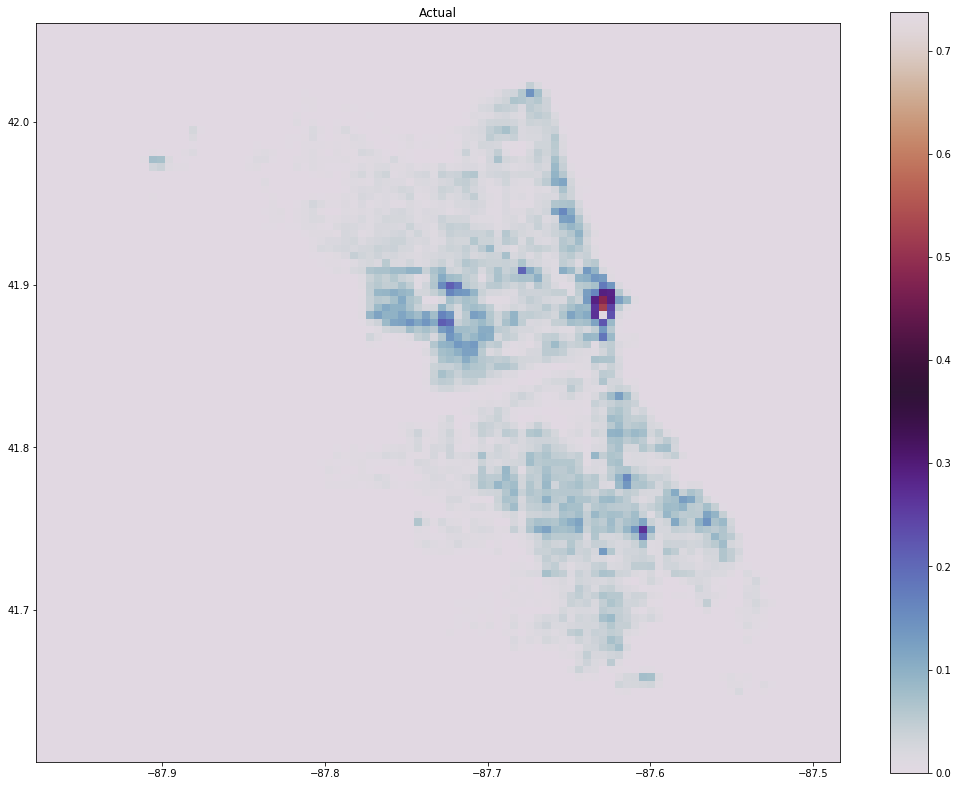

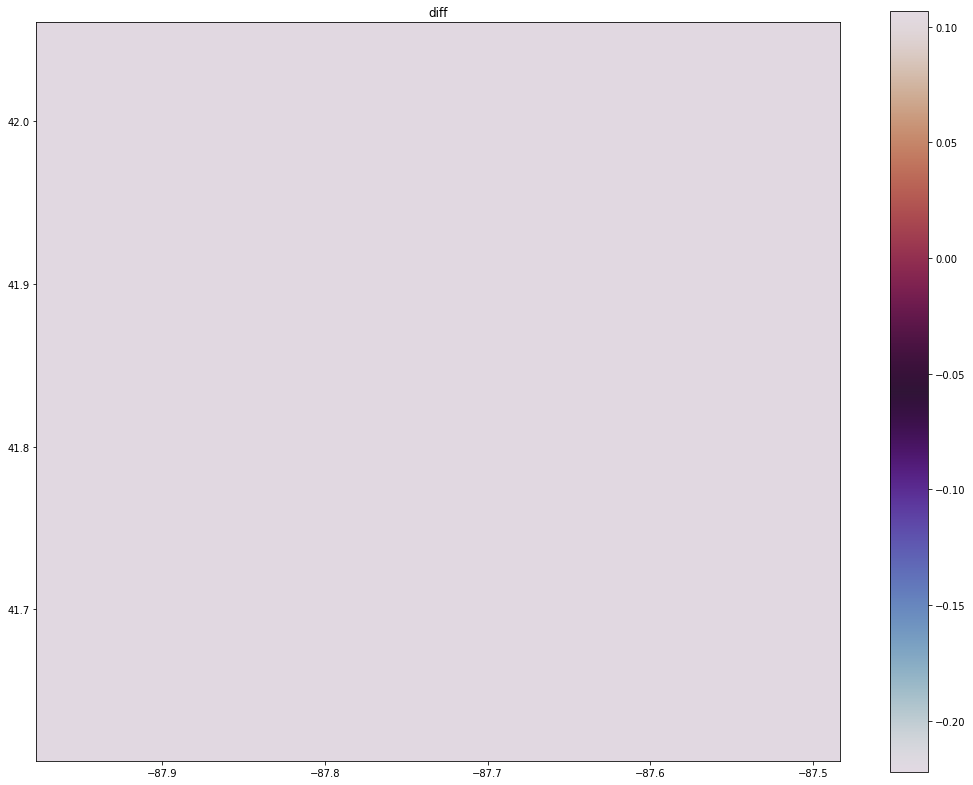

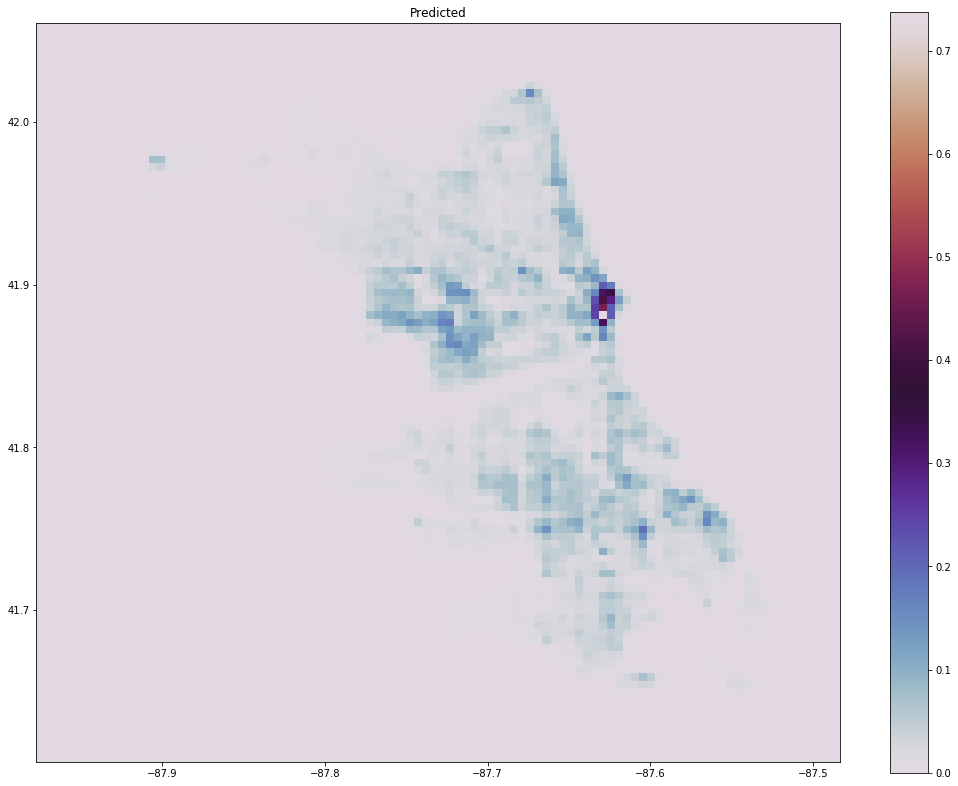

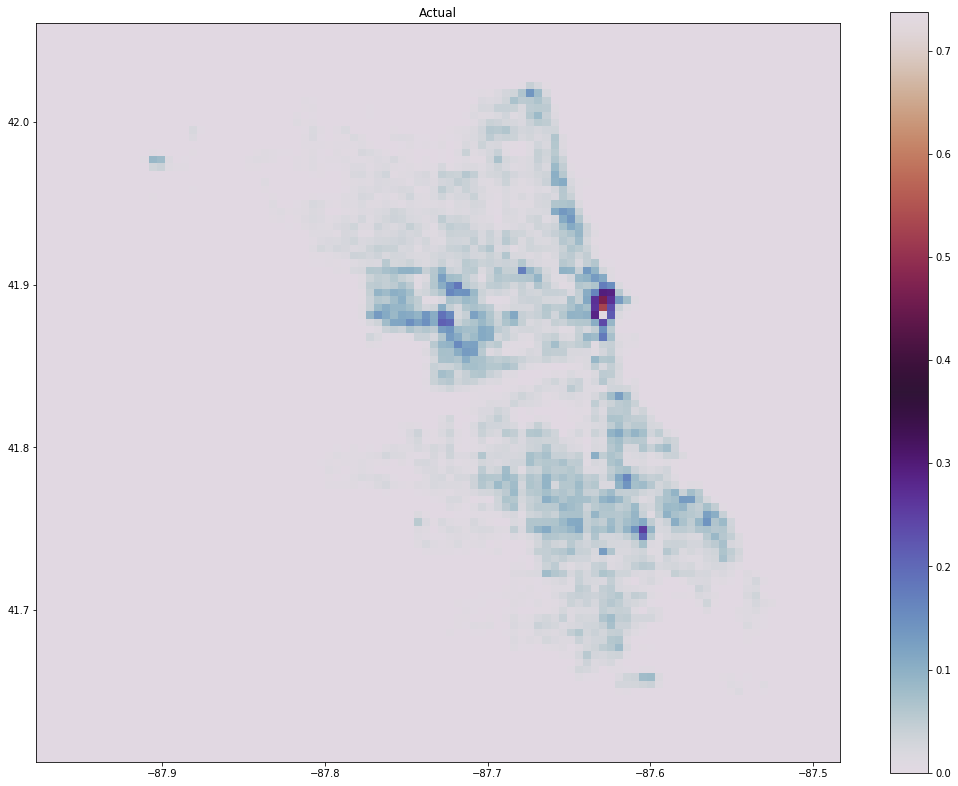

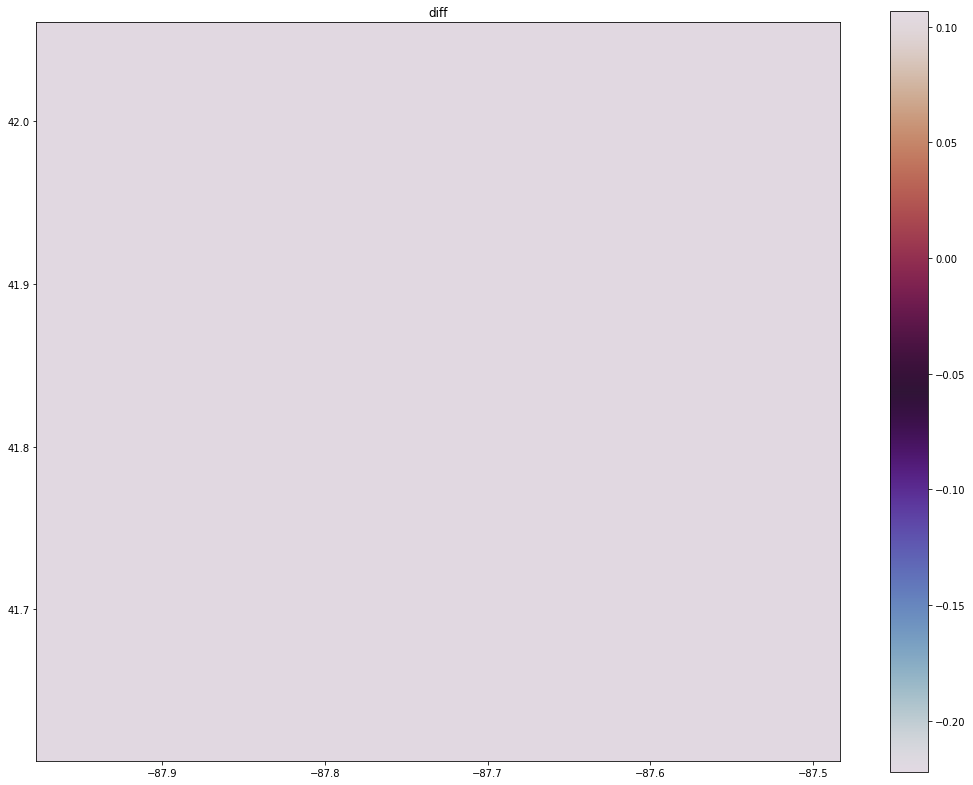

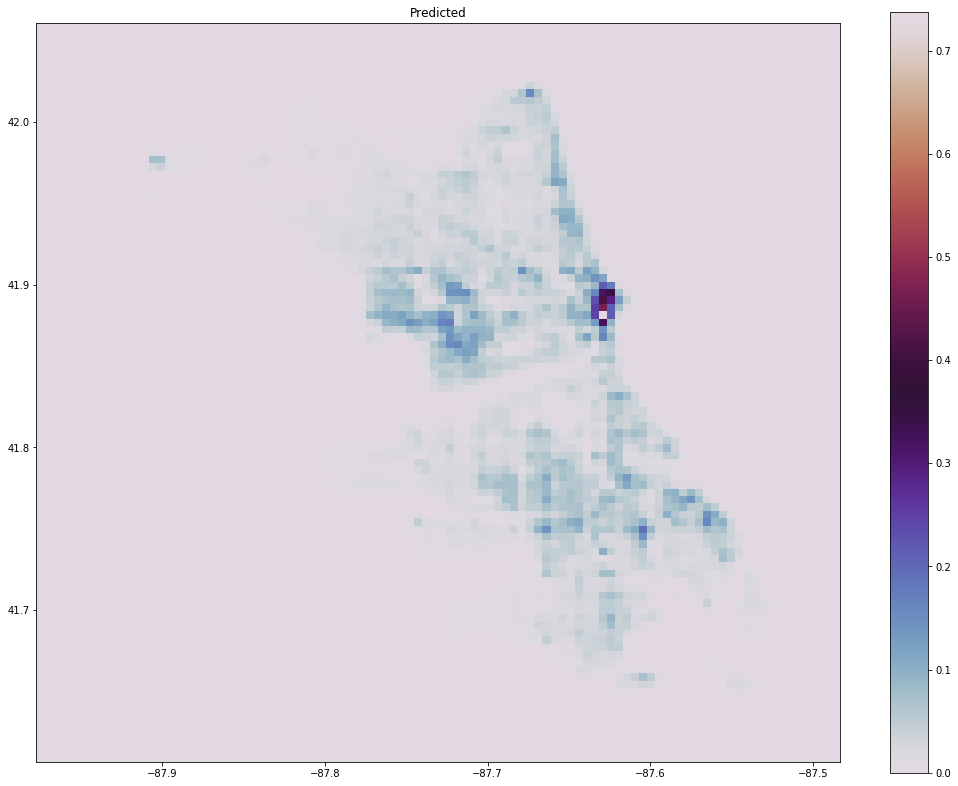

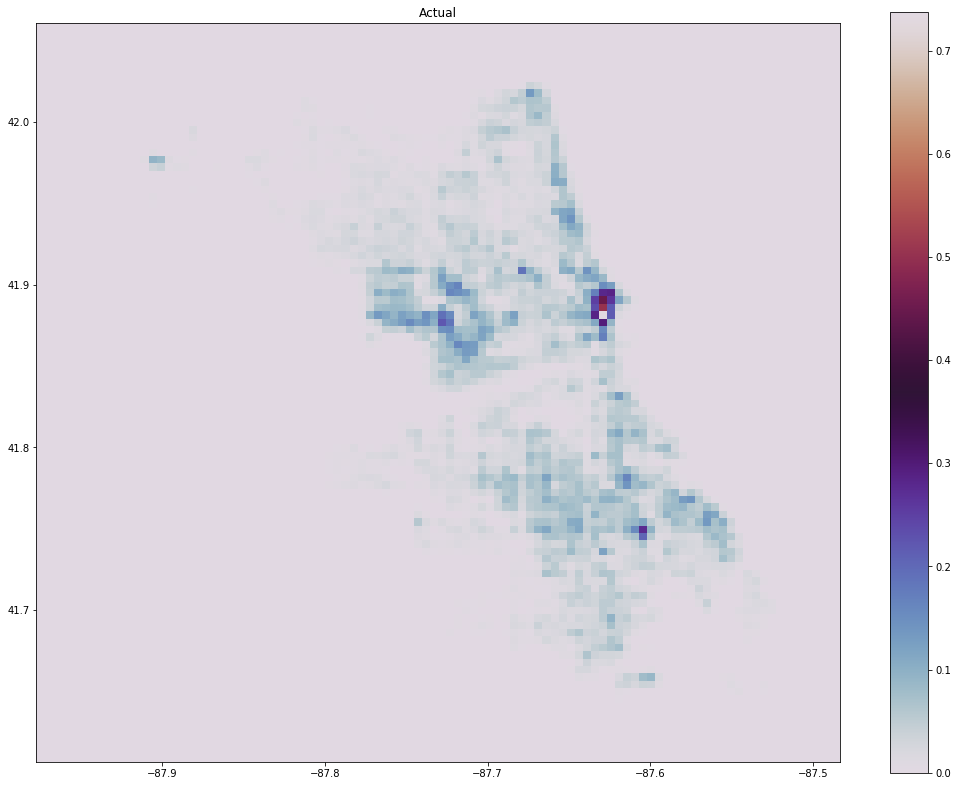

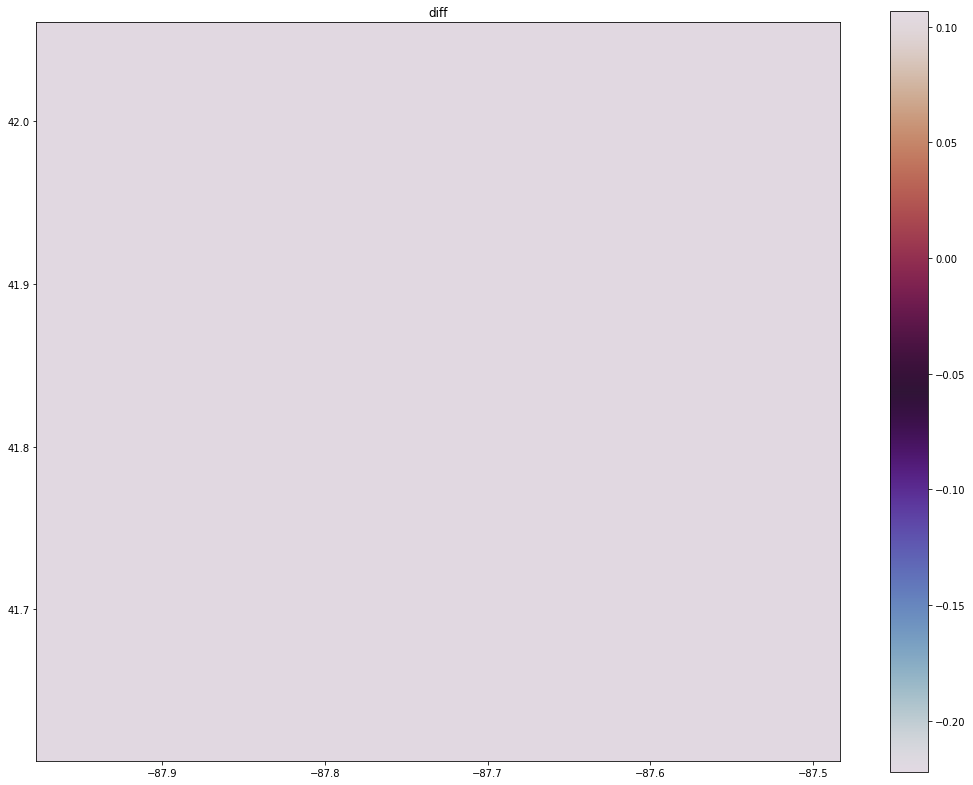

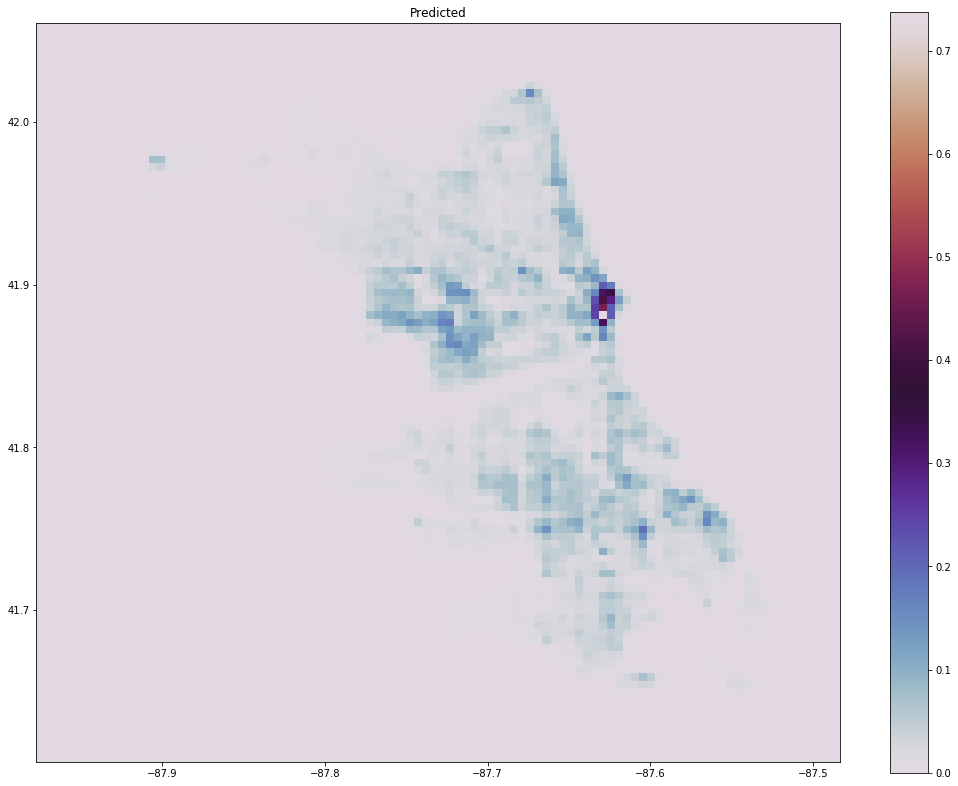

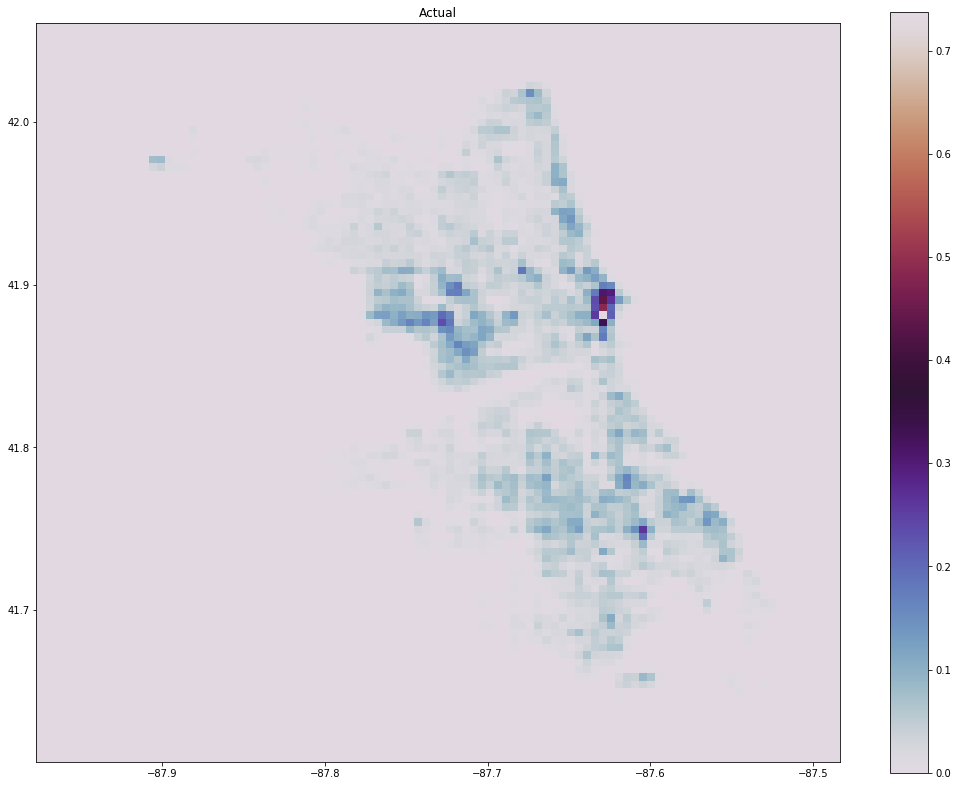

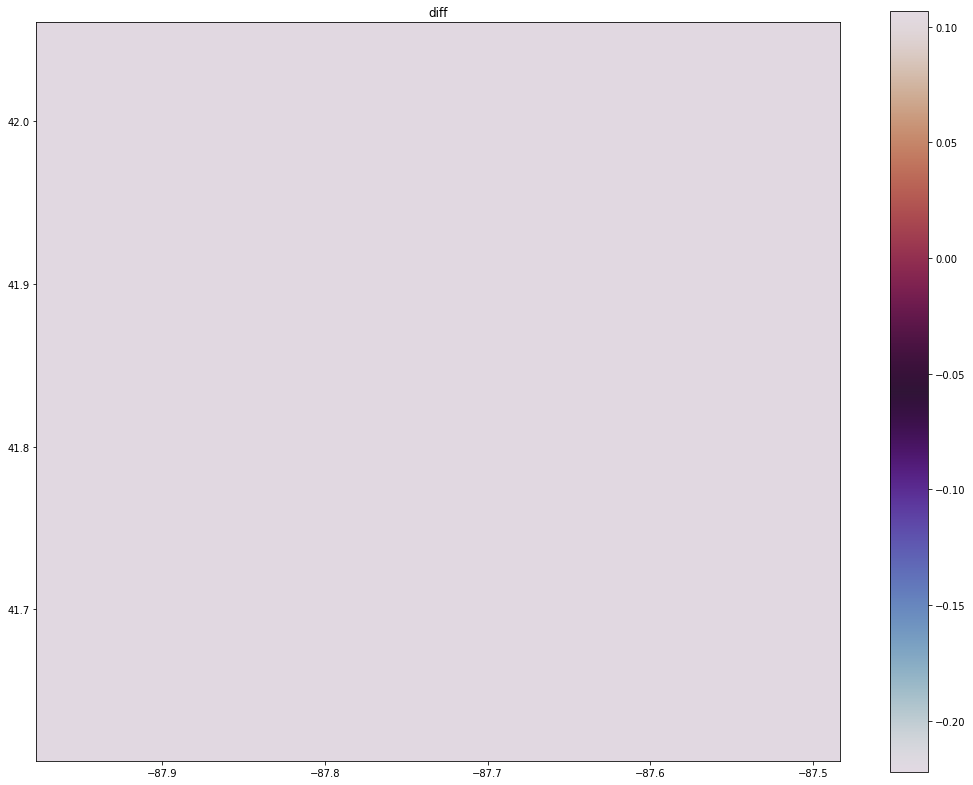

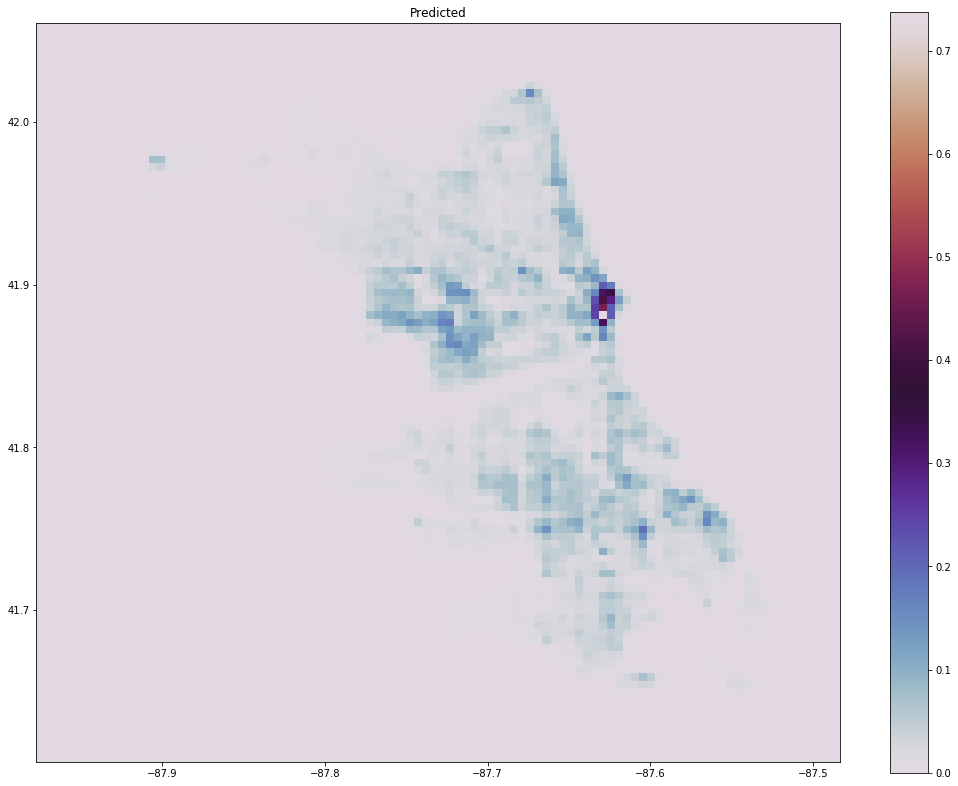

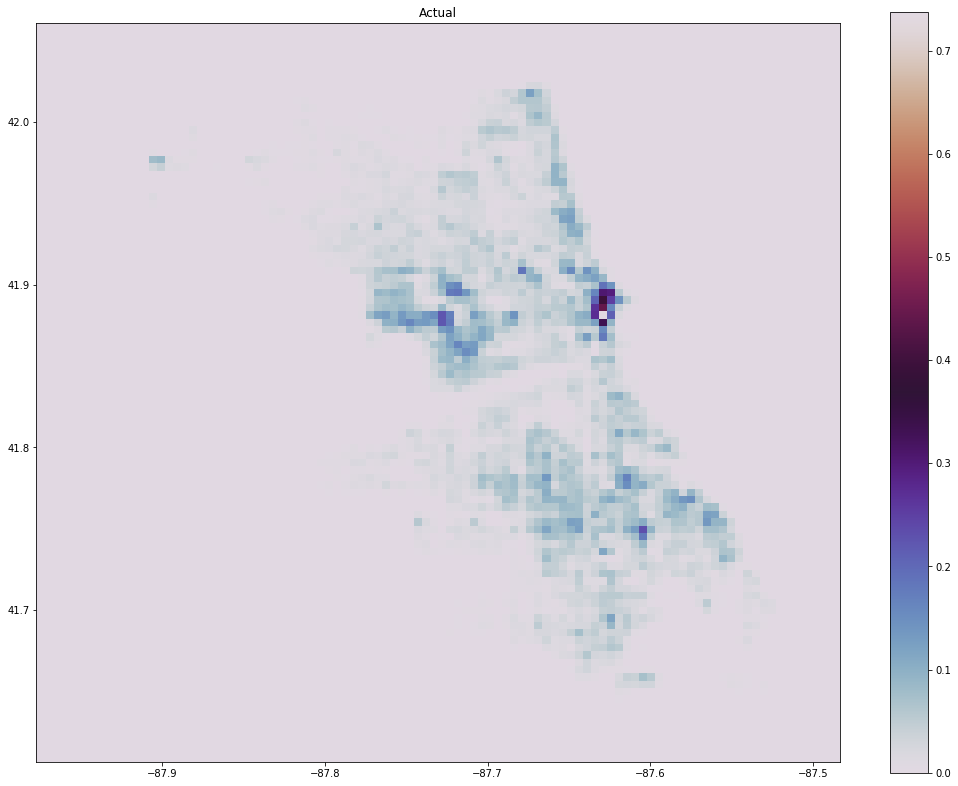

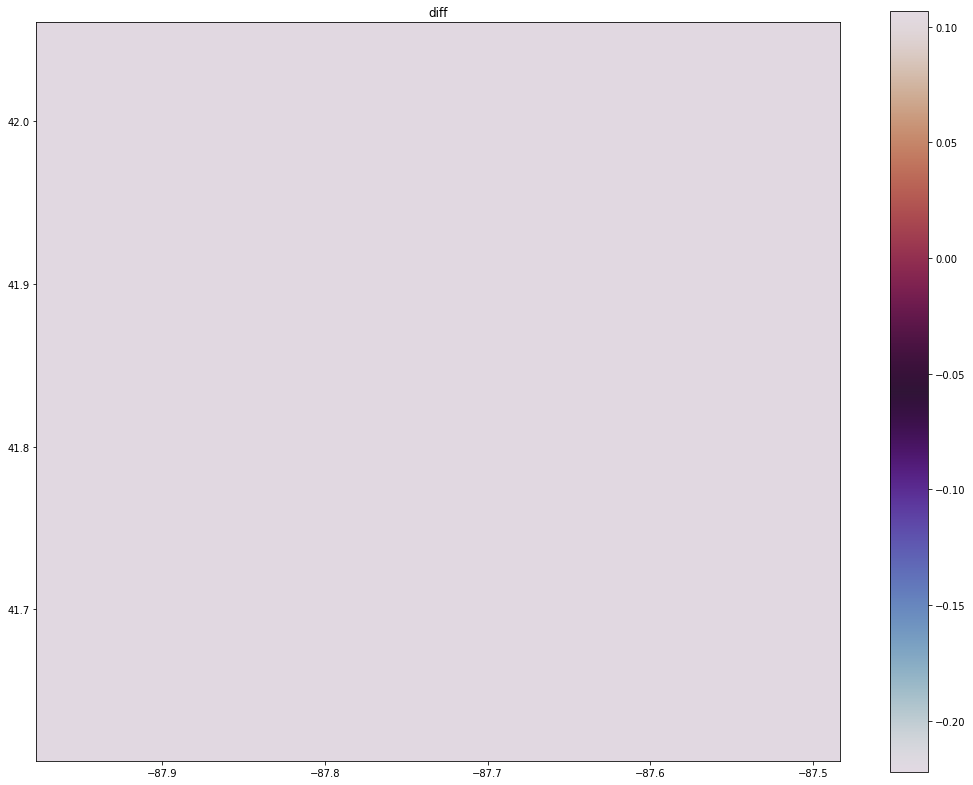

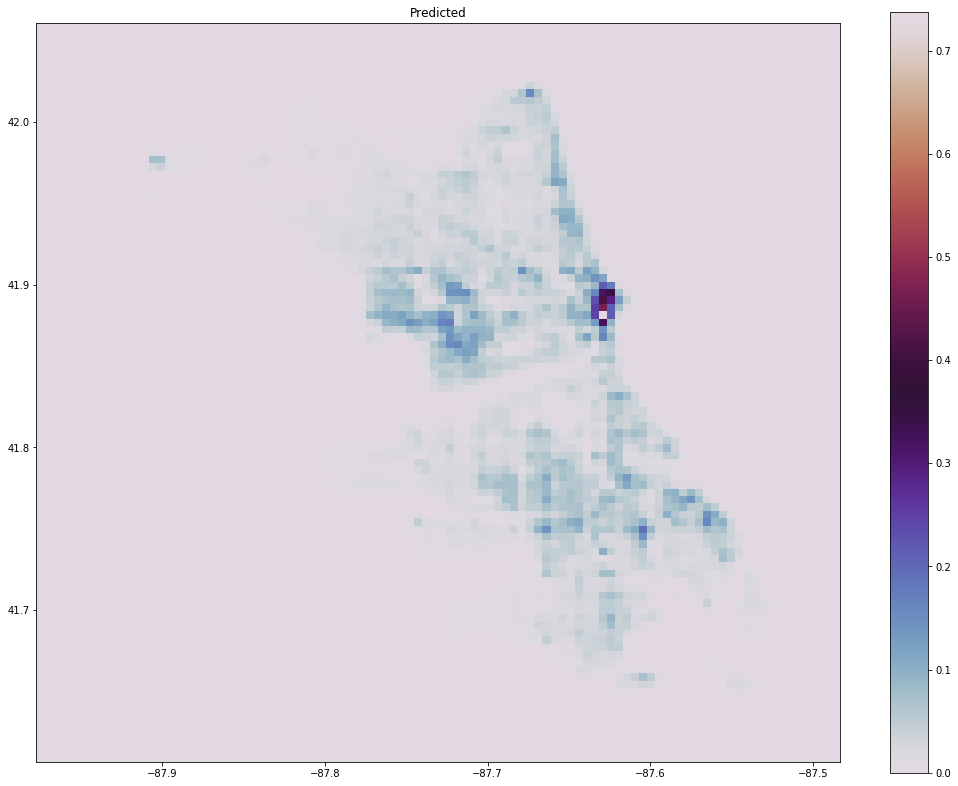

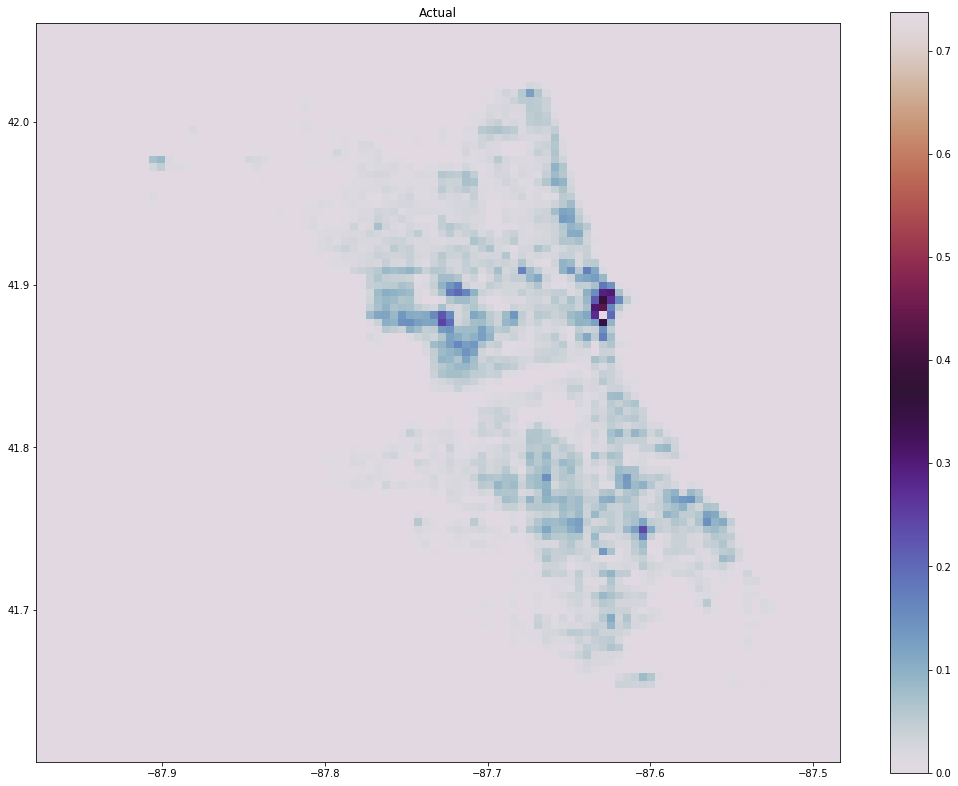

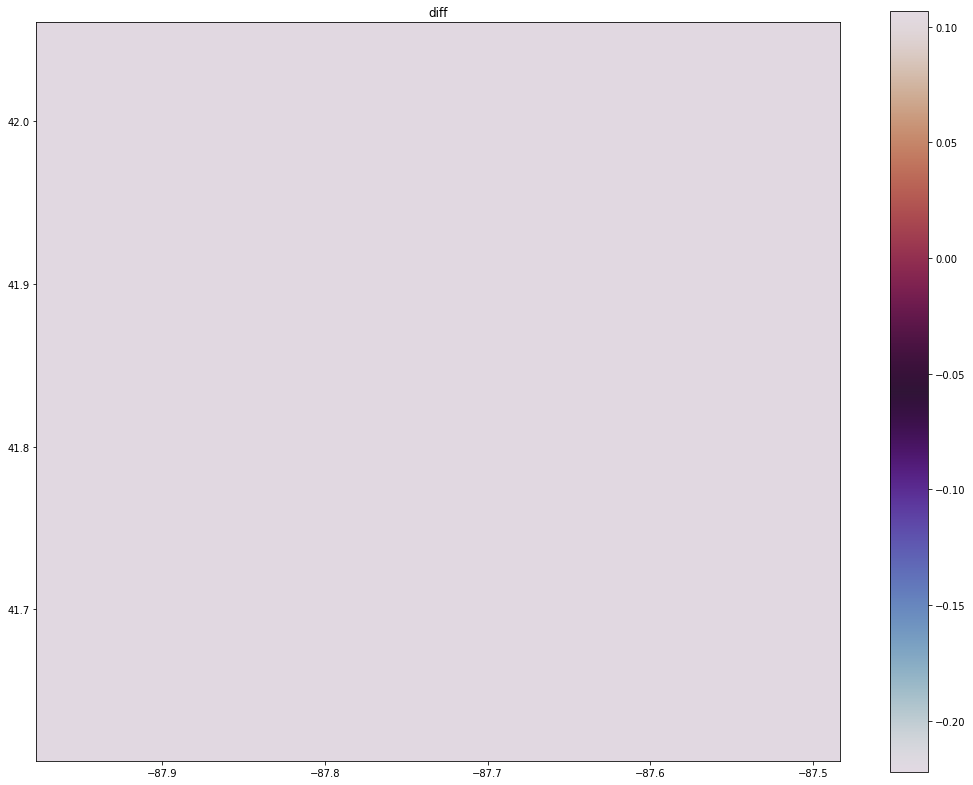

In [123]:
import matplotlib.pyplot as plt
grid_size = 500
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepFromLast in range(Y_valid.shape[0]):
    plt.figure(figsize=(18, 14))
    plt.title('Predicted')
    plt.imshow( X=reshapePred(Predict,timeStepFromLast),vmax=vmax,vmin=vmin, cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    
    plt.figure(figsize=(18, 14))
    plt.title('Actual')
    plt.imshow( X=reshapePred(Y_valid,timeStepFromLast ),vmax=vmax,vmin=vmin, cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    
    diff = reshapePred(Predict,timeStepFromLast)-reshapePred(Y_valid,timeStepFromLast )
    plt.figure(figsize=(18, 14))
    plt.title('diff')
    plt.imshow( X=scaleDiff(diff,diff_max,diff_min),vmax=dvmax,vmin=dvmin, cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()

#### We plot the difference between prediction and target

In [104]:
diff = (reshapePred(Y_valid,3)-reshapePred(Predict,3))
diff.shape

(100, 100)

In [105]:
diff_max = np.max(diff)
diff_min = np.min(diff)
scaled_diff = (diff - diff_min)/(diff_max - diff_min)

In [106]:
np.max(scaled_diff)

1.0

In [107]:
diff

array([[ 7.94683729e-06,  2.22705695e-08,  2.22705695e-08, ...,
        -2.22705693e-08, -2.22705693e-08,  1.54520421e-05],
       [-2.22705693e-08, -2.22705693e-08, -2.22705693e-08, ...,
         2.22705695e-08,  2.22705695e-08, -1.54520822e-05],
       [ 2.22705695e-08, -2.22705693e-08,  2.22705695e-08, ...,
        -2.22705693e-08, -2.22705693e-08, -2.72190846e-06],
       ...,
       [ 2.22705695e-08, -2.22705693e-08,  2.22705695e-08, ...,
         2.22705695e-08, -2.22705693e-08, -2.22705693e-08],
       [ 2.22705695e-08, -2.22705693e-08, -2.22705693e-08, ...,
         2.22705695e-08,  2.22705695e-08, -2.22705693e-08],
       [-2.22705693e-08, -2.72190846e-06,  2.22705695e-08, ...,
        -2.22705693e-08, -2.22705693e-08,  2.22705695e-08]])

In [108]:
vmax, vmin = np.max(diff), np.min(diff)

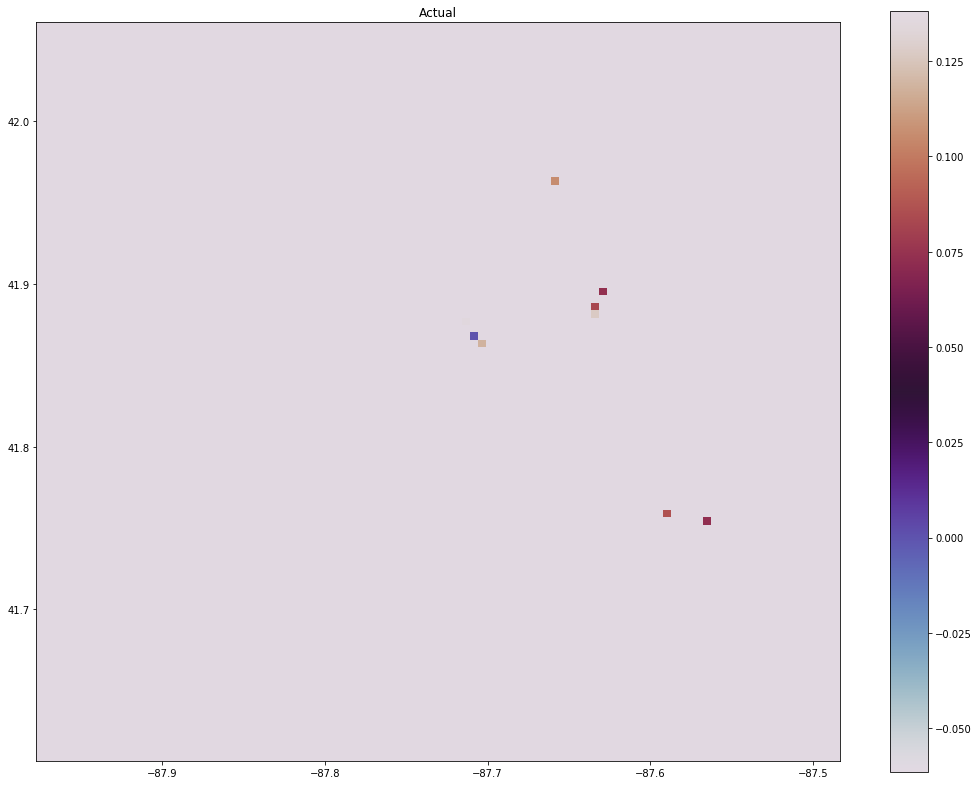

In [110]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=scaled_diff,vmax=vmax, vmin=vmin, cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])
plt.colorbar()

#### Note the differences is scaled, red means extreme differences inplot above. Interestingly we see the extreme differences is at the highest crime areas.